In [1]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.GeNVI_method import GeNVariationalInference, GeNetEns

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [3]:
#from Experiments.foong import Setup
#setup=Setup(device, layerwidth=50)

from Experiments.boston import Setup
setup=Setup(device)

# Target density #

In [4]:
logtarget= setup.logposterior
param_count=setup.param_count
model=setup._model


# AE-Variational Distribution #

In [19]:
activation = nn.Tanh()#nn.ReLU()
init_b = .001

GeN = GeNetEns(1, 2, 50, param_count, activation, 0.2, init_b, device)

In [20]:
from Tools import logmvn01pdf

x=torch.arange(-3.,3., 0.05).to(device)

grid_X,grid_Y=torch.meshgrid(x, x)
colors=torch.Tensor(grid_X.shape)

for i in range(colors.shape[0]):
    for j in range(colors.shape[1]):
        xy=torch.Tensor([grid_X[i,j],grid_Y[i,j]]).unsqueeze(0).to(device)
        colors[i,j]=logmvn01pdf(xy,device).exp().cpu()


In [21]:
noise=(grid_X.cpu().numpy(),grid_Y.cpu().numpy(),colors.cpu().numpy())

torch.Size([120, 120])

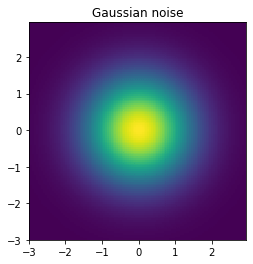

In [22]:
%matplotlib inline
import matplotlib.cm as cm

cmap = cm.viridis

plt.pcolormesh(noise[0],noise[1],noise[2],cmap=cmap)
plt.axis('scaled')
plt.title('Gaussian noise')
colors.shape

In [23]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm



%matplotlib inline



def makePlot(self, GeN,noise, alpha=0.05 ,device=device):
    def get_linewidth(linewidth, axis):
        fig = axis.get_figure()
        ppi = 72  # matplolib points per inches
        length = fig.bbox_inches.height * axis.get_position().height
        value_range = np.diff(axis.get_ylim())[0]
        return linewidth * ppi * length / value_range
#    nb_samples_plot=theta.shape[0]
    x_lin = torch.linspace(-2.0, 2.0).unsqueeze(1)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    plt.xlim(-2, 2) 
    plt.ylim(-4, 6)
    plt.grid(True, which='major', linewidth=0.5)
    my_lw=get_linewidth(0.2,ax)
#    alpha = (.9 / torch.tensor(float(nb_samples_plot)).sqrt()).clamp(0.05, 1.)
    
    colors=noise[2]
    
    norm=Normalize(vmin=colors.min(), vmax=colors.max())
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    for i in range(colors.shape[0]):
        for j in range(colors.shape[1]):
            xy_noise=torch.Tensor([noise[0][i,j],noise[1][i,j]]).unsqueeze(0).to(device)
            theta=GeN.components[0].hnet(xy_noise).detach()
            y_pred = self._normalized_prediction(x_lin, theta, device)
            color=m.to_rgba(colors[i,j])
            plt.plot(x_lin.detach().cpu().numpy(), y_pred.squeeze(0).detach().cpu().numpy(), alpha=alpha, linewidth=1.0, color=color,zorder=3)
    plt.scatter(self._X_train.cpu(), self._y_train.cpu(), marker='.',color='black',zorder=4)
    return fig



In [24]:
if setup.plot:
    fig=makePlot(setup,GeN,noise, alpha=0.01)


In [25]:
%matplotlib inline
from tempfile import TemporaryDirectory

with TemporaryDirectory() as temp_dir:
    optimizer = GeNVariationalInference(logtarget,
		                                    0, 100, 1000, 50, 100,
		                                    20000, .01, .000001, 500, .5,
		                                    device, True, temp_dir, save_best=True)
    best_epoch, scores=optimizer.run(GeN)
print(best_epoch)

Epoch [0/20000], Loss: 1349493.625, Entropy 93.4504165649414, Learning Rate: 0.01
Epoch [1/20000], Loss: 2218543.0, Entropy 80.54517364501953, Learning Rate: 0.01
Epoch [2/20000], Loss: 756919.125, Entropy 58.206233978271484, Learning Rate: 0.01
Epoch [3/20000], Loss: 442180.5, Entropy 42.06381607055664, Learning Rate: 0.01
Epoch [4/20000], Loss: 374216.28125, Entropy 48.28152847290039, Learning Rate: 0.01
Epoch [5/20000], Loss: 405307.6875, Entropy 34.075439453125, Learning Rate: 0.01
Epoch [6/20000], Loss: 253751.46875, Entropy 19.20648956298828, Learning Rate: 0.01
Epoch [7/20000], Loss: 290403.75, Entropy 20.25414276123047, Learning Rate: 0.01
Epoch [8/20000], Loss: 224982.265625, Entropy 28.900829315185547, Learning Rate: 0.01
Epoch [9/20000], Loss: 146088.75, Entropy 11.689711570739746, Learning Rate: 0.01
Epoch [10/20000], Loss: 126942.5234375, Entropy 4.480998516082764, Learning Rate: 0.01
Epoch [11/20000], Loss: 106372.65625, Entropy 3.9702978134155273, Learning Rate: 0.01
Epo

Epoch [94/20000], Loss: 2796.086669921875, Entropy -92.37513732910156, Learning Rate: 0.01
Epoch [95/20000], Loss: 3129.62451171875, Entropy -93.6249771118164, Learning Rate: 0.01
Epoch [96/20000], Loss: 2820.513671875, Entropy -93.10613250732422, Learning Rate: 0.01
Epoch [97/20000], Loss: 2945.91748046875, Entropy -95.18148040771484, Learning Rate: 0.01
Epoch [98/20000], Loss: 2658.515625, Entropy -97.22900390625, Learning Rate: 0.01
Epoch [99/20000], Loss: 2546.417724609375, Entropy -103.56561279296875, Learning Rate: 0.01
Epoch [100/20000], Loss: 2900.204833984375, Entropy -100.82254028320312, Learning Rate: 0.01
Epoch [101/20000], Loss: 2510.037841796875, Entropy -97.1315689086914, Learning Rate: 0.01
Epoch [102/20000], Loss: 2860.396728515625, Entropy -84.62399291992188, Learning Rate: 0.01
Epoch [103/20000], Loss: 2930.959716796875, Entropy -97.21400451660156, Learning Rate: 0.01
Epoch [104/20000], Loss: 2640.25048828125, Entropy -109.90084838867188, Learning Rate: 0.01
Epoch [1

Epoch [192/20000], Loss: 1889.0433349609375, Entropy -119.8416976928711, Learning Rate: 0.01
Epoch [193/20000], Loss: 1985.5257568359375, Entropy -121.98081970214844, Learning Rate: 0.01
Epoch [194/20000], Loss: 1980.932373046875, Entropy -98.73074340820312, Learning Rate: 0.01
Epoch [195/20000], Loss: 2036.5128173828125, Entropy -113.2931900024414, Learning Rate: 0.01
Epoch [196/20000], Loss: 1931.4749755859375, Entropy -107.81511688232422, Learning Rate: 0.01
Epoch [197/20000], Loss: 2053.625732421875, Entropy -118.51766967773438, Learning Rate: 0.01
Epoch [198/20000], Loss: 2057.249267578125, Entropy -109.62151336669922, Learning Rate: 0.01
Epoch [199/20000], Loss: 2096.83251953125, Entropy -102.22559356689453, Learning Rate: 0.01
Epoch [200/20000], Loss: 2051.87353515625, Entropy -119.18095397949219, Learning Rate: 0.01
Epoch [201/20000], Loss: 1927.1358642578125, Entropy -97.14370727539062, Learning Rate: 0.01
Epoch [202/20000], Loss: 2048.365966796875, Entropy -114.66425323486328

Epoch [288/20000], Loss: 1740.1978759765625, Entropy -108.75137329101562, Learning Rate: 0.01
Epoch [289/20000], Loss: 1695.4173583984375, Entropy -110.72959899902344, Learning Rate: 0.01
Epoch [290/20000], Loss: 1743.0050048828125, Entropy -108.34354400634766, Learning Rate: 0.01
Epoch [291/20000], Loss: 1664.840576171875, Entropy -93.86959838867188, Learning Rate: 0.01
Epoch [292/20000], Loss: 1884.3155517578125, Entropy -96.97105407714844, Learning Rate: 0.01
Epoch [293/20000], Loss: 1735.6209716796875, Entropy -106.46949005126953, Learning Rate: 0.01
Epoch [294/20000], Loss: 1686.4476318359375, Entropy -93.39058685302734, Learning Rate: 0.01
Epoch [295/20000], Loss: 1745.188720703125, Entropy -101.15847778320312, Learning Rate: 0.01
Epoch [296/20000], Loss: 1669.563232421875, Entropy -119.54816436767578, Learning Rate: 0.01
Epoch [297/20000], Loss: 1918.495361328125, Entropy -121.0810317993164, Learning Rate: 0.01
Epoch [298/20000], Loss: 1665.3359375, Entropy -97.34999084472656, L

Epoch [385/20000], Loss: 1589.4449462890625, Entropy -113.67286682128906, Learning Rate: 0.01
Epoch [386/20000], Loss: 1554.5322265625, Entropy -117.92851257324219, Learning Rate: 0.01
Epoch [387/20000], Loss: 1625.955322265625, Entropy -95.3973388671875, Learning Rate: 0.01
Epoch [388/20000], Loss: 1584.192626953125, Entropy -105.54466247558594, Learning Rate: 0.01
Epoch [389/20000], Loss: 1615.345458984375, Entropy -107.48169708251953, Learning Rate: 0.01
Epoch [390/20000], Loss: 1570.3299560546875, Entropy -111.4007568359375, Learning Rate: 0.01
Epoch [391/20000], Loss: 1568.341552734375, Entropy -93.35980987548828, Learning Rate: 0.01
Epoch [392/20000], Loss: 1596.945068359375, Entropy -121.47716522216797, Learning Rate: 0.01
Epoch [393/20000], Loss: 1501.1376953125, Entropy -89.15985870361328, Learning Rate: 0.01
Epoch [394/20000], Loss: 1637.0177001953125, Entropy -93.40767669677734, Learning Rate: 0.01
Epoch [395/20000], Loss: 1506.5494384765625, Entropy -86.70769500732422, Lear

Epoch [481/20000], Loss: 1478.697021484375, Entropy -81.86670684814453, Learning Rate: 0.01
Epoch [482/20000], Loss: 1493.8563232421875, Entropy -88.4627685546875, Learning Rate: 0.01
Epoch [483/20000], Loss: 1459.6702880859375, Entropy -86.6491470336914, Learning Rate: 0.01
Epoch [484/20000], Loss: 1433.024169921875, Entropy -64.92041015625, Learning Rate: 0.01
Epoch [485/20000], Loss: 1435.45068359375, Entropy -77.6884536743164, Learning Rate: 0.01
Epoch [486/20000], Loss: 1389.0389404296875, Entropy -66.92394256591797, Learning Rate: 0.01
Epoch [487/20000], Loss: 1782.197998046875, Entropy -71.67876434326172, Learning Rate: 0.01
Epoch [488/20000], Loss: 1479.8956298828125, Entropy -93.50538635253906, Learning Rate: 0.01
Epoch [489/20000], Loss: 1457.5330810546875, Entropy -88.23943328857422, Learning Rate: 0.01
Epoch [490/20000], Loss: 1465.1741943359375, Entropy -79.49752044677734, Learning Rate: 0.01
Epoch [491/20000], Loss: 1456.368896484375, Entropy -83.99121856689453, Learning 

Epoch [578/20000], Loss: 1552.65234375, Entropy -76.39990997314453, Learning Rate: 0.01
Epoch [579/20000], Loss: 1529.8446044921875, Entropy -59.70209884643555, Learning Rate: 0.01
Epoch [580/20000], Loss: 1473.6170654296875, Entropy -71.7439956665039, Learning Rate: 0.01
Epoch [581/20000], Loss: 1498.3643798828125, Entropy -65.25812530517578, Learning Rate: 0.01
Epoch [582/20000], Loss: 1384.6898193359375, Entropy -82.06655883789062, Learning Rate: 0.01
Epoch [583/20000], Loss: 1483.8328857421875, Entropy -90.23171997070312, Learning Rate: 0.01
Epoch [584/20000], Loss: 1386.8289794921875, Entropy -84.0326156616211, Learning Rate: 0.01
Epoch [585/20000], Loss: 1496.0428466796875, Entropy -73.43184661865234, Learning Rate: 0.01
Epoch [586/20000], Loss: 1476.63623046875, Entropy -61.19147491455078, Learning Rate: 0.01
Epoch [587/20000], Loss: 1388.9677734375, Entropy -64.0771255493164, Learning Rate: 0.01
Epoch [588/20000], Loss: 1366.855224609375, Entropy -73.98424530029297, Learning Ra

Epoch [677/20000], Loss: 1433.93017578125, Entropy -70.06893157958984, Learning Rate: 0.01
Epoch [678/20000], Loss: 1378.88623046875, Entropy -68.92327880859375, Learning Rate: 0.01
Epoch [679/20000], Loss: 1388.576904296875, Entropy -58.968631744384766, Learning Rate: 0.01
Epoch [680/20000], Loss: 1442.722412109375, Entropy -62.37117385864258, Learning Rate: 0.01
Epoch [681/20000], Loss: 1429.3236083984375, Entropy -57.261474609375, Learning Rate: 0.01
Epoch [682/20000], Loss: 1416.865478515625, Entropy -64.33524322509766, Learning Rate: 0.01
Epoch [683/20000], Loss: 1354.3731689453125, Entropy -72.14769744873047, Learning Rate: 0.01
Epoch [684/20000], Loss: 1443.827392578125, Entropy -57.84458923339844, Learning Rate: 0.01
Epoch [685/20000], Loss: 1393.731201171875, Entropy -68.07255554199219, Learning Rate: 0.01
Epoch [686/20000], Loss: 1336.7196044921875, Entropy -70.30874633789062, Learning Rate: 0.01
Epoch [687/20000], Loss: 1378.77880859375, Entropy -72.89604949951172, Learning 

Epoch [775/20000], Loss: 1454.1904296875, Entropy -50.425418853759766, Learning Rate: 0.01
Epoch [776/20000], Loss: 1290.65966796875, Entropy -39.566810607910156, Learning Rate: 0.01
Epoch [777/20000], Loss: 1342.735595703125, Entropy -43.317996978759766, Learning Rate: 0.01
Epoch [778/20000], Loss: 1336.7322998046875, Entropy -62.28507614135742, Learning Rate: 0.01
Epoch [779/20000], Loss: 1317.492431640625, Entropy -51.00453186035156, Learning Rate: 0.01
Epoch [780/20000], Loss: 1390.4091796875, Entropy -45.05242919921875, Learning Rate: 0.01
Epoch [781/20000], Loss: 1385.650390625, Entropy -59.79297637939453, Learning Rate: 0.01
Epoch [782/20000], Loss: 1346.2532958984375, Entropy -47.32205581665039, Learning Rate: 0.01
Epoch [783/20000], Loss: 1366.3026123046875, Entropy -38.886253356933594, Learning Rate: 0.01
Epoch [784/20000], Loss: 1357.0721435546875, Entropy -47.75766372680664, Learning Rate: 0.01
Epoch [785/20000], Loss: 1283.4068603515625, Entropy -54.10784149169922, Learnin

Epoch [872/20000], Loss: 1593.036376953125, Entropy -35.41357421875, Learning Rate: 0.01
Epoch [873/20000], Loss: 1379.7593994140625, Entropy -48.03203201293945, Learning Rate: 0.01
Epoch [874/20000], Loss: 1535.795654296875, Entropy -40.83792495727539, Learning Rate: 0.01
Epoch [875/20000], Loss: 1462.859619140625, Entropy -49.84686279296875, Learning Rate: 0.01
Epoch [876/20000], Loss: 1349.8603515625, Entropy -24.88416862487793, Learning Rate: 0.01
Epoch [877/20000], Loss: 1381.4755859375, Entropy -39.39445495605469, Learning Rate: 0.01
Epoch [878/20000], Loss: 1352.5611572265625, Entropy -45.94345474243164, Learning Rate: 0.01
Epoch [879/20000], Loss: 1301.677978515625, Entropy -30.90968132019043, Learning Rate: 0.01
Epoch [880/20000], Loss: 1339.0465087890625, Entropy -39.00135040283203, Learning Rate: 0.01
Epoch [881/20000], Loss: 1359.3443603515625, Entropy -39.70738983154297, Learning Rate: 0.01
Epoch [882/20000], Loss: 1344.6221923828125, Entropy -42.90729522705078, Learning R

Epoch [970/20000], Loss: 1292.5989990234375, Entropy -17.29062843322754, Learning Rate: 0.01
Epoch [971/20000], Loss: 1383.2987060546875, Entropy -5.157846450805664, Learning Rate: 0.01
Epoch [972/20000], Loss: 1283.3228759765625, Entropy -22.03423500061035, Learning Rate: 0.01
Epoch [973/20000], Loss: 1354.5150146484375, Entropy -8.935020446777344, Learning Rate: 0.01
Epoch [974/20000], Loss: 1311.238037109375, Entropy -12.417266845703125, Learning Rate: 0.01
Epoch [975/20000], Loss: 1340.7476806640625, Entropy -24.04781723022461, Learning Rate: 0.01
Epoch [976/20000], Loss: 1535.5989990234375, Entropy -22.941192626953125, Learning Rate: 0.01
Epoch [977/20000], Loss: 1320.396240234375, Entropy -23.37360382080078, Learning Rate: 0.01
Epoch [978/20000], Loss: 1418.23291015625, Entropy -19.967634201049805, Learning Rate: 0.01
Epoch [979/20000], Loss: 1346.5181884765625, Entropy -10.91653060913086, Learning Rate: 0.01
Epoch [980/20000], Loss: 1587.5042724609375, Entropy -22.79475593566894

Epoch [1066/20000], Loss: 1526.9034423828125, Entropy -4.814748287200928, Learning Rate: 0.01
Epoch [1067/20000], Loss: 2280.943359375, Entropy -9.88473129272461, Learning Rate: 0.01
Epoch [1068/20000], Loss: 1367.459228515625, Entropy -11.128096580505371, Learning Rate: 0.01
Epoch [1069/20000], Loss: 1925.586181640625, Entropy -11.601227760314941, Learning Rate: 0.01
Epoch [1070/20000], Loss: 1523.6329345703125, Entropy -16.686384201049805, Learning Rate: 0.01
Epoch [1071/20000], Loss: 1646.32666015625, Entropy -12.009191513061523, Learning Rate: 0.01
Epoch [1072/20000], Loss: 1409.51953125, Entropy -0.49360498785972595, Learning Rate: 0.01
Epoch [1073/20000], Loss: 1833.275634765625, Entropy -20.562265396118164, Learning Rate: 0.01
Epoch [1074/20000], Loss: 1592.363037109375, Entropy -10.7252779006958, Learning Rate: 0.01
Epoch [1075/20000], Loss: 1446.2410888671875, Entropy -14.578701972961426, Learning Rate: 0.01
Epoch [1076/20000], Loss: 1716.265380859375, Entropy 5.05114936828613

Epoch [1162/20000], Loss: 1293.646240234375, Entropy -10.528366088867188, Learning Rate: 0.01
Epoch [1163/20000], Loss: 1250.1708984375, Entropy -6.452404022216797, Learning Rate: 0.01
Epoch [1164/20000], Loss: 1225.200927734375, Entropy -6.874165058135986, Learning Rate: 0.01
Epoch [1165/20000], Loss: 1221.3282470703125, Entropy 7.203156471252441, Learning Rate: 0.01
Epoch [1166/20000], Loss: 1235.6220703125, Entropy 4.336738109588623, Learning Rate: 0.01
Epoch [1167/20000], Loss: 1300.96435546875, Entropy -10.210867881774902, Learning Rate: 0.01
Epoch [1168/20000], Loss: 1298.1724853515625, Entropy -15.12376594543457, Learning Rate: 0.01
Epoch [1169/20000], Loss: 1288.1019287109375, Entropy -7.296022891998291, Learning Rate: 0.01
Epoch [1170/20000], Loss: 1241.95458984375, Entropy 8.488327026367188, Learning Rate: 0.01
Epoch [1171/20000], Loss: 1366.618896484375, Entropy -10.190180778503418, Learning Rate: 0.01
Epoch [1172/20000], Loss: 1253.984375, Entropy 2.380811929702759, Learnin

Epoch [1261/20000], Loss: 1159.778076171875, Entropy 29.030832290649414, Learning Rate: 0.01
Epoch [1262/20000], Loss: 1244.36328125, Entropy 17.668785095214844, Learning Rate: 0.01
Epoch [1263/20000], Loss: 1190.1456298828125, Entropy 24.473337173461914, Learning Rate: 0.01
Epoch [1264/20000], Loss: 1301.344970703125, Entropy 16.772184371948242, Learning Rate: 0.01
Epoch [1265/20000], Loss: 1210.060791015625, Entropy 6.5873260498046875, Learning Rate: 0.01
Epoch [1266/20000], Loss: 1279.427734375, Entropy 22.790380477905273, Learning Rate: 0.01
Epoch [1267/20000], Loss: 1193.16552734375, Entropy 19.07729148864746, Learning Rate: 0.01
Epoch [1268/20000], Loss: 1256.2572021484375, Entropy 15.03972339630127, Learning Rate: 0.01
Epoch [1269/20000], Loss: 1266.400390625, Entropy 17.571598052978516, Learning Rate: 0.01
Epoch [1270/20000], Loss: 1288.826171875, Entropy 12.985076904296875, Learning Rate: 0.01
Epoch [1271/20000], Loss: 1250.217041015625, Entropy 14.022395133972168, Learning Ra

Epoch [1359/20000], Loss: 1207.5804443359375, Entropy 36.61781311035156, Learning Rate: 0.01
Epoch [1360/20000], Loss: 1207.9447021484375, Entropy 28.27763557434082, Learning Rate: 0.01
Epoch [1361/20000], Loss: 1187.1414794921875, Entropy 28.200199127197266, Learning Rate: 0.01
Epoch [1362/20000], Loss: 1216.792724609375, Entropy 34.483909606933594, Learning Rate: 0.01
Epoch [1363/20000], Loss: 1211.7191162109375, Entropy 45.24211883544922, Learning Rate: 0.01
Epoch [1364/20000], Loss: 1213.096435546875, Entropy 35.247806549072266, Learning Rate: 0.01
Epoch [1365/20000], Loss: 1187.9130859375, Entropy 29.101287841796875, Learning Rate: 0.01
Epoch [1366/20000], Loss: 1243.967529296875, Entropy 35.146629333496094, Learning Rate: 0.01
Epoch [1367/20000], Loss: 1327.2529296875, Entropy 33.174583435058594, Learning Rate: 0.01
Epoch [1368/20000], Loss: 1278.9320068359375, Entropy 26.344745635986328, Learning Rate: 0.01
Epoch [1369/20000], Loss: 1316.064697265625, Entropy 34.2836799621582, L

Epoch [1458/20000], Loss: 1892.8712158203125, Entropy 49.68633270263672, Learning Rate: 0.01
Epoch [1459/20000], Loss: 1431.2591552734375, Entropy 40.008934020996094, Learning Rate: 0.01
Epoch [1460/20000], Loss: 1886.8896484375, Entropy 43.90403747558594, Learning Rate: 0.01
Epoch [1461/20000], Loss: 1765.2440185546875, Entropy 54.41730499267578, Learning Rate: 0.01
Epoch [1462/20000], Loss: 1440.7364501953125, Entropy 41.08789825439453, Learning Rate: 0.01
Epoch [1463/20000], Loss: 1622.9788818359375, Entropy 34.49394607543945, Learning Rate: 0.01
Epoch [1464/20000], Loss: 1977.2890625, Entropy 40.612918853759766, Learning Rate: 0.01
Epoch [1465/20000], Loss: 2374.4892578125, Entropy 44.986053466796875, Learning Rate: 0.01
Epoch [1466/20000], Loss: 4325.96240234375, Entropy 42.38377380371094, Learning Rate: 0.01
Epoch [1467/20000], Loss: 5539.3447265625, Entropy 37.02138900756836, Learning Rate: 0.01
Epoch [1468/20000], Loss: 2779.864501953125, Entropy 59.5277214050293, Learning Rate

Epoch [1555/20000], Loss: 1213.5843505859375, Entropy 17.68108558654785, Learning Rate: 0.01
Epoch [1556/20000], Loss: 1251.2725830078125, Entropy -3.0077006816864014, Learning Rate: 0.01
Epoch [1557/20000], Loss: 1207.72802734375, Entropy 12.960092544555664, Learning Rate: 0.01
Epoch [1558/20000], Loss: 1207.8392333984375, Entropy 20.584360122680664, Learning Rate: 0.01
Epoch [1559/20000], Loss: 1242.7127685546875, Entropy 4.589424133300781, Learning Rate: 0.01
Epoch [1560/20000], Loss: 1317.579833984375, Entropy -3.7667064666748047, Learning Rate: 0.01
Epoch [1561/20000], Loss: 1229.34228515625, Entropy -2.206779956817627, Learning Rate: 0.01
Epoch [1562/20000], Loss: 1214.1956787109375, Entropy 7.993413925170898, Learning Rate: 0.01
Epoch [1563/20000], Loss: 1190.107666015625, Entropy 20.235774993896484, Learning Rate: 0.01
Epoch [1564/20000], Loss: 1221.46044921875, Entropy 8.33575439453125, Learning Rate: 0.01
Epoch [1565/20000], Loss: 1313.57861328125, Entropy 0.29139846563339233

Epoch [1651/20000], Loss: 1219.767333984375, Entropy 27.872892379760742, Learning Rate: 0.01
Epoch [1652/20000], Loss: 1148.49072265625, Entropy 40.617515563964844, Learning Rate: 0.01
Epoch [1653/20000], Loss: 1180.3505859375, Entropy 35.65338134765625, Learning Rate: 0.01
Epoch [1654/20000], Loss: 1154.3365478515625, Entropy 41.28309631347656, Learning Rate: 0.01
Epoch [1655/20000], Loss: 1194.7479248046875, Entropy 40.17394256591797, Learning Rate: 0.01
Epoch [1656/20000], Loss: 1210.6903076171875, Entropy 25.70941925048828, Learning Rate: 0.01
Epoch [1657/20000], Loss: 1198.0308837890625, Entropy 22.245283126831055, Learning Rate: 0.01
Epoch [1658/20000], Loss: 1184.4317626953125, Entropy 33.755958557128906, Learning Rate: 0.01
Epoch [1659/20000], Loss: 1229.550537109375, Entropy 30.44002914428711, Learning Rate: 0.01
Epoch [1660/20000], Loss: 1199.9830322265625, Entropy 43.46984100341797, Learning Rate: 0.01
Epoch [1661/20000], Loss: 1209.3126220703125, Entropy 24.233173370361328,

Epoch [1748/20000], Loss: 1166.6729736328125, Entropy 50.70547866821289, Learning Rate: 0.01
Epoch [1749/20000], Loss: 1170.1248779296875, Entropy 60.22447967529297, Learning Rate: 0.01
Epoch [1750/20000], Loss: 1169.5733642578125, Entropy 62.27387619018555, Learning Rate: 0.01
Epoch [1751/20000], Loss: 1192.427734375, Entropy 39.628421783447266, Learning Rate: 0.01
Epoch [1752/20000], Loss: 1186.372802734375, Entropy 48.8791389465332, Learning Rate: 0.01
Epoch [1753/20000], Loss: 1151.73876953125, Entropy 44.85824203491211, Learning Rate: 0.01
Epoch [1754/20000], Loss: 1136.4237060546875, Entropy 39.29749298095703, Learning Rate: 0.01
Epoch [1755/20000], Loss: 1147.01123046875, Entropy 61.30915832519531, Learning Rate: 0.01
Epoch [1756/20000], Loss: 1217.145751953125, Entropy 37.60562515258789, Learning Rate: 0.01
Epoch [1757/20000], Loss: 1210.6728515625, Entropy 53.27460861206055, Learning Rate: 0.01
Epoch [1758/20000], Loss: 1175.750732421875, Entropy 54.94626998901367, Learning Ra

Epoch [1844/20000], Loss: 1128.9495849609375, Entropy 63.5851936340332, Learning Rate: 0.01
Epoch [1845/20000], Loss: 1145.2496337890625, Entropy 70.31875610351562, Learning Rate: 0.01
Epoch [1846/20000], Loss: 1149.3203125, Entropy 75.31619262695312, Learning Rate: 0.01
Epoch [1847/20000], Loss: 1134.12353515625, Entropy 70.29447174072266, Learning Rate: 0.01
Epoch [1848/20000], Loss: 1137.0682373046875, Entropy 53.097434997558594, Learning Rate: 0.01
Epoch [1849/20000], Loss: 1146.1048583984375, Entropy 81.05692291259766, Learning Rate: 0.01
Epoch [1850/20000], Loss: 1148.5416259765625, Entropy 80.19532012939453, Learning Rate: 0.01
Epoch [1851/20000], Loss: 1139.353759765625, Entropy 71.64785766601562, Learning Rate: 0.01
Epoch [1852/20000], Loss: 1182.16845703125, Entropy 68.33982849121094, Learning Rate: 0.01
Epoch [1853/20000], Loss: 1149.0926513671875, Entropy 67.29313659667969, Learning Rate: 0.01
Epoch [1854/20000], Loss: 1157.3319091796875, Entropy 81.09967803955078, Learning

Epoch [1939/20000], Loss: 1166.2823486328125, Entropy 92.70791625976562, Learning Rate: 0.01
Epoch [1940/20000], Loss: 1129.5435791015625, Entropy 102.17792510986328, Learning Rate: 0.01
Epoch [1941/20000], Loss: 1117.332763671875, Entropy 95.86673736572266, Learning Rate: 0.01
Epoch [1942/20000], Loss: 1134.282470703125, Entropy 100.05138397216797, Learning Rate: 0.01
Epoch [1943/20000], Loss: 1149.061767578125, Entropy 78.12477111816406, Learning Rate: 0.01
Epoch [1944/20000], Loss: 1146.6031494140625, Entropy 94.5950927734375, Learning Rate: 0.01
Epoch [1945/20000], Loss: 1151.0888671875, Entropy 86.94720458984375, Learning Rate: 0.01
Epoch [1946/20000], Loss: 1143.0123291015625, Entropy 87.30339050292969, Learning Rate: 0.01
Epoch [1947/20000], Loss: 1143.8748779296875, Entropy 80.96192932128906, Learning Rate: 0.01
Epoch [1948/20000], Loss: 1108.782958984375, Entropy 93.47004699707031, Learning Rate: 0.01
Epoch [1949/20000], Loss: 1091.7730712890625, Entropy 85.64143371582031, Lea

Epoch [2037/20000], Loss: 1116.8809814453125, Entropy 109.13727569580078, Learning Rate: 0.01
Epoch [2038/20000], Loss: 1135.9012451171875, Entropy 112.92494201660156, Learning Rate: 0.01
Epoch [2039/20000], Loss: 1144.56103515625, Entropy 92.57994079589844, Learning Rate: 0.01
Epoch [2040/20000], Loss: 1162.686767578125, Entropy 107.53524017333984, Learning Rate: 0.01
Epoch [2041/20000], Loss: 1137.6651611328125, Entropy 97.59568786621094, Learning Rate: 0.01
Epoch [2042/20000], Loss: 1112.3917236328125, Entropy 115.23779296875, Learning Rate: 0.01
Epoch [2043/20000], Loss: 1180.7099609375, Entropy 119.86585998535156, Learning Rate: 0.01
Epoch [2044/20000], Loss: 1183.3629150390625, Entropy 111.98944854736328, Learning Rate: 0.01
Epoch [2045/20000], Loss: 1137.0703125, Entropy 120.58657836914062, Learning Rate: 0.01
Epoch [2046/20000], Loss: 1201.69091796875, Entropy 95.09404754638672, Learning Rate: 0.01
Epoch [2047/20000], Loss: 1098.1414794921875, Entropy 103.49412536621094, Learni

Epoch [2136/20000], Loss: 1164.5205078125, Entropy 118.127197265625, Learning Rate: 0.01
Epoch [2137/20000], Loss: 1179.5111083984375, Entropy 109.88021850585938, Learning Rate: 0.01
Epoch [2138/20000], Loss: 1159.44091796875, Entropy 133.1678009033203, Learning Rate: 0.01
Epoch [2139/20000], Loss: 1123.0845947265625, Entropy 108.21817779541016, Learning Rate: 0.01
Epoch [2140/20000], Loss: 1119.386474609375, Entropy 107.50467681884766, Learning Rate: 0.01
Epoch [2141/20000], Loss: 1159.579833984375, Entropy 99.13853454589844, Learning Rate: 0.01
Epoch [2142/20000], Loss: 1164.748046875, Entropy 109.72789764404297, Learning Rate: 0.01
Epoch [2143/20000], Loss: 1106.41552734375, Entropy 110.63682556152344, Learning Rate: 0.01
Epoch [2144/20000], Loss: 1107.413330078125, Entropy 125.8553466796875, Learning Rate: 0.01
Epoch [2145/20000], Loss: 1187.0953369140625, Entropy 105.5766372680664, Learning Rate: 0.01
Epoch [2146/20000], Loss: 1101.615234375, Entropy 113.94034576416016, Learning R

Epoch [2235/20000], Loss: 1101.638916015625, Entropy 132.7471923828125, Learning Rate: 0.01
Epoch [2236/20000], Loss: 1131.69384765625, Entropy 123.91973114013672, Learning Rate: 0.01
Epoch [2237/20000], Loss: 1169.3599853515625, Entropy 126.57209777832031, Learning Rate: 0.01
Epoch [2238/20000], Loss: 1125.9603271484375, Entropy 139.4635009765625, Learning Rate: 0.01
Epoch [2239/20000], Loss: 1082.0103759765625, Entropy 136.72708129882812, Learning Rate: 0.01
Epoch [2240/20000], Loss: 1196.473876953125, Entropy 114.85401153564453, Learning Rate: 0.01
Epoch [2241/20000], Loss: 1112.110107421875, Entropy 127.53715515136719, Learning Rate: 0.01
Epoch [2242/20000], Loss: 1116.09521484375, Entropy 128.79815673828125, Learning Rate: 0.01
Epoch [2243/20000], Loss: 1141.8475341796875, Entropy 135.2824249267578, Learning Rate: 0.01
Epoch [2244/20000], Loss: 1083.662109375, Entropy 126.74320220947266, Learning Rate: 0.01
Epoch [2245/20000], Loss: 1126.0782470703125, Entropy 136.9042510986328, L

Epoch [2333/20000], Loss: 1106.046142578125, Entropy 112.1419906616211, Learning Rate: 0.01
Epoch [2334/20000], Loss: 1142.7210693359375, Entropy 97.21216583251953, Learning Rate: 0.01
Epoch [2335/20000], Loss: 1162.9439697265625, Entropy 108.54441833496094, Learning Rate: 0.01
Epoch [2336/20000], Loss: 1140.67822265625, Entropy 113.52111053466797, Learning Rate: 0.01
Epoch [2337/20000], Loss: 1092.18212890625, Entropy 115.28301239013672, Learning Rate: 0.01
Epoch [2338/20000], Loss: 1145.59326171875, Entropy 101.02874755859375, Learning Rate: 0.01
Epoch [2339/20000], Loss: 1117.8414306640625, Entropy 98.52943420410156, Learning Rate: 0.01
Epoch [2340/20000], Loss: 1122.7738037109375, Entropy 116.7001724243164, Learning Rate: 0.01
Epoch [2341/20000], Loss: 1144.4345703125, Entropy 111.49152374267578, Learning Rate: 0.01
Epoch [2342/20000], Loss: 1097.1173095703125, Entropy 112.46739196777344, Learning Rate: 0.01
Epoch [2343/20000], Loss: 1099.635498046875, Entropy 110.2525863647461, Le

Epoch [2430/20000], Loss: 1100.94384765625, Entropy 122.4891586303711, Learning Rate: 0.01
Epoch [2431/20000], Loss: 1057.4661865234375, Entropy 129.23861694335938, Learning Rate: 0.01
Epoch [2432/20000], Loss: 1086.58740234375, Entropy 123.4455795288086, Learning Rate: 0.01
Epoch [2433/20000], Loss: 1107.76171875, Entropy 126.0019302368164, Learning Rate: 0.01
Epoch [2434/20000], Loss: 1108.9241943359375, Entropy 128.98667907714844, Learning Rate: 0.01
Epoch [2435/20000], Loss: 1146.8330078125, Entropy 126.80758666992188, Learning Rate: 0.01
Epoch [2436/20000], Loss: 1066.1920166015625, Entropy 123.85425567626953, Learning Rate: 0.01
Epoch [2437/20000], Loss: 1116.36328125, Entropy 122.60185241699219, Learning Rate: 0.01
Epoch [2438/20000], Loss: 1127.4879150390625, Entropy 131.23887634277344, Learning Rate: 0.01
Epoch [2439/20000], Loss: 1078.240966796875, Entropy 149.1881866455078, Learning Rate: 0.01
Epoch [2440/20000], Loss: 1054.6597900390625, Entropy 119.91275024414062, Learning

Epoch [2527/20000], Loss: 1238.87548828125, Entropy 151.40296936035156, Learning Rate: 0.01
Epoch [2528/20000], Loss: 1093.625732421875, Entropy 157.2416534423828, Learning Rate: 0.01
Epoch [2529/20000], Loss: 1135.613525390625, Entropy 145.2501983642578, Learning Rate: 0.01
Epoch [2530/20000], Loss: 1101.134765625, Entropy 160.21295166015625, Learning Rate: 0.01
Epoch [2531/20000], Loss: 1141.953857421875, Entropy 150.51370239257812, Learning Rate: 0.01
Epoch [2532/20000], Loss: 1133.9136962890625, Entropy 142.8251495361328, Learning Rate: 0.01
Epoch [2533/20000], Loss: 1178.6865234375, Entropy 151.1887664794922, Learning Rate: 0.01
Epoch [2534/20000], Loss: 1133.147705078125, Entropy 152.93045043945312, Learning Rate: 0.01
Epoch [2535/20000], Loss: 1108.8406982421875, Entropy 138.4559326171875, Learning Rate: 0.01
Epoch [2536/20000], Loss: 1148.677001953125, Entropy 157.71514892578125, Learning Rate: 0.01
Epoch [2537/20000], Loss: 1097.7506103515625, Entropy 162.00131225585938, Learn

Epoch [2626/20000], Loss: 1052.4124755859375, Entropy 167.9219512939453, Learning Rate: 0.01
Epoch [2627/20000], Loss: 1100.470458984375, Entropy 168.82424926757812, Learning Rate: 0.01
Epoch [2628/20000], Loss: 1071.090087890625, Entropy 160.7413330078125, Learning Rate: 0.01
Epoch [2629/20000], Loss: 1106.1910400390625, Entropy 180.8211669921875, Learning Rate: 0.01
Epoch [2630/20000], Loss: 1077.51611328125, Entropy 173.8154296875, Learning Rate: 0.01
Epoch [2631/20000], Loss: 1089.0341796875, Entropy 169.3687286376953, Learning Rate: 0.01
Epoch [2632/20000], Loss: 1052.045654296875, Entropy 166.927001953125, Learning Rate: 0.01
Epoch [2633/20000], Loss: 1076.2420654296875, Entropy 160.7602081298828, Learning Rate: 0.01
Epoch [2634/20000], Loss: 1100.372802734375, Entropy 159.05406188964844, Learning Rate: 0.01
Epoch [2635/20000], Loss: 1092.947265625, Entropy 168.0790557861328, Learning Rate: 0.01
Epoch [2636/20000], Loss: 1043.2550048828125, Entropy 155.6693115234375, Learning Rat

Epoch [2723/20000], Loss: 1066.31201171875, Entropy 188.3208770751953, Learning Rate: 0.005
Epoch [2724/20000], Loss: 1065.12158203125, Entropy 173.58917236328125, Learning Rate: 0.005
Epoch [2725/20000], Loss: 1144.8380126953125, Entropy 153.62144470214844, Learning Rate: 0.005
Epoch [2726/20000], Loss: 1070.2542724609375, Entropy 167.3734588623047, Learning Rate: 0.005
Epoch [2727/20000], Loss: 1047.4698486328125, Entropy 174.375732421875, Learning Rate: 0.005
Epoch [2728/20000], Loss: 1057.5577392578125, Entropy 169.2168731689453, Learning Rate: 0.005
Epoch [2729/20000], Loss: 1080.577392578125, Entropy 171.7341766357422, Learning Rate: 0.005
Epoch [2730/20000], Loss: 1124.6376953125, Entropy 177.12074279785156, Learning Rate: 0.005
Epoch [2731/20000], Loss: 1030.0526123046875, Entropy 176.28468322753906, Learning Rate: 0.005
Epoch [2732/20000], Loss: 1135.146728515625, Entropy 164.7709197998047, Learning Rate: 0.005
Epoch [2733/20000], Loss: 1076.7591552734375, Entropy 173.05419921

Epoch [2820/20000], Loss: 1063.787109375, Entropy 159.91932678222656, Learning Rate: 0.005
Epoch [2821/20000], Loss: 995.57666015625, Entropy 190.69248962402344, Learning Rate: 0.005
Epoch [2822/20000], Loss: 1087.29248046875, Entropy 181.85089111328125, Learning Rate: 0.005
Epoch [2823/20000], Loss: 1013.377197265625, Entropy 190.59983825683594, Learning Rate: 0.005
Epoch [2824/20000], Loss: 1034.8028564453125, Entropy 177.24278259277344, Learning Rate: 0.005
Epoch [2825/20000], Loss: 1040.654541015625, Entropy 174.60406494140625, Learning Rate: 0.005
Epoch [2826/20000], Loss: 1044.1387939453125, Entropy 192.4519500732422, Learning Rate: 0.005
Epoch [2827/20000], Loss: 1031.3795166015625, Entropy 181.17979431152344, Learning Rate: 0.005
Epoch [2828/20000], Loss: 1032.7286376953125, Entropy 195.92333984375, Learning Rate: 0.005
Epoch [2829/20000], Loss: 1043.7789306640625, Entropy 190.75399780273438, Learning Rate: 0.005
Epoch [2830/20000], Loss: 1082.0823974609375, Entropy 163.7694396

Epoch [2918/20000], Loss: 1042.835205078125, Entropy 204.60205078125, Learning Rate: 0.005
Epoch [2919/20000], Loss: 1011.8399658203125, Entropy 188.67312622070312, Learning Rate: 0.005
Epoch [2920/20000], Loss: 988.0335083007812, Entropy 213.7797393798828, Learning Rate: 0.005
Epoch [2921/20000], Loss: 1052.7159423828125, Entropy 197.3546905517578, Learning Rate: 0.005
Epoch [2922/20000], Loss: 1011.980224609375, Entropy 200.7459716796875, Learning Rate: 0.005
Epoch [2923/20000], Loss: 1040.5234375, Entropy 187.1424560546875, Learning Rate: 0.005
Epoch [2924/20000], Loss: 1037.6136474609375, Entropy 208.14993286132812, Learning Rate: 0.005
Epoch [2925/20000], Loss: 1012.1722412109375, Entropy 205.61170959472656, Learning Rate: 0.005
Epoch [2926/20000], Loss: 1064.621826171875, Entropy 177.57347106933594, Learning Rate: 0.005
Epoch [2927/20000], Loss: 1046.72265625, Entropy 186.8922882080078, Learning Rate: 0.005
Epoch [2928/20000], Loss: 1061.4527587890625, Entropy 186.78005981445312,

Epoch [3015/20000], Loss: 1039.030029296875, Entropy 207.6068878173828, Learning Rate: 0.005
Epoch [3016/20000], Loss: 1066.1680908203125, Entropy 184.1457977294922, Learning Rate: 0.005
Epoch [3017/20000], Loss: 1027.245361328125, Entropy 196.61119079589844, Learning Rate: 0.005
Epoch [3018/20000], Loss: 1027.4129638671875, Entropy 213.6312713623047, Learning Rate: 0.005
Epoch [3019/20000], Loss: 1020.9251098632812, Entropy 220.4839630126953, Learning Rate: 0.005
Epoch [3020/20000], Loss: 1045.633544921875, Entropy 189.486328125, Learning Rate: 0.005
Epoch [3021/20000], Loss: 1021.7830810546875, Entropy 199.11288452148438, Learning Rate: 0.005
Epoch [3022/20000], Loss: 1004.9925537109375, Entropy 202.294189453125, Learning Rate: 0.005
Epoch [3023/20000], Loss: 1049.1114501953125, Entropy 190.94798278808594, Learning Rate: 0.005
Epoch [3024/20000], Loss: 1022.750244140625, Entropy 208.83753967285156, Learning Rate: 0.005
Epoch [3025/20000], Loss: 1049.6363525390625, Entropy 196.6032714

Epoch [3103/20000], Loss: 1095.34619140625, Entropy 206.8393096923828, Learning Rate: 0.005
Epoch [3104/20000], Loss: 1014.838134765625, Entropy 213.10525512695312, Learning Rate: 0.005
Epoch [3105/20000], Loss: 1036.454345703125, Entropy 212.70538330078125, Learning Rate: 0.005
Epoch [3106/20000], Loss: 1005.80078125, Entropy 223.01829528808594, Learning Rate: 0.005
Epoch [3107/20000], Loss: 995.7529907226562, Entropy 201.2176971435547, Learning Rate: 0.005
Epoch [3108/20000], Loss: 976.3582763671875, Entropy 210.5244140625, Learning Rate: 0.005
Epoch [3109/20000], Loss: 1032.80810546875, Entropy 203.52415466308594, Learning Rate: 0.005
Epoch [3110/20000], Loss: 1013.515625, Entropy 220.36512756347656, Learning Rate: 0.005
Epoch [3111/20000], Loss: 1072.4788818359375, Entropy 205.961669921875, Learning Rate: 0.005
Epoch [3112/20000], Loss: 1009.231689453125, Entropy 212.03396606445312, Learning Rate: 0.005
Epoch [3113/20000], Loss: 1028.1397705078125, Entropy 197.2384796142578, Learni

Epoch [3201/20000], Loss: 986.9273681640625, Entropy 242.41505432128906, Learning Rate: 0.005
Epoch [3202/20000], Loss: 1032.205322265625, Entropy 231.01319885253906, Learning Rate: 0.005
Epoch [3203/20000], Loss: 1009.0877685546875, Entropy 229.81187438964844, Learning Rate: 0.005
Epoch [3204/20000], Loss: 1014.890625, Entropy 248.27040100097656, Learning Rate: 0.005
Epoch [3205/20000], Loss: 977.27685546875, Entropy 228.02749633789062, Learning Rate: 0.005
Epoch [3206/20000], Loss: 1031.8671875, Entropy 221.2891387939453, Learning Rate: 0.005
Epoch [3207/20000], Loss: 1006.4441528320312, Entropy 226.1577911376953, Learning Rate: 0.005
Epoch [3208/20000], Loss: 1014.041259765625, Entropy 215.62974548339844, Learning Rate: 0.005
Epoch [3209/20000], Loss: 1019.199462890625, Entropy 217.35548400878906, Learning Rate: 0.005
Epoch [3210/20000], Loss: 1004.6029052734375, Entropy 216.44960021972656, Learning Rate: 0.005
Epoch [3211/20000], Loss: 1008.04931640625, Entropy 223.84646606445312, 

Epoch [3299/20000], Loss: 968.6488037109375, Entropy 234.2215576171875, Learning Rate: 0.005
Epoch [3300/20000], Loss: 1036.5225830078125, Entropy 247.45083618164062, Learning Rate: 0.005
Epoch [3301/20000], Loss: 971.9586181640625, Entropy 245.28944396972656, Learning Rate: 0.005
Epoch [3302/20000], Loss: 996.2127685546875, Entropy 221.47000122070312, Learning Rate: 0.005
Epoch [3303/20000], Loss: 1034.55908203125, Entropy 232.10687255859375, Learning Rate: 0.005
Epoch [3304/20000], Loss: 995.0928955078125, Entropy 240.67857360839844, Learning Rate: 0.005
Epoch [3305/20000], Loss: 963.1109619140625, Entropy 237.29690551757812, Learning Rate: 0.005
Epoch [3306/20000], Loss: 1005.48193359375, Entropy 235.1380615234375, Learning Rate: 0.005
Epoch [3307/20000], Loss: 1028.1907958984375, Entropy 247.49777221679688, Learning Rate: 0.005
Epoch [3308/20000], Loss: 989.38720703125, Entropy 239.75588989257812, Learning Rate: 0.005
Epoch [3309/20000], Loss: 996.7625122070312, Entropy 230.3417358

Epoch [3395/20000], Loss: 1025.777099609375, Entropy 249.10833740234375, Learning Rate: 0.005
Epoch [3396/20000], Loss: 1073.263916015625, Entropy 229.4346466064453, Learning Rate: 0.005
Epoch [3397/20000], Loss: 1093.80712890625, Entropy 237.98744201660156, Learning Rate: 0.005
Epoch [3398/20000], Loss: 1162.2410888671875, Entropy 250.0424041748047, Learning Rate: 0.005
Epoch [3399/20000], Loss: 1113.2518310546875, Entropy 241.14320373535156, Learning Rate: 0.005
Epoch [3400/20000], Loss: 1053.8277587890625, Entropy 236.2283477783203, Learning Rate: 0.005
Epoch [3401/20000], Loss: 1047.9061279296875, Entropy 244.86195373535156, Learning Rate: 0.005
Epoch [3402/20000], Loss: 1241.367919921875, Entropy 229.73358154296875, Learning Rate: 0.005
Epoch [3403/20000], Loss: 1346.0225830078125, Entropy 234.9978485107422, Learning Rate: 0.005
Epoch [3404/20000], Loss: 1059.8990478515625, Entropy 247.86280822753906, Learning Rate: 0.005
Epoch [3405/20000], Loss: 1265.1602783203125, Entropy 247.7

Epoch [3493/20000], Loss: 1091.1907958984375, Entropy 230.4440155029297, Learning Rate: 0.005
Epoch [3494/20000], Loss: 1006.5572509765625, Entropy 233.1103515625, Learning Rate: 0.005
Epoch [3495/20000], Loss: 1327.133056640625, Entropy 231.55682373046875, Learning Rate: 0.005
Epoch [3496/20000], Loss: 1157.338134765625, Entropy 242.65737915039062, Learning Rate: 0.005
Epoch [3497/20000], Loss: 1295.26318359375, Entropy 227.2917938232422, Learning Rate: 0.005
Epoch [3498/20000], Loss: 1325.3426513671875, Entropy 226.0851287841797, Learning Rate: 0.005
Epoch [3499/20000], Loss: 1061.797607421875, Entropy 225.76617431640625, Learning Rate: 0.005
Epoch [3500/20000], Loss: 1089.162353515625, Entropy 236.07647705078125, Learning Rate: 0.005
Epoch [3501/20000], Loss: 1122.9686279296875, Entropy 231.5453643798828, Learning Rate: 0.005
Epoch [3502/20000], Loss: 1149.572265625, Entropy 245.88172912597656, Learning Rate: 0.005
Epoch [3503/20000], Loss: 1353.5230712890625, Entropy 236.1013641357

Epoch [3581/20000], Loss: 1031.927734375, Entropy 232.8919219970703, Learning Rate: 0.005
Epoch [3582/20000], Loss: 1003.1349487304688, Entropy 250.6833953857422, Learning Rate: 0.005
Epoch [3583/20000], Loss: 986.66796875, Entropy 252.12747192382812, Learning Rate: 0.005
Epoch [3584/20000], Loss: 1008.778564453125, Entropy 245.73825073242188, Learning Rate: 0.005
Epoch [3585/20000], Loss: 1012.0218505859375, Entropy 231.96229553222656, Learning Rate: 0.005
Epoch [3586/20000], Loss: 1036.1529541015625, Entropy 224.85800170898438, Learning Rate: 0.005
Epoch [3587/20000], Loss: 946.63232421875, Entropy 248.79745483398438, Learning Rate: 0.005
Epoch [3588/20000], Loss: 1029.796142578125, Entropy 235.82652282714844, Learning Rate: 0.005
Epoch [3589/20000], Loss: 991.5128173828125, Entropy 234.71316528320312, Learning Rate: 0.005
Epoch [3590/20000], Loss: 1077.03369140625, Entropy 239.41046142578125, Learning Rate: 0.005
Epoch [3591/20000], Loss: 984.791015625, Entropy 230.02957153320312, L

Epoch [3677/20000], Loss: 1034.625, Entropy 248.23760986328125, Learning Rate: 0.005
Epoch [3678/20000], Loss: 972.699462890625, Entropy 239.31748962402344, Learning Rate: 0.005
Epoch [3679/20000], Loss: 1058.8353271484375, Entropy 238.466796875, Learning Rate: 0.005
Epoch [3680/20000], Loss: 1031.4835205078125, Entropy 236.884521484375, Learning Rate: 0.005
Epoch [3681/20000], Loss: 1052.4708251953125, Entropy 247.72900390625, Learning Rate: 0.005
Epoch [3682/20000], Loss: 1041.36181640625, Entropy 234.91043090820312, Learning Rate: 0.005
Epoch [3683/20000], Loss: 1071.2916259765625, Entropy 242.19558715820312, Learning Rate: 0.005
Epoch [3684/20000], Loss: 999.230224609375, Entropy 264.5761413574219, Learning Rate: 0.005
Epoch [3685/20000], Loss: 1062.5694580078125, Entropy 243.95921325683594, Learning Rate: 0.005
Epoch [3686/20000], Loss: 1017.632568359375, Entropy 245.33358764648438, Learning Rate: 0.005
Epoch [3687/20000], Loss: 1005.6719970703125, Entropy 251.47586059570312, Lear

Epoch [3774/20000], Loss: 1047.8714599609375, Entropy 256.0489196777344, Learning Rate: 0.005
Epoch [3775/20000], Loss: 979.5447998046875, Entropy 245.977294921875, Learning Rate: 0.005
Epoch [3776/20000], Loss: 1055.6365966796875, Entropy 255.738037109375, Learning Rate: 0.005
Epoch [3777/20000], Loss: 1049.519287109375, Entropy 256.8616027832031, Learning Rate: 0.005
Epoch [3778/20000], Loss: 1029.5667724609375, Entropy 249.18484497070312, Learning Rate: 0.005
Epoch [3779/20000], Loss: 977.66748046875, Entropy 262.3380126953125, Learning Rate: 0.005
Epoch [3780/20000], Loss: 1056.059326171875, Entropy 260.4707946777344, Learning Rate: 0.005
Epoch [3781/20000], Loss: 1071.0655517578125, Entropy 273.46533203125, Learning Rate: 0.005
Epoch [3782/20000], Loss: 1080.3060302734375, Entropy 268.5673522949219, Learning Rate: 0.005
Epoch [3783/20000], Loss: 985.1643676757812, Entropy 254.5085906982422, Learning Rate: 0.005
Epoch [3784/20000], Loss: 1072.3695068359375, Entropy 248.071563720703

Epoch [3868/20000], Loss: 1308.193359375, Entropy 198.54042053222656, Learning Rate: 0.005
Epoch [3869/20000], Loss: 1260.71923828125, Entropy 214.3968048095703, Learning Rate: 0.005
Epoch [3870/20000], Loss: 1529.6492919921875, Entropy 209.705322265625, Learning Rate: 0.005
Epoch [3871/20000], Loss: 1210.6195068359375, Entropy 217.93983459472656, Learning Rate: 0.005
Epoch [3872/20000], Loss: 1320.5830078125, Entropy 206.86746215820312, Learning Rate: 0.005
Epoch [3873/20000], Loss: 1352.504638671875, Entropy 201.84991455078125, Learning Rate: 0.005
Epoch [3874/20000], Loss: 1181.5556640625, Entropy 206.48731994628906, Learning Rate: 0.005
Epoch [3875/20000], Loss: 1114.2799072265625, Entropy 218.7949981689453, Learning Rate: 0.005
Epoch [3876/20000], Loss: 1423.9427490234375, Entropy 197.67835998535156, Learning Rate: 0.005
Epoch [3877/20000], Loss: 1397.9127197265625, Entropy 201.23641967773438, Learning Rate: 0.005
Epoch [3878/20000], Loss: 1183.3544921875, Entropy 233.588195800781

Epoch [3966/20000], Loss: 1022.4191284179688, Entropy 212.7880096435547, Learning Rate: 0.005
Epoch [3967/20000], Loss: 1009.0325317382812, Entropy 218.32574462890625, Learning Rate: 0.005
Epoch [3968/20000], Loss: 1058.828369140625, Entropy 186.49037170410156, Learning Rate: 0.005
Epoch [3969/20000], Loss: 1027.5946044921875, Entropy 226.51451110839844, Learning Rate: 0.005
Epoch [3970/20000], Loss: 1075.406005859375, Entropy 210.86474609375, Learning Rate: 0.005
Epoch [3971/20000], Loss: 1010.02294921875, Entropy 220.57345581054688, Learning Rate: 0.005
Epoch [3972/20000], Loss: 998.611572265625, Entropy 217.15292358398438, Learning Rate: 0.005
Epoch [3973/20000], Loss: 1055.5009765625, Entropy 207.20175170898438, Learning Rate: 0.005
Epoch [3974/20000], Loss: 1043.95751953125, Entropy 215.14083862304688, Learning Rate: 0.005
Epoch [3975/20000], Loss: 1028.89892578125, Entropy 216.0096893310547, Learning Rate: 0.005
Epoch [3976/20000], Loss: 1056.0826416015625, Entropy 194.0886688232

Epoch [4061/20000], Loss: 1045.27197265625, Entropy 218.52261352539062, Learning Rate: 0.005
Epoch [4062/20000], Loss: 996.2943115234375, Entropy 224.26614379882812, Learning Rate: 0.005
Epoch [4063/20000], Loss: 982.2598876953125, Entropy 238.23475646972656, Learning Rate: 0.005
Epoch [4064/20000], Loss: 976.1802978515625, Entropy 242.03268432617188, Learning Rate: 0.005
Epoch [4065/20000], Loss: 1001.00634765625, Entropy 226.47830200195312, Learning Rate: 0.005
Epoch [4066/20000], Loss: 994.355712890625, Entropy 223.76089477539062, Learning Rate: 0.005
Epoch [4067/20000], Loss: 991.2345581054688, Entropy 233.32904052734375, Learning Rate: 0.005
Epoch [4068/20000], Loss: 1037.507080078125, Entropy 229.44903564453125, Learning Rate: 0.005
Epoch [4069/20000], Loss: 1067.4461669921875, Entropy 218.7996826171875, Learning Rate: 0.005
Epoch [4070/20000], Loss: 974.4405517578125, Entropy 220.08921813964844, Learning Rate: 0.005
Epoch [4071/20000], Loss: 998.37548828125, Entropy 240.68502807

Epoch [4149/20000], Loss: 1004.1806640625, Entropy 231.51953125, Learning Rate: 0.005
Epoch [4150/20000], Loss: 1182.0726318359375, Entropy 240.47323608398438, Learning Rate: 0.005
Epoch [4151/20000], Loss: 1022.269775390625, Entropy 251.39064025878906, Learning Rate: 0.005
Epoch [4152/20000], Loss: 1215.4766845703125, Entropy 240.22702026367188, Learning Rate: 0.005
Epoch [4153/20000], Loss: 1084.07958984375, Entropy 244.68429565429688, Learning Rate: 0.005
Epoch [4154/20000], Loss: 1243.277587890625, Entropy 256.4464416503906, Learning Rate: 0.005
Epoch [4155/20000], Loss: 1063.8902587890625, Entropy 242.2842254638672, Learning Rate: 0.005
Epoch [4156/20000], Loss: 1461.8201904296875, Entropy 246.39657592773438, Learning Rate: 0.005
Epoch [4157/20000], Loss: 1112.8533935546875, Entropy 244.5787811279297, Learning Rate: 0.005
Epoch [4158/20000], Loss: 1748.837158203125, Entropy 248.5261993408203, Learning Rate: 0.005
Epoch [4159/20000], Loss: 1234.336669921875, Entropy 251.95819091796

Epoch [4237/20000], Loss: 1020.7508544921875, Entropy 184.9061279296875, Learning Rate: 0.0025
Epoch [4238/20000], Loss: 983.387451171875, Entropy 180.91238403320312, Learning Rate: 0.0025
Epoch [4239/20000], Loss: 1037.32421875, Entropy 178.53952026367188, Learning Rate: 0.0025
Epoch [4240/20000], Loss: 1021.176513671875, Entropy 184.6883544921875, Learning Rate: 0.0025
Epoch [4241/20000], Loss: 1043.183349609375, Entropy 169.4087677001953, Learning Rate: 0.0025
Epoch [4242/20000], Loss: 1011.4706420898438, Entropy 189.8594512939453, Learning Rate: 0.0025
Epoch [4243/20000], Loss: 1027.3907470703125, Entropy 176.47874450683594, Learning Rate: 0.0025
Epoch [4244/20000], Loss: 1067.200927734375, Entropy 195.46331787109375, Learning Rate: 0.0025
Epoch [4245/20000], Loss: 1008.71533203125, Entropy 185.80819702148438, Learning Rate: 0.0025
Epoch [4246/20000], Loss: 1017.8330688476562, Entropy 186.5592498779297, Learning Rate: 0.0025
Epoch [4247/20000], Loss: 1017.94580078125, Entropy 200.7

Epoch [4325/20000], Loss: 1016.0621337890625, Entropy 200.21205139160156, Learning Rate: 0.0025
Epoch [4326/20000], Loss: 993.7881469726562, Entropy 190.5340118408203, Learning Rate: 0.0025
Epoch [4327/20000], Loss: 1015.8407592773438, Entropy 204.9382781982422, Learning Rate: 0.0025
Epoch [4328/20000], Loss: 1001.802734375, Entropy 197.8372802734375, Learning Rate: 0.0025
Epoch [4329/20000], Loss: 985.9127807617188, Entropy 198.2969512939453, Learning Rate: 0.0025
Epoch [4330/20000], Loss: 970.8760986328125, Entropy 208.45278930664062, Learning Rate: 0.0025
Epoch [4331/20000], Loss: 1015.3389282226562, Entropy 200.04205322265625, Learning Rate: 0.0025
Epoch [4332/20000], Loss: 1059.1514892578125, Entropy 188.3898162841797, Learning Rate: 0.0025
Epoch [4333/20000], Loss: 984.3579711914062, Entropy 199.33355712890625, Learning Rate: 0.0025
Epoch [4334/20000], Loss: 1005.6572875976562, Entropy 193.5027313232422, Learning Rate: 0.0025
Epoch [4335/20000], Loss: 1003.5098876953125, Entropy 

Epoch [4413/20000], Loss: 1007.1608276367188, Entropy 234.3593292236328, Learning Rate: 0.0025
Epoch [4414/20000], Loss: 1025.7388916015625, Entropy 212.00686645507812, Learning Rate: 0.0025
Epoch [4415/20000], Loss: 1010.9155883789062, Entropy 225.87615966796875, Learning Rate: 0.0025
Epoch [4416/20000], Loss: 1008.1356811523438, Entropy 209.39849853515625, Learning Rate: 0.0025
Epoch [4417/20000], Loss: 990.4627685546875, Entropy 212.06393432617188, Learning Rate: 0.0025
Epoch [4418/20000], Loss: 966.6605834960938, Entropy 223.2185821533203, Learning Rate: 0.0025
Epoch [4419/20000], Loss: 1002.588623046875, Entropy 230.4754638671875, Learning Rate: 0.0025
Epoch [4420/20000], Loss: 995.572265625, Entropy 209.65115356445312, Learning Rate: 0.0025
Epoch [4421/20000], Loss: 954.0323486328125, Entropy 232.23558044433594, Learning Rate: 0.0025
Epoch [4422/20000], Loss: 980.5227661132812, Entropy 229.9013214111328, Learning Rate: 0.0025
Epoch [4423/20000], Loss: 1018.6448974609375, Entropy 

Epoch [4501/20000], Loss: 984.2028198242188, Entropy 240.06243896484375, Learning Rate: 0.0025
Epoch [4502/20000], Loss: 970.3524780273438, Entropy 227.5486297607422, Learning Rate: 0.0025
Epoch [4503/20000], Loss: 1042.7735595703125, Entropy 232.61000061035156, Learning Rate: 0.0025
Epoch [4504/20000], Loss: 956.7379150390625, Entropy 244.74769592285156, Learning Rate: 0.0025
Epoch [4505/20000], Loss: 1039.66552734375, Entropy 225.70762634277344, Learning Rate: 0.0025
Epoch [4506/20000], Loss: 954.7591552734375, Entropy 221.16172790527344, Learning Rate: 0.0025
Epoch [4507/20000], Loss: 971.3450927734375, Entropy 231.50143432617188, Learning Rate: 0.0025
Epoch [4508/20000], Loss: 995.8964233398438, Entropy 239.7678985595703, Learning Rate: 0.0025
Epoch [4509/20000], Loss: 956.6560668945312, Entropy 251.3565216064453, Learning Rate: 0.0025
Epoch [4510/20000], Loss: 977.3594360351562, Entropy 226.7315216064453, Learning Rate: 0.0025
Epoch [4511/20000], Loss: 981.985595703125, Entropy 24

Epoch [4589/20000], Loss: 971.43212890625, Entropy 243.553466796875, Learning Rate: 0.0025
Epoch [4590/20000], Loss: 960.4977416992188, Entropy 250.1396026611328, Learning Rate: 0.0025
Epoch [4591/20000], Loss: 966.1064453125, Entropy 242.0263671875, Learning Rate: 0.0025
Epoch [4592/20000], Loss: 1004.7628173828125, Entropy 230.88534545898438, Learning Rate: 0.0025
Epoch [4593/20000], Loss: 957.7020263671875, Entropy 248.33859252929688, Learning Rate: 0.0025
Epoch [4594/20000], Loss: 940.3936157226562, Entropy 254.0349884033203, Learning Rate: 0.0025
Epoch [4595/20000], Loss: 985.7990112304688, Entropy 230.25604248046875, Learning Rate: 0.0025
Epoch [4596/20000], Loss: 978.6553955078125, Entropy 248.25987243652344, Learning Rate: 0.0025
Epoch [4597/20000], Loss: 969.4393920898438, Entropy 253.84014892578125, Learning Rate: 0.0025
Epoch [4598/20000], Loss: 976.7598876953125, Entropy 247.24429321289062, Learning Rate: 0.0025
Epoch [4599/20000], Loss: 939.3009033203125, Entropy 263.89712

Epoch [4677/20000], Loss: 947.31787109375, Entropy 258.3353271484375, Learning Rate: 0.0025
Epoch [4678/20000], Loss: 976.0626220703125, Entropy 253.25320434570312, Learning Rate: 0.0025
Epoch [4679/20000], Loss: 960.4371337890625, Entropy 254.42982482910156, Learning Rate: 0.0025
Epoch [4680/20000], Loss: 982.8140258789062, Entropy 236.9794464111328, Learning Rate: 0.0025
Epoch [4681/20000], Loss: 1004.8184814453125, Entropy 247.68124389648438, Learning Rate: 0.0025
Epoch [4682/20000], Loss: 997.4906005859375, Entropy 236.48069763183594, Learning Rate: 0.0025
Epoch [4683/20000], Loss: 946.2244873046875, Entropy 252.26988220214844, Learning Rate: 0.0025
Epoch [4684/20000], Loss: 950.8336181640625, Entropy 276.0613708496094, Learning Rate: 0.0025
Epoch [4685/20000], Loss: 1087.9473876953125, Entropy 246.5359649658203, Learning Rate: 0.0025
Epoch [4686/20000], Loss: 961.1904907226562, Entropy 264.37506103515625, Learning Rate: 0.0025
Epoch [4687/20000], Loss: 973.8355712890625, Entropy 2

Epoch [4775/20000], Loss: 979.4923095703125, Entropy 264.3612365722656, Learning Rate: 0.0025
Epoch [4776/20000], Loss: 953.685546875, Entropy 281.4591064453125, Learning Rate: 0.0025
Epoch [4777/20000], Loss: 978.07421875, Entropy 263.3249206542969, Learning Rate: 0.0025
Epoch [4778/20000], Loss: 953.225341796875, Entropy 262.0598449707031, Learning Rate: 0.0025
Epoch [4779/20000], Loss: 970.008056640625, Entropy 250.12643432617188, Learning Rate: 0.0025
Epoch [4780/20000], Loss: 967.2899169921875, Entropy 265.30517578125, Learning Rate: 0.0025
Epoch [4781/20000], Loss: 1004.8763427734375, Entropy 263.1222229003906, Learning Rate: 0.0025
Epoch [4782/20000], Loss: 989.617919921875, Entropy 275.3817443847656, Learning Rate: 0.0025
Epoch [4783/20000], Loss: 950.154296875, Entropy 269.6104431152344, Learning Rate: 0.0025
Epoch [4784/20000], Loss: 958.3797607421875, Entropy 273.6336669921875, Learning Rate: 0.0025
Epoch [4785/20000], Loss: 946.7433471679688, Entropy 263.33892822265625, Lea

Epoch [4863/20000], Loss: 946.60498046875, Entropy 283.8517150878906, Learning Rate: 0.0025
Epoch [4864/20000], Loss: 937.328857421875, Entropy 274.9830322265625, Learning Rate: 0.0025
Epoch [4865/20000], Loss: 951.4115600585938, Entropy 291.03826904296875, Learning Rate: 0.0025
Epoch [4866/20000], Loss: 939.0263061523438, Entropy 267.79254150390625, Learning Rate: 0.0025
Epoch [4867/20000], Loss: 936.7977294921875, Entropy 273.6209716796875, Learning Rate: 0.0025
Epoch [4868/20000], Loss: 963.47705078125, Entropy 259.4288330078125, Learning Rate: 0.0025
Epoch [4869/20000], Loss: 940.2784423828125, Entropy 289.92431640625, Learning Rate: 0.0025
Epoch [4870/20000], Loss: 968.3135375976562, Entropy 266.36138916015625, Learning Rate: 0.0025
Epoch [4871/20000], Loss: 965.8639526367188, Entropy 259.27191162109375, Learning Rate: 0.0025
Epoch [4872/20000], Loss: 940.217041015625, Entropy 281.0844421386719, Learning Rate: 0.0025
Epoch [4873/20000], Loss: 982.3795166015625, Entropy 260.0460205

Epoch [4951/20000], Loss: 956.6854248046875, Entropy 286.7184753417969, Learning Rate: 0.0025
Epoch [4952/20000], Loss: 939.5250244140625, Entropy 277.5232238769531, Learning Rate: 0.0025
Epoch [4953/20000], Loss: 976.9761962890625, Entropy 283.0689697265625, Learning Rate: 0.0025
Epoch [4954/20000], Loss: 1028.50146484375, Entropy 293.59332275390625, Learning Rate: 0.0025
Epoch [4955/20000], Loss: 931.0028076171875, Entropy 298.7452392578125, Learning Rate: 0.0025
Epoch [4956/20000], Loss: 956.99072265625, Entropy 287.3954772949219, Learning Rate: 0.0025
Epoch [4957/20000], Loss: 969.884033203125, Entropy 289.9309997558594, Learning Rate: 0.0025
Epoch [4958/20000], Loss: 957.400390625, Entropy 288.2059631347656, Learning Rate: 0.0025
Epoch [4959/20000], Loss: 1014.223876953125, Entropy 261.1889953613281, Learning Rate: 0.0025
Epoch [4960/20000], Loss: 950.5105590820312, Entropy 285.29742431640625, Learning Rate: 0.0025
Epoch [4961/20000], Loss: 980.46826171875, Entropy 287.25964355468

Epoch [5039/20000], Loss: 937.1043701171875, Entropy 296.6044006347656, Learning Rate: 0.0025
Epoch [5040/20000], Loss: 1017.9757690429688, Entropy 302.71453857421875, Learning Rate: 0.0025
Epoch [5041/20000], Loss: 978.8797607421875, Entropy 295.8223876953125, Learning Rate: 0.0025
Epoch [5042/20000], Loss: 943.1597900390625, Entropy 284.1046447753906, Learning Rate: 0.0025
Epoch [5043/20000], Loss: 981.241943359375, Entropy 279.4118957519531, Learning Rate: 0.0025
Epoch [5044/20000], Loss: 939.2529296875, Entropy 291.4411315917969, Learning Rate: 0.0025
Epoch [5045/20000], Loss: 967.79443359375, Entropy 290.3223876953125, Learning Rate: 0.0025
Epoch [5046/20000], Loss: 962.1354370117188, Entropy 297.33905029296875, Learning Rate: 0.0025
Epoch [5047/20000], Loss: 932.5657958984375, Entropy 307.2432861328125, Learning Rate: 0.0025
Epoch [5048/20000], Loss: 953.7490234375, Entropy 285.2576904296875, Learning Rate: 0.0025
Epoch [5049/20000], Loss: 972.9818115234375, Entropy 290.497589111

Epoch [5136/20000], Loss: 914.2030029296875, Entropy 303.8728942871094, Learning Rate: 0.0025
Epoch [5137/20000], Loss: 929.439453125, Entropy 313.169921875, Learning Rate: 0.0025
Epoch [5138/20000], Loss: 935.619384765625, Entropy 296.7798156738281, Learning Rate: 0.0025
Epoch [5139/20000], Loss: 1037.9931640625, Entropy 275.5827941894531, Learning Rate: 0.0025
Epoch [5140/20000], Loss: 940.7747802734375, Entropy 307.9916076660156, Learning Rate: 0.0025
Epoch [5141/20000], Loss: 997.4425048828125, Entropy 296.531494140625, Learning Rate: 0.0025
Epoch [5142/20000], Loss: 928.06689453125, Entropy 302.5396423339844, Learning Rate: 0.0025
Epoch [5143/20000], Loss: 888.130126953125, Entropy 321.256591796875, Learning Rate: 0.0025
Epoch [5144/20000], Loss: 973.836181640625, Entropy 308.9086608886719, Learning Rate: 0.0025
Epoch [5145/20000], Loss: 1028.3673095703125, Entropy 294.8404541015625, Learning Rate: 0.0025
Epoch [5146/20000], Loss: 983.1456298828125, Entropy 296.2860107421875, Lear

Epoch [5235/20000], Loss: 1025.101806640625, Entropy 301.78033447265625, Learning Rate: 0.0025
Epoch [5236/20000], Loss: 1018.2662353515625, Entropy 306.8372497558594, Learning Rate: 0.0025
Epoch [5237/20000], Loss: 953.4302978515625, Entropy 310.9429016113281, Learning Rate: 0.0025
Epoch [5238/20000], Loss: 1164.6998291015625, Entropy 300.2672119140625, Learning Rate: 0.0025
Epoch [5239/20000], Loss: 1001.2052001953125, Entropy 305.9902038574219, Learning Rate: 0.0025
Epoch [5240/20000], Loss: 1282.1229248046875, Entropy 301.5466613769531, Learning Rate: 0.0025
Epoch [5241/20000], Loss: 1075.5235595703125, Entropy 296.5647888183594, Learning Rate: 0.0025
Epoch [5242/20000], Loss: 1262.32958984375, Entropy 292.0341796875, Learning Rate: 0.0025
Epoch [5243/20000], Loss: 1173.980712890625, Entropy 304.33587646484375, Learning Rate: 0.0025
Epoch [5244/20000], Loss: 1059.799560546875, Entropy 297.24041748046875, Learning Rate: 0.0025
Epoch [5245/20000], Loss: 1162.2672119140625, Entropy 29

Epoch [5323/20000], Loss: 1430.662841796875, Entropy 292.81158447265625, Learning Rate: 0.0025
Epoch [5324/20000], Loss: 1238.9078369140625, Entropy 291.3267822265625, Learning Rate: 0.0025
Epoch [5325/20000], Loss: 1199.8310546875, Entropy 273.8606262207031, Learning Rate: 0.0025
Epoch [5326/20000], Loss: 1351.986572265625, Entropy 276.6727294921875, Learning Rate: 0.0025
Epoch [5327/20000], Loss: 1140.5211181640625, Entropy 272.9667053222656, Learning Rate: 0.0025
Epoch [5328/20000], Loss: 1496.1514892578125, Entropy 258.68505859375, Learning Rate: 0.0025
Epoch [5329/20000], Loss: 1018.326904296875, Entropy 274.6590576171875, Learning Rate: 0.0025
Epoch [5330/20000], Loss: 1049.8035888671875, Entropy 278.7176208496094, Learning Rate: 0.0025
Epoch [5331/20000], Loss: 1248.276611328125, Entropy 286.0745544433594, Learning Rate: 0.0025
Epoch [5332/20000], Loss: 1016.1953735351562, Entropy 273.52301025390625, Learning Rate: 0.0025
Epoch [5333/20000], Loss: 1170.8507080078125, Entropy 253

Epoch [5411/20000], Loss: 986.3916015625, Entropy 273.7748107910156, Learning Rate: 0.0025
Epoch [5412/20000], Loss: 1001.9744873046875, Entropy 286.0639343261719, Learning Rate: 0.0025
Epoch [5413/20000], Loss: 923.243408203125, Entropy 295.11181640625, Learning Rate: 0.0025
Epoch [5414/20000], Loss: 966.069091796875, Entropy 277.1365051269531, Learning Rate: 0.0025
Epoch [5415/20000], Loss: 938.5050048828125, Entropy 288.7391052246094, Learning Rate: 0.0025
Epoch [5416/20000], Loss: 949.1339721679688, Entropy 282.15570068359375, Learning Rate: 0.0025
Epoch [5417/20000], Loss: 966.046142578125, Entropy 271.84912109375, Learning Rate: 0.0025
Epoch [5418/20000], Loss: 951.378662109375, Entropy 293.9237976074219, Learning Rate: 0.0025
Epoch [5419/20000], Loss: 986.7801513671875, Entropy 272.7190246582031, Learning Rate: 0.0025
Epoch [5420/20000], Loss: 943.590576171875, Entropy 257.6643371582031, Learning Rate: 0.0025
Epoch [5421/20000], Loss: 958.9931030273438, Entropy 271.6537475585937

Epoch [5508/20000], Loss: 957.6075439453125, Entropy 277.5268249511719, Learning Rate: 0.0025
Epoch [5509/20000], Loss: 934.5741577148438, Entropy 296.59613037109375, Learning Rate: 0.0025
Epoch [5510/20000], Loss: 941.822509765625, Entropy 313.1582336425781, Learning Rate: 0.0025
Epoch [5511/20000], Loss: 916.628173828125, Entropy 310.0031433105469, Learning Rate: 0.0025
Epoch [5512/20000], Loss: 959.086181640625, Entropy 304.1246643066406, Learning Rate: 0.0025
Epoch [5513/20000], Loss: 956.26123046875, Entropy 312.4613342285156, Learning Rate: 0.0025
Epoch [5514/20000], Loss: 974.953125, Entropy 292.0382385253906, Learning Rate: 0.0025
Epoch [5515/20000], Loss: 918.1311645507812, Entropy 317.43719482421875, Learning Rate: 0.0025
Epoch [5516/20000], Loss: 946.08544921875, Entropy 288.2846984863281, Learning Rate: 0.0025
Epoch [5517/20000], Loss: 929.4041137695312, Entropy 302.18450927734375, Learning Rate: 0.0025
Epoch [5518/20000], Loss: 955.1717529296875, Entropy 304.9481506347656,

Epoch [5606/20000], Loss: 930.4434814453125, Entropy 314.1343994140625, Learning Rate: 0.0025
Epoch [5607/20000], Loss: 938.9426879882812, Entropy 304.52557373046875, Learning Rate: 0.0025
Epoch [5608/20000], Loss: 954.889404296875, Entropy 300.197265625, Learning Rate: 0.0025
Epoch [5609/20000], Loss: 938.492431640625, Entropy 312.0442810058594, Learning Rate: 0.0025
Epoch [5610/20000], Loss: 979.490966796875, Entropy 303.2693176269531, Learning Rate: 0.0025
Epoch [5611/20000], Loss: 949.1873168945312, Entropy 309.86676025390625, Learning Rate: 0.0025
Epoch [5612/20000], Loss: 954.8392333984375, Entropy 302.4591979980469, Learning Rate: 0.0025
Epoch [5613/20000], Loss: 882.739501953125, Entropy 314.7884826660156, Learning Rate: 0.0025
Epoch [5614/20000], Loss: 949.820556640625, Entropy 295.4392395019531, Learning Rate: 0.0025
Epoch [5615/20000], Loss: 908.7136840820312, Entropy 313.79693603515625, Learning Rate: 0.0025
Epoch [5616/20000], Loss: 945.1279296875, Entropy 318.145721435546

Epoch [5705/20000], Loss: 902.1517333984375, Entropy 326.5683288574219, Learning Rate: 0.0025
Epoch [5706/20000], Loss: 973.3675537109375, Entropy 320.1007385253906, Learning Rate: 0.0025
Epoch [5707/20000], Loss: 939.1358642578125, Entropy 300.9467468261719, Learning Rate: 0.0025
Epoch [5708/20000], Loss: 889.7095947265625, Entropy 321.9630126953125, Learning Rate: 0.0025
Epoch [5709/20000], Loss: 934.0130615234375, Entropy 313.81787109375, Learning Rate: 0.0025
Epoch [5710/20000], Loss: 966.7047119140625, Entropy 309.44287109375, Learning Rate: 0.0025
Epoch [5711/20000], Loss: 935.9651489257812, Entropy 319.82904052734375, Learning Rate: 0.0025
Epoch [5712/20000], Loss: 956.5286865234375, Entropy 323.62109375, Learning Rate: 0.0025
Epoch [5713/20000], Loss: 957.543212890625, Entropy 312.7341613769531, Learning Rate: 0.0025
Epoch [5714/20000], Loss: 967.4439086914062, Entropy 317.95819091796875, Learning Rate: 0.0025
Epoch [5715/20000], Loss: 956.6195068359375, Entropy 320.73428344726

Epoch [5793/20000], Loss: 1180.0325927734375, Entropy 321.9316101074219, Learning Rate: 0.0025
Epoch [5794/20000], Loss: 1034.8175048828125, Entropy 339.1543273925781, Learning Rate: 0.0025
Epoch [5795/20000], Loss: 1052.20458984375, Entropy 315.98199462890625, Learning Rate: 0.0025
Epoch [5796/20000], Loss: 1042.649658203125, Entropy 330.035888671875, Learning Rate: 0.0025
Epoch [5797/20000], Loss: 1056.0758056640625, Entropy 322.394287109375, Learning Rate: 0.0025
Epoch [5798/20000], Loss: 1178.3934326171875, Entropy 324.8737487792969, Learning Rate: 0.0025
Epoch [5799/20000], Loss: 1025.598876953125, Entropy 317.41888427734375, Learning Rate: 0.0025
Epoch [5800/20000], Loss: 1049.0587158203125, Entropy 324.6934814453125, Learning Rate: 0.0025
Epoch [5801/20000], Loss: 1066.268310546875, Entropy 319.89703369140625, Learning Rate: 0.0025
Epoch [5802/20000], Loss: 954.0467529296875, Entropy 316.8987731933594, Learning Rate: 0.0025
Epoch [5803/20000], Loss: 1043.8037109375, Entropy 312.

Epoch [5881/20000], Loss: 947.135498046875, Entropy 334.1141357421875, Learning Rate: 0.0025
Epoch [5882/20000], Loss: 982.229248046875, Entropy 324.527587890625, Learning Rate: 0.0025
Epoch [5883/20000], Loss: 947.7919921875, Entropy 318.66943359375, Learning Rate: 0.0025
Epoch [5884/20000], Loss: 948.893310546875, Entropy 331.84912109375, Learning Rate: 0.0025
Epoch [5885/20000], Loss: 940.4761352539062, Entropy 337.68121337890625, Learning Rate: 0.0025
Epoch [5886/20000], Loss: 972.1173095703125, Entropy 335.1229553222656, Learning Rate: 0.0025
Epoch [5887/20000], Loss: 976.752197265625, Entropy 319.3013916015625, Learning Rate: 0.0025
Epoch [5888/20000], Loss: 969.4295654296875, Entropy 312.042236328125, Learning Rate: 0.0025
Epoch [5889/20000], Loss: 1033.325927734375, Entropy 330.81927490234375, Learning Rate: 0.0025
Epoch [5890/20000], Loss: 981.7015380859375, Entropy 319.751220703125, Learning Rate: 0.0025
Epoch [5891/20000], Loss: 1074.290771484375, Entropy 313.41741943359375,

Epoch [5969/20000], Loss: 1206.266357421875, Entropy 331.48089599609375, Learning Rate: 0.0025
Epoch [5970/20000], Loss: 1345.646728515625, Entropy 322.10272216796875, Learning Rate: 0.0025
Epoch [5971/20000], Loss: 1253.025634765625, Entropy 332.1875305175781, Learning Rate: 0.0025
Epoch [5972/20000], Loss: 1512.46484375, Entropy 320.72283935546875, Learning Rate: 0.0025
Epoch [5973/20000], Loss: 1501.2138671875, Entropy 328.9554138183594, Learning Rate: 0.0025
Epoch [5974/20000], Loss: 2152.155517578125, Entropy 327.0888366699219, Learning Rate: 0.0025
Epoch [5975/20000], Loss: 1628.78466796875, Entropy 320.0368957519531, Learning Rate: 0.0025
Epoch [5976/20000], Loss: 1654.4644775390625, Entropy 319.3999328613281, Learning Rate: 0.0025
Epoch [5977/20000], Loss: 1870.795166015625, Entropy 333.2295227050781, Learning Rate: 0.0025
Epoch [5978/20000], Loss: 1078.3212890625, Entropy 312.70513916015625, Learning Rate: 0.0025
Epoch [5979/20000], Loss: 1722.56787109375, Entropy 309.06838989

Epoch [6057/20000], Loss: 1052.60400390625, Entropy 286.8953857421875, Learning Rate: 0.00125
Epoch [6058/20000], Loss: 1003.2582397460938, Entropy 319.51092529296875, Learning Rate: 0.00125
Epoch [6059/20000], Loss: 956.9722900390625, Entropy 290.1813659667969, Learning Rate: 0.00125
Epoch [6060/20000], Loss: 920.9385375976562, Entropy 318.28277587890625, Learning Rate: 0.00125
Epoch [6061/20000], Loss: 1008.1107177734375, Entropy 293.2888488769531, Learning Rate: 0.00125
Epoch [6062/20000], Loss: 1008.606201171875, Entropy 299.5333251953125, Learning Rate: 0.00125
Epoch [6063/20000], Loss: 997.65185546875, Entropy 286.6145324707031, Learning Rate: 0.00125
Epoch [6064/20000], Loss: 945.524169921875, Entropy 278.9769287109375, Learning Rate: 0.00125
Epoch [6065/20000], Loss: 925.26025390625, Entropy 300.24609375, Learning Rate: 0.00125
Epoch [6066/20000], Loss: 951.9075927734375, Entropy 293.41552734375, Learning Rate: 0.00125
Epoch [6067/20000], Loss: 959.5560302734375, Entropy 298.47

Epoch [6145/20000], Loss: 891.2069702148438, Entropy 314.50445556640625, Learning Rate: 0.00125
Epoch [6146/20000], Loss: 978.8868408203125, Entropy 287.3182067871094, Learning Rate: 0.00125
Epoch [6147/20000], Loss: 935.35986328125, Entropy 295.3333435058594, Learning Rate: 0.00125
Epoch [6148/20000], Loss: 959.77734375, Entropy 288.8830871582031, Learning Rate: 0.00125
Epoch [6149/20000], Loss: 962.75048828125, Entropy 304.1783447265625, Learning Rate: 0.00125
Epoch [6150/20000], Loss: 958.7755126953125, Entropy 295.9122009277344, Learning Rate: 0.00125
Epoch [6151/20000], Loss: 963.6096801757812, Entropy 304.91595458984375, Learning Rate: 0.00125
Epoch [6152/20000], Loss: 936.347900390625, Entropy 297.7591857910156, Learning Rate: 0.00125
Epoch [6153/20000], Loss: 915.8485107421875, Entropy 298.9588317871094, Learning Rate: 0.00125
Epoch [6154/20000], Loss: 912.17626953125, Entropy 282.0325622558594, Learning Rate: 0.00125
Epoch [6155/20000], Loss: 920.4154052734375, Entropy 313.812

Epoch [6232/20000], Loss: 906.3138427734375, Entropy 319.4595642089844, Learning Rate: 0.00125
Epoch [6233/20000], Loss: 913.7542724609375, Entropy 332.8199462890625, Learning Rate: 0.00125
Epoch [6234/20000], Loss: 924.228271484375, Entropy 299.0169677734375, Learning Rate: 0.00125
Epoch [6235/20000], Loss: 941.2781372070312, Entropy 316.48760986328125, Learning Rate: 0.00125
Epoch [6236/20000], Loss: 904.6693115234375, Entropy 314.869140625, Learning Rate: 0.00125
Epoch [6237/20000], Loss: 933.4832763671875, Entropy 315.4336242675781, Learning Rate: 0.00125
Epoch [6238/20000], Loss: 915.5014038085938, Entropy 332.21038818359375, Learning Rate: 0.00125
Epoch [6239/20000], Loss: 897.5648193359375, Entropy 308.6925048828125, Learning Rate: 0.00125
Epoch [6240/20000], Loss: 920.4468994140625, Entropy 330.4132080078125, Learning Rate: 0.00125
Epoch [6241/20000], Loss: 915.174072265625, Entropy 324.6168212890625, Learning Rate: 0.00125
Epoch [6242/20000], Loss: 892.4669189453125, Entropy 3

Epoch [6319/20000], Loss: 930.3407592773438, Entropy 307.67706298828125, Learning Rate: 0.00125
Epoch [6320/20000], Loss: 943.4840698242188, Entropy 326.70062255859375, Learning Rate: 0.00125
Epoch [6321/20000], Loss: 929.4521484375, Entropy 338.7796936035156, Learning Rate: 0.00125
Epoch [6322/20000], Loss: 928.416259765625, Entropy 321.8017578125, Learning Rate: 0.00125
Epoch [6323/20000], Loss: 923.9698486328125, Entropy 336.1252746582031, Learning Rate: 0.00125
Epoch [6324/20000], Loss: 900.2156372070312, Entropy 311.56683349609375, Learning Rate: 0.00125
Epoch [6325/20000], Loss: 951.9022827148438, Entropy 325.06939697265625, Learning Rate: 0.00125
Epoch [6326/20000], Loss: 906.385498046875, Entropy 326.0699157714844, Learning Rate: 0.00125
Epoch [6327/20000], Loss: 940.2734985351562, Entropy 329.69183349609375, Learning Rate: 0.00125
Epoch [6328/20000], Loss: 923.169189453125, Entropy 316.3771667480469, Learning Rate: 0.00125
Epoch [6329/20000], Loss: 917.3138427734375, Entropy 3

Epoch [6408/20000], Loss: 894.57568359375, Entropy 318.548583984375, Learning Rate: 0.00125
Epoch [6409/20000], Loss: 937.6524658203125, Entropy 335.3658447265625, Learning Rate: 0.00125
Epoch [6410/20000], Loss: 928.3096923828125, Entropy 327.4004211425781, Learning Rate: 0.00125
Epoch [6411/20000], Loss: 881.0966796875, Entropy 345.6705322265625, Learning Rate: 0.00125
Epoch [6412/20000], Loss: 932.184326171875, Entropy 317.9510803222656, Learning Rate: 0.00125
Epoch [6413/20000], Loss: 970.29248046875, Entropy 340.4574890136719, Learning Rate: 0.00125
Epoch [6414/20000], Loss: 942.8631591796875, Entropy 326.2311096191406, Learning Rate: 0.00125
Epoch [6415/20000], Loss: 984.54248046875, Entropy 315.9250183105469, Learning Rate: 0.00125
Epoch [6416/20000], Loss: 938.361083984375, Entropy 333.9516296386719, Learning Rate: 0.00125
Epoch [6417/20000], Loss: 928.1449584960938, Entropy 333.41558837890625, Learning Rate: 0.00125
Epoch [6418/20000], Loss: 888.20947265625, Entropy 340.610931

Epoch [6496/20000], Loss: 937.0939331054688, Entropy 357.70989990234375, Learning Rate: 0.00125
Epoch [6497/20000], Loss: 910.6904296875, Entropy 323.0650939941406, Learning Rate: 0.00125
Epoch [6498/20000], Loss: 927.0450439453125, Entropy 322.4957275390625, Learning Rate: 0.00125
Epoch [6499/20000], Loss: 910.6519775390625, Entropy 328.5245666503906, Learning Rate: 0.00125
Epoch [6500/20000], Loss: 909.7459716796875, Entropy 348.5885009765625, Learning Rate: 0.00125
Epoch [6501/20000], Loss: 892.7293701171875, Entropy 350.1690673828125, Learning Rate: 0.00125
Epoch [6502/20000], Loss: 915.4083251953125, Entropy 345.1866760253906, Learning Rate: 0.00125
Epoch [6503/20000], Loss: 928.1954345703125, Entropy 346.2560119628906, Learning Rate: 0.00125
Epoch [6504/20000], Loss: 917.0233154296875, Entropy 355.1891784667969, Learning Rate: 0.00125
Epoch [6505/20000], Loss: 938.0924072265625, Entropy 332.6749267578125, Learning Rate: 0.00125
Epoch [6506/20000], Loss: 956.0451049804688, Entropy

Epoch [6584/20000], Loss: 885.462890625, Entropy 359.4332580566406, Learning Rate: 0.00125
Epoch [6585/20000], Loss: 946.6295166015625, Entropy 344.6865539550781, Learning Rate: 0.00125
Epoch [6586/20000], Loss: 930.180908203125, Entropy 344.7983093261719, Learning Rate: 0.00125
Epoch [6587/20000], Loss: 957.0789794921875, Entropy 330.50537109375, Learning Rate: 0.00125
Epoch [6588/20000], Loss: 875.8895263671875, Entropy 370.2018737792969, Learning Rate: 0.00125
Epoch [6589/20000], Loss: 958.8568115234375, Entropy 353.6427917480469, Learning Rate: 0.00125
Epoch [6590/20000], Loss: 941.5794677734375, Entropy 326.2220153808594, Learning Rate: 0.00125
Epoch [6591/20000], Loss: 891.2576293945312, Entropy 348.12811279296875, Learning Rate: 0.00125
Epoch [6592/20000], Loss: 901.7549438476562, Entropy 341.38641357421875, Learning Rate: 0.00125
Epoch [6593/20000], Loss: 917.3861083984375, Entropy 360.648193359375, Learning Rate: 0.00125
Epoch [6594/20000], Loss: 937.2987060546875, Entropy 352

Epoch [6671/20000], Loss: 979.2582397460938, Entropy 351.19927978515625, Learning Rate: 0.00125
Epoch [6672/20000], Loss: 863.6124267578125, Entropy 367.4747619628906, Learning Rate: 0.00125
Epoch [6673/20000], Loss: 953.5184326171875, Entropy 365.6109313964844, Learning Rate: 0.00125
Epoch [6674/20000], Loss: 922.6009521484375, Entropy 346.8058166503906, Learning Rate: 0.00125
Epoch [6675/20000], Loss: 921.0946044921875, Entropy 370.7110595703125, Learning Rate: 0.00125
Epoch [6676/20000], Loss: 874.351806640625, Entropy 351.3359375, Learning Rate: 0.00125
Epoch [6677/20000], Loss: 954.6004028320312, Entropy 345.14410400390625, Learning Rate: 0.00125
Epoch [6678/20000], Loss: 922.9097900390625, Entropy 356.21484375, Learning Rate: 0.00125
Epoch [6679/20000], Loss: 886.483154296875, Entropy 347.429443359375, Learning Rate: 0.00125
Epoch [6680/20000], Loss: 887.8839111328125, Entropy 365.409912109375, Learning Rate: 0.00125
Epoch [6681/20000], Loss: 925.6696166992188, Entropy 351.370422

Epoch [6759/20000], Loss: 953.0262451171875, Entropy 344.4778747558594, Learning Rate: 0.00125
Epoch [6760/20000], Loss: 927.6444702148438, Entropy 342.08294677734375, Learning Rate: 0.00125
Epoch [6761/20000], Loss: 918.6634521484375, Entropy 357.536865234375, Learning Rate: 0.00125
Epoch [6762/20000], Loss: 924.7066650390625, Entropy 358.3488464355469, Learning Rate: 0.00125
Epoch [6763/20000], Loss: 899.8140258789062, Entropy 351.14544677734375, Learning Rate: 0.00125
Epoch [6764/20000], Loss: 968.4814453125, Entropy 342.2060852050781, Learning Rate: 0.00125
Epoch [6765/20000], Loss: 864.16943359375, Entropy 359.5235900878906, Learning Rate: 0.00125
Epoch [6766/20000], Loss: 884.1018676757812, Entropy 368.57513427734375, Learning Rate: 0.00125
Epoch [6767/20000], Loss: 943.4486083984375, Entropy 337.8388977050781, Learning Rate: 0.00125
Epoch [6768/20000], Loss: 866.5792236328125, Entropy 365.3962097167969, Learning Rate: 0.00125
Epoch [6769/20000], Loss: 920.4280395507812, Entropy 

Epoch [6847/20000], Loss: 931.00927734375, Entropy 378.1603698730469, Learning Rate: 0.00125
Epoch [6848/20000], Loss: 986.1580200195312, Entropy 370.60479736328125, Learning Rate: 0.00125
Epoch [6849/20000], Loss: 872.278076171875, Entropy 371.346435546875, Learning Rate: 0.00125
Epoch [6850/20000], Loss: 903.7940063476562, Entropy 363.47406005859375, Learning Rate: 0.00125
Epoch [6851/20000], Loss: 878.2281494140625, Entropy 364.5553894042969, Learning Rate: 0.00125
Epoch [6852/20000], Loss: 892.757568359375, Entropy 366.5751953125, Learning Rate: 0.00125
Epoch [6853/20000], Loss: 940.4971923828125, Entropy 358.1928405761719, Learning Rate: 0.00125
Epoch [6854/20000], Loss: 883.3915405273438, Entropy 350.20635986328125, Learning Rate: 0.00125
Epoch [6855/20000], Loss: 916.1378173828125, Entropy 357.4047546386719, Learning Rate: 0.00125
Epoch [6856/20000], Loss: 895.2993774414062, Entropy 353.31365966796875, Learning Rate: 0.00125
Epoch [6857/20000], Loss: 937.0391235351562, Entropy 3

Epoch [6934/20000], Loss: 878.357177734375, Entropy 347.0135803222656, Learning Rate: 0.00125
Epoch [6935/20000], Loss: 931.0711669921875, Entropy 362.1667175292969, Learning Rate: 0.00125
Epoch [6936/20000], Loss: 914.3161010742188, Entropy 377.14849853515625, Learning Rate: 0.00125
Epoch [6937/20000], Loss: 941.309326171875, Entropy 376.7427978515625, Learning Rate: 0.00125
Epoch [6938/20000], Loss: 902.5216674804688, Entropy 361.66595458984375, Learning Rate: 0.00125
Epoch [6939/20000], Loss: 894.0828247070312, Entropy 379.79486083984375, Learning Rate: 0.00125
Epoch [6940/20000], Loss: 939.89111328125, Entropy 378.9166564941406, Learning Rate: 0.00125
Epoch [6941/20000], Loss: 938.2022705078125, Entropy 348.4992370605469, Learning Rate: 0.00125
Epoch [6942/20000], Loss: 881.0917358398438, Entropy 358.84210205078125, Learning Rate: 0.00125
Epoch [6943/20000], Loss: 892.014892578125, Entropy 367.8759765625, Learning Rate: 0.00125
Epoch [6944/20000], Loss: 932.5537719726562, Entropy 3

Epoch [7022/20000], Loss: 909.9873657226562, Entropy 363.96917724609375, Learning Rate: 0.00125
Epoch [7023/20000], Loss: 889.2351684570312, Entropy 386.50701904296875, Learning Rate: 0.00125
Epoch [7024/20000], Loss: 911.2310791015625, Entropy 373.1124572753906, Learning Rate: 0.00125
Epoch [7025/20000], Loss: 871.5047607421875, Entropy 372.7682189941406, Learning Rate: 0.00125
Epoch [7026/20000], Loss: 900.9258422851562, Entropy 378.99749755859375, Learning Rate: 0.00125
Epoch [7027/20000], Loss: 905.0650634765625, Entropy 363.4698791503906, Learning Rate: 0.00125
Epoch [7028/20000], Loss: 885.2242431640625, Entropy 392.1273498535156, Learning Rate: 0.00125
Epoch [7029/20000], Loss: 935.0803833007812, Entropy 362.42315673828125, Learning Rate: 0.00125
Epoch [7030/20000], Loss: 882.4413452148438, Entropy 385.30560302734375, Learning Rate: 0.00125
Epoch [7031/20000], Loss: 894.283447265625, Entropy 367.242919921875, Learning Rate: 0.00125
Epoch [7032/20000], Loss: 938.6038818359375, En

Epoch [7109/20000], Loss: 892.6627197265625, Entropy 382.9559326171875, Learning Rate: 0.00125
Epoch [7110/20000], Loss: 880.5355224609375, Entropy 387.2301025390625, Learning Rate: 0.00125
Epoch [7111/20000], Loss: 879.5939331054688, Entropy 368.44036865234375, Learning Rate: 0.00125
Epoch [7112/20000], Loss: 874.83154296875, Entropy 384.3839111328125, Learning Rate: 0.00125
Epoch [7113/20000], Loss: 933.8209838867188, Entropy 374.87982177734375, Learning Rate: 0.00125
Epoch [7114/20000], Loss: 896.6373291015625, Entropy 384.0558776855469, Learning Rate: 0.00125
Epoch [7115/20000], Loss: 934.0446166992188, Entropy 373.15338134765625, Learning Rate: 0.00125
Epoch [7116/20000], Loss: 862.8236083984375, Entropy 390.4051513671875, Learning Rate: 0.00125
Epoch [7117/20000], Loss: 945.9641723632812, Entropy 376.44720458984375, Learning Rate: 0.00125
Epoch [7118/20000], Loss: 926.6677856445312, Entropy 372.48846435546875, Learning Rate: 0.00125
Epoch [7119/20000], Loss: 902.6298828125, Entro

Epoch [7197/20000], Loss: 897.50537109375, Entropy 392.1009826660156, Learning Rate: 0.00125
Epoch [7198/20000], Loss: 907.830078125, Entropy 386.4878845214844, Learning Rate: 0.00125
Epoch [7199/20000], Loss: 888.2635498046875, Entropy 380.2119445800781, Learning Rate: 0.00125
Epoch [7200/20000], Loss: 926.2154541015625, Entropy 368.1877746582031, Learning Rate: 0.00125
Epoch [7201/20000], Loss: 877.4090576171875, Entropy 382.8713073730469, Learning Rate: 0.00125
Epoch [7202/20000], Loss: 925.6171264648438, Entropy 379.68389892578125, Learning Rate: 0.00125
Epoch [7203/20000], Loss: 917.459716796875, Entropy 380.0420227050781, Learning Rate: 0.00125
Epoch [7204/20000], Loss: 865.060546875, Entropy 392.273193359375, Learning Rate: 0.00125
Epoch [7205/20000], Loss: 888.4315795898438, Entropy 392.78131103515625, Learning Rate: 0.00125
Epoch [7206/20000], Loss: 892.58154296875, Entropy 384.6922607421875, Learning Rate: 0.00125
Epoch [7207/20000], Loss: 905.272216796875, Entropy 371.870605

Epoch [7294/20000], Loss: 903.5222778320312, Entropy 370.93365478515625, Learning Rate: 0.00125
Epoch [7295/20000], Loss: 886.08984375, Entropy 373.4871826171875, Learning Rate: 0.00125
Epoch [7296/20000], Loss: 946.7083740234375, Entropy 380.6978759765625, Learning Rate: 0.00125
Epoch [7297/20000], Loss: 937.0648193359375, Entropy 394.04638671875, Learning Rate: 0.00125
Epoch [7298/20000], Loss: 931.1495361328125, Entropy 384.6480407714844, Learning Rate: 0.00125
Epoch [7299/20000], Loss: 979.6094970703125, Entropy 389.3695373535156, Learning Rate: 0.00125
Epoch [7300/20000], Loss: 879.8414306640625, Entropy 380.4691467285156, Learning Rate: 0.00125
Epoch [7301/20000], Loss: 918.3543701171875, Entropy 381.0730285644531, Learning Rate: 0.00125
Epoch [7302/20000], Loss: 884.86181640625, Entropy 383.5845642089844, Learning Rate: 0.00125
Epoch [7303/20000], Loss: 853.6888427734375, Entropy 388.0544738769531, Learning Rate: 0.00125
Epoch [7304/20000], Loss: 953.8701171875, Entropy 387.8751

Epoch [7391/20000], Loss: 956.228515625, Entropy 390.2095947265625, Learning Rate: 0.00125
Epoch [7392/20000], Loss: 931.98193359375, Entropy 373.2459411621094, Learning Rate: 0.00125
Epoch [7393/20000], Loss: 911.7577514648438, Entropy 380.99554443359375, Learning Rate: 0.00125
Epoch [7394/20000], Loss: 908.515380859375, Entropy 401.4008483886719, Learning Rate: 0.00125
Epoch [7395/20000], Loss: 938.571533203125, Entropy 375.0492248535156, Learning Rate: 0.00125
Epoch [7396/20000], Loss: 927.8841552734375, Entropy 388.9930725097656, Learning Rate: 0.00125
Epoch [7397/20000], Loss: 894.7255249023438, Entropy 377.45806884765625, Learning Rate: 0.00125
Epoch [7398/20000], Loss: 937.609375, Entropy 385.7184753417969, Learning Rate: 0.00125
Epoch [7399/20000], Loss: 915.1722412109375, Entropy 401.6533508300781, Learning Rate: 0.00125
Epoch [7400/20000], Loss: 882.9560546875, Entropy 405.9195251464844, Learning Rate: 0.00125
Epoch [7401/20000], Loss: 1004.9520263671875, Entropy 401.00112915

Epoch [7485/20000], Loss: 836.934814453125, Entropy 399.0980529785156, Learning Rate: 0.00125
Epoch [7486/20000], Loss: 946.1619262695312, Entropy 389.32928466796875, Learning Rate: 0.00125
Epoch [7487/20000], Loss: 879.786376953125, Entropy 400.8663330078125, Learning Rate: 0.00125
Epoch [7488/20000], Loss: 899.098388671875, Entropy 391.2242126464844, Learning Rate: 0.00125
Epoch [7489/20000], Loss: 914.7772827148438, Entropy 390.30377197265625, Learning Rate: 0.00125
Epoch [7490/20000], Loss: 860.8245849609375, Entropy 404.6819763183594, Learning Rate: 0.00125
Epoch [7491/20000], Loss: 806.4155883789062, Entropy 406.33001708984375, Learning Rate: 0.00125
Epoch [7492/20000], Loss: 871.6416015625, Entropy 389.5426330566406, Learning Rate: 0.00125
Epoch [7493/20000], Loss: 931.9295654296875, Entropy 400.0303039550781, Learning Rate: 0.00125
Epoch [7494/20000], Loss: 887.1937255859375, Entropy 384.6847839355469, Learning Rate: 0.00125
Epoch [7495/20000], Loss: 901.811767578125, Entropy 3

Epoch [7579/20000], Loss: 883.5965576171875, Entropy 404.0498352050781, Learning Rate: 0.00125
Epoch [7580/20000], Loss: 934.1124267578125, Entropy 390.7779235839844, Learning Rate: 0.00125
Epoch [7581/20000], Loss: 907.9307861328125, Entropy 394.3344421386719, Learning Rate: 0.00125
Epoch [7582/20000], Loss: 918.4752197265625, Entropy 389.7613830566406, Learning Rate: 0.00125
Epoch [7583/20000], Loss: 911.0180053710938, Entropy 376.14178466796875, Learning Rate: 0.00125
Epoch [7584/20000], Loss: 898.1051025390625, Entropy 388.2121887207031, Learning Rate: 0.00125
Epoch [7585/20000], Loss: 920.1036376953125, Entropy 392.2900390625, Learning Rate: 0.00125
Epoch [7586/20000], Loss: 884.990234375, Entropy 396.4044494628906, Learning Rate: 0.00125
Epoch [7587/20000], Loss: 850.93310546875, Entropy 399.5753173828125, Learning Rate: 0.00125
Epoch [7588/20000], Loss: 950.8154907226562, Entropy 392.08099365234375, Learning Rate: 0.00125
Epoch [7589/20000], Loss: 921.9230346679688, Entropy 398.

Epoch [7666/20000], Loss: 899.8072509765625, Entropy 399.7384338378906, Learning Rate: 0.00125
Epoch [7667/20000], Loss: 962.002685546875, Entropy 398.7071838378906, Learning Rate: 0.00125
Epoch [7668/20000], Loss: 902.5317993164062, Entropy 397.59320068359375, Learning Rate: 0.00125
Epoch [7669/20000], Loss: 927.851318359375, Entropy 394.3768005371094, Learning Rate: 0.00125
Epoch [7670/20000], Loss: 858.4840698242188, Entropy 410.78265380859375, Learning Rate: 0.00125
Epoch [7671/20000], Loss: 879.9140625, Entropy 402.194091796875, Learning Rate: 0.00125
Epoch [7672/20000], Loss: 856.2340087890625, Entropy 403.7552185058594, Learning Rate: 0.00125
Epoch [7673/20000], Loss: 918.9205322265625, Entropy 402.4248352050781, Learning Rate: 0.00125
Epoch [7674/20000], Loss: 873.144287109375, Entropy 407.7578125, Learning Rate: 0.00125
Epoch [7675/20000], Loss: 968.510498046875, Entropy 397.5134582519531, Learning Rate: 0.00125
Epoch [7676/20000], Loss: 857.14990234375, Entropy 416.2002258300

Epoch [7761/20000], Loss: 986.777587890625, Entropy 405.55908203125, Learning Rate: 0.00125
Epoch [7762/20000], Loss: 1188.879638671875, Entropy 377.0810546875, Learning Rate: 0.00125
Epoch [7763/20000], Loss: 1248.7578125, Entropy 376.6586608886719, Learning Rate: 0.00125
Epoch [7764/20000], Loss: 1194.66796875, Entropy 374.60980224609375, Learning Rate: 0.00125
Epoch [7765/20000], Loss: 1035.677001953125, Entropy 395.7176818847656, Learning Rate: 0.00125
Epoch [7766/20000], Loss: 992.34033203125, Entropy 384.7434997558594, Learning Rate: 0.00125
Epoch [7767/20000], Loss: 1229.4935302734375, Entropy 388.2857360839844, Learning Rate: 0.00125
Epoch [7768/20000], Loss: 1010.7432861328125, Entropy 393.7171325683594, Learning Rate: 0.00125
Epoch [7769/20000], Loss: 1071.167724609375, Entropy 378.79913330078125, Learning Rate: 0.00125
Epoch [7770/20000], Loss: 882.6405029296875, Entropy 391.9704895019531, Learning Rate: 0.00125
Epoch [7771/20000], Loss: 1017.3914794921875, Entropy 379.91223

Epoch [7857/20000], Loss: 947.006591796875, Entropy 369.6385192871094, Learning Rate: 0.00125
Epoch [7858/20000], Loss: 934.5594482421875, Entropy 362.6636657714844, Learning Rate: 0.00125
Epoch [7859/20000], Loss: 928.029052734375, Entropy 377.3520202636719, Learning Rate: 0.00125
Epoch [7860/20000], Loss: 916.44775390625, Entropy 375.1496887207031, Learning Rate: 0.00125
Epoch [7861/20000], Loss: 932.5098266601562, Entropy 380.19451904296875, Learning Rate: 0.00125
Epoch [7862/20000], Loss: 898.9886474609375, Entropy 369.9887390136719, Learning Rate: 0.00125
Epoch [7863/20000], Loss: 919.022216796875, Entropy 372.0067138671875, Learning Rate: 0.00125
Epoch [7864/20000], Loss: 905.5589599609375, Entropy 374.3369140625, Learning Rate: 0.00125
Epoch [7865/20000], Loss: 998.6961669921875, Entropy 375.4072570800781, Learning Rate: 0.00125
Epoch [7866/20000], Loss: 892.7909545898438, Entropy 374.76776123046875, Learning Rate: 0.00125
Epoch [7867/20000], Loss: 924.8580322265625, Entropy 349

Epoch [7951/20000], Loss: 913.1707763671875, Entropy 381.4576416015625, Learning Rate: 0.00125
Epoch [7952/20000], Loss: 883.978759765625, Entropy 385.3175048828125, Learning Rate: 0.00125
Epoch [7953/20000], Loss: 924.6170043945312, Entropy 385.33404541015625, Learning Rate: 0.00125
Epoch [7954/20000], Loss: 884.5000610351562, Entropy 382.91558837890625, Learning Rate: 0.00125
Epoch [7955/20000], Loss: 864.8421630859375, Entropy 377.8177185058594, Learning Rate: 0.00125
Epoch [7956/20000], Loss: 886.3109741210938, Entropy 378.04608154296875, Learning Rate: 0.00125
Epoch [7957/20000], Loss: 942.8170166015625, Entropy 385.4299011230469, Learning Rate: 0.00125
Epoch [7958/20000], Loss: 844.19775390625, Entropy 402.294677734375, Learning Rate: 0.00125
Epoch [7959/20000], Loss: 917.5980224609375, Entropy 384.394287109375, Learning Rate: 0.00125
Epoch [7960/20000], Loss: 888.8782958984375, Entropy 398.1741638183594, Learning Rate: 0.00125
Epoch [7961/20000], Loss: 849.2659301757812, Entropy

Epoch [8045/20000], Loss: 866.416015625, Entropy 396.3687438964844, Learning Rate: 0.000625
Epoch [8046/20000], Loss: 898.0454711914062, Entropy 401.03179931640625, Learning Rate: 0.000625
Epoch [8047/20000], Loss: 879.09326171875, Entropy 387.8712463378906, Learning Rate: 0.000625
Epoch [8048/20000], Loss: 817.4857788085938, Entropy 381.62945556640625, Learning Rate: 0.000625
Epoch [8049/20000], Loss: 916.846435546875, Entropy 391.4357604980469, Learning Rate: 0.000625
Epoch [8050/20000], Loss: 879.64453125, Entropy 388.9283447265625, Learning Rate: 0.000625
Epoch [8051/20000], Loss: 906.6290283203125, Entropy 386.0927734375, Learning Rate: 0.000625
Epoch [8052/20000], Loss: 923.6649169921875, Entropy 370.86181640625, Learning Rate: 0.000625
Epoch [8053/20000], Loss: 902.5185546875, Entropy 397.1629638671875, Learning Rate: 0.000625
Epoch [8054/20000], Loss: 878.1895751953125, Entropy 378.3938293457031, Learning Rate: 0.000625
Epoch [8055/20000], Loss: 869.4721069335938, Entropy 381.4

Epoch [8138/20000], Loss: 825.74462890625, Entropy 398.0926208496094, Learning Rate: 0.000625
Epoch [8139/20000], Loss: 845.179443359375, Entropy 412.5914001464844, Learning Rate: 0.000625
Epoch [8140/20000], Loss: 865.0850219726562, Entropy 394.58489990234375, Learning Rate: 0.000625
Epoch [8141/20000], Loss: 906.7317504882812, Entropy 383.06732177734375, Learning Rate: 0.000625
Epoch [8142/20000], Loss: 885.1668090820312, Entropy 384.50201416015625, Learning Rate: 0.000625
Epoch [8143/20000], Loss: 880.5086059570312, Entropy 393.03118896484375, Learning Rate: 0.000625
Epoch [8144/20000], Loss: 932.3350830078125, Entropy 392.5488586425781, Learning Rate: 0.000625
Epoch [8145/20000], Loss: 930.8472290039062, Entropy 398.57366943359375, Learning Rate: 0.000625
Epoch [8146/20000], Loss: 893.2396240234375, Entropy 391.3674011230469, Learning Rate: 0.000625
Epoch [8147/20000], Loss: 899.1710205078125, Entropy 395.7172546386719, Learning Rate: 0.000625
Epoch [8148/20000], Loss: 863.84851074

Epoch [8225/20000], Loss: 865.4398193359375, Entropy 398.6014099121094, Learning Rate: 0.000625
Epoch [8226/20000], Loss: 843.8265380859375, Entropy 404.9661560058594, Learning Rate: 0.000625
Epoch [8227/20000], Loss: 845.1094360351562, Entropy 420.93682861328125, Learning Rate: 0.000625
Epoch [8228/20000], Loss: 894.6578979492188, Entropy 396.13092041015625, Learning Rate: 0.000625
Epoch [8229/20000], Loss: 923.639892578125, Entropy 397.5221862792969, Learning Rate: 0.000625
Epoch [8230/20000], Loss: 888.5107421875, Entropy 398.0902404785156, Learning Rate: 0.000625
Epoch [8231/20000], Loss: 868.361328125, Entropy 388.5298767089844, Learning Rate: 0.000625
Epoch [8232/20000], Loss: 866.1616821289062, Entropy 397.29718017578125, Learning Rate: 0.000625
Epoch [8233/20000], Loss: 864.4697265625, Entropy 402.6559753417969, Learning Rate: 0.000625
Epoch [8234/20000], Loss: 881.5425415039062, Entropy 406.46209716796875, Learning Rate: 0.000625
Epoch [8235/20000], Loss: 842.81005859375, Entr

Epoch [8316/20000], Loss: 828.48095703125, Entropy 430.4542541503906, Learning Rate: 0.000625
Epoch [8317/20000], Loss: 862.800048828125, Entropy 409.9999084472656, Learning Rate: 0.000625
Epoch [8318/20000], Loss: 840.5185546875, Entropy 425.5774841308594, Learning Rate: 0.000625
Epoch [8319/20000], Loss: 909.094970703125, Entropy 416.8171081542969, Learning Rate: 0.000625
Epoch [8320/20000], Loss: 918.6336669921875, Entropy 400.8619079589844, Learning Rate: 0.000625
Epoch [8321/20000], Loss: 866.2071533203125, Entropy 402.7048645019531, Learning Rate: 0.000625
Epoch [8322/20000], Loss: 903.2241821289062, Entropy 404.68939208984375, Learning Rate: 0.000625
Epoch [8323/20000], Loss: 894.53076171875, Entropy 406.3419494628906, Learning Rate: 0.000625
Epoch [8324/20000], Loss: 907.6878662109375, Entropy 402.0154724121094, Learning Rate: 0.000625
Epoch [8325/20000], Loss: 892.0331420898438, Entropy 422.34906005859375, Learning Rate: 0.000625
Epoch [8326/20000], Loss: 870.2485961914062, En

Epoch [8409/20000], Loss: 862.0126953125, Entropy 408.8376159667969, Learning Rate: 0.000625
Epoch [8410/20000], Loss: 841.1135864257812, Entropy 401.79217529296875, Learning Rate: 0.000625
Epoch [8411/20000], Loss: 873.663330078125, Entropy 414.4701843261719, Learning Rate: 0.000625
Epoch [8412/20000], Loss: 878.0855712890625, Entropy 416.3078918457031, Learning Rate: 0.000625
Epoch [8413/20000], Loss: 870.569091796875, Entropy 411.2428283691406, Learning Rate: 0.000625
Epoch [8414/20000], Loss: 872.5493774414062, Entropy 393.24163818359375, Learning Rate: 0.000625
Epoch [8415/20000], Loss: 878.7830200195312, Entropy 409.62457275390625, Learning Rate: 0.000625
Epoch [8416/20000], Loss: 931.5006103515625, Entropy 393.974365234375, Learning Rate: 0.000625
Epoch [8417/20000], Loss: 893.998046875, Entropy 395.0373840332031, Learning Rate: 0.000625
Epoch [8418/20000], Loss: 898.86181640625, Entropy 391.5877685546875, Learning Rate: 0.000625
Epoch [8419/20000], Loss: 865.6224365234375, Entr

Epoch [8503/20000], Loss: 857.84814453125, Entropy 415.9425354003906, Learning Rate: 0.0003125
Epoch [8504/20000], Loss: 858.8501586914062, Entropy 406.48162841796875, Learning Rate: 0.0003125
Epoch [8505/20000], Loss: 858.8189086914062, Entropy 404.40277099609375, Learning Rate: 0.0003125
Epoch [8506/20000], Loss: 877.5760498046875, Entropy 423.0799255371094, Learning Rate: 0.0003125
Epoch [8507/20000], Loss: 865.1650390625, Entropy 410.5024108886719, Learning Rate: 0.0003125
Epoch [8508/20000], Loss: 847.68701171875, Entropy 417.9058532714844, Learning Rate: 0.0003125
Epoch [8509/20000], Loss: 885.0126953125, Entropy 422.47216796875, Learning Rate: 0.0003125
Epoch [8510/20000], Loss: 855.11376953125, Entropy 391.3758544921875, Learning Rate: 0.0003125
Epoch [8511/20000], Loss: 891.4912109375, Entropy 412.027099609375, Learning Rate: 0.0003125
Epoch [8512/20000], Loss: 920.1761474609375, Entropy 423.8835754394531, Learning Rate: 0.0003125
Epoch [8513/20000], Loss: 849.5557861328125, E

Epoch [8597/20000], Loss: 883.1442260742188, Entropy 414.71600341796875, Learning Rate: 0.0003125
Epoch [8598/20000], Loss: 905.564453125, Entropy 408.2471923828125, Learning Rate: 0.0003125
Epoch [8599/20000], Loss: 836.3804931640625, Entropy 421.4239807128906, Learning Rate: 0.0003125
Epoch [8600/20000], Loss: 878.931884765625, Entropy 416.9274597167969, Learning Rate: 0.0003125
Epoch [8601/20000], Loss: 901.7593994140625, Entropy 413.2319030761719, Learning Rate: 0.0003125
Epoch [8602/20000], Loss: 948.7010498046875, Entropy 413.90576171875, Learning Rate: 0.0003125
Epoch [8603/20000], Loss: 869.0919189453125, Entropy 420.5632019042969, Learning Rate: 0.0003125
Epoch [8604/20000], Loss: 861.7169189453125, Entropy 419.5402526855469, Learning Rate: 0.0003125
Epoch [8605/20000], Loss: 881.6573486328125, Entropy 406.6060485839844, Learning Rate: 0.0003125
Epoch [8606/20000], Loss: 932.380859375, Entropy 402.5922546386719, Learning Rate: 0.0003125
Epoch [8607/20000], Loss: 860.7463378906

Epoch [8685/20000], Loss: 862.2702026367188, Entropy 420.77056884765625, Learning Rate: 0.0003125
Epoch [8686/20000], Loss: 865.976318359375, Entropy 419.1097106933594, Learning Rate: 0.0003125
Epoch [8687/20000], Loss: 857.890380859375, Entropy 413.6053161621094, Learning Rate: 0.0003125
Epoch [8688/20000], Loss: 878.2056884765625, Entropy 404.4385986328125, Learning Rate: 0.0003125
Epoch [8689/20000], Loss: 886.5287475585938, Entropy 415.73480224609375, Learning Rate: 0.0003125
Epoch [8690/20000], Loss: 926.2291870117188, Entropy 410.67987060546875, Learning Rate: 0.0003125
Epoch [8691/20000], Loss: 892.0872802734375, Entropy 407.3072509765625, Learning Rate: 0.0003125
Epoch [8692/20000], Loss: 889.509765625, Entropy 417.8755798339844, Learning Rate: 0.0003125
Epoch [8693/20000], Loss: 873.899169921875, Entropy 416.2453308105469, Learning Rate: 0.0003125
Epoch [8694/20000], Loss: 886.4774169921875, Entropy 436.4161682128906, Learning Rate: 0.0003125
Epoch [8695/20000], Loss: 834.3349

Epoch [8773/20000], Loss: 870.5859375, Entropy 407.9313659667969, Learning Rate: 0.0003125
Epoch [8774/20000], Loss: 922.35693359375, Entropy 413.1174011230469, Learning Rate: 0.0003125
Epoch [8775/20000], Loss: 918.81201171875, Entropy 404.6823425292969, Learning Rate: 0.0003125
Epoch [8776/20000], Loss: 887.1018676757812, Entropy 419.61578369140625, Learning Rate: 0.0003125
Epoch [8777/20000], Loss: 875.2730712890625, Entropy 400.93701171875, Learning Rate: 0.0003125
Epoch [8778/20000], Loss: 899.952392578125, Entropy 418.0813293457031, Learning Rate: 0.0003125
Epoch [8779/20000], Loss: 805.5699462890625, Entropy 438.9964599609375, Learning Rate: 0.0003125
Epoch [8780/20000], Loss: 914.8009033203125, Entropy 409.1661376953125, Learning Rate: 0.0003125
Epoch [8781/20000], Loss: 866.2935791015625, Entropy 426.7197570800781, Learning Rate: 0.0003125
Epoch [8782/20000], Loss: 827.0335693359375, Entropy 421.4679260253906, Learning Rate: 0.0003125
Epoch [8783/20000], Loss: 871.451904296875

Epoch [8861/20000], Loss: 905.390869140625, Entropy 414.0166320800781, Learning Rate: 0.0003125
Epoch [8862/20000], Loss: 882.4296875, Entropy 433.4627990722656, Learning Rate: 0.0003125
Epoch [8863/20000], Loss: 861.144287109375, Entropy 435.2286682128906, Learning Rate: 0.0003125
Epoch [8864/20000], Loss: 905.3275756835938, Entropy 399.44757080078125, Learning Rate: 0.0003125
Epoch [8865/20000], Loss: 882.810302734375, Entropy 421.9806213378906, Learning Rate: 0.0003125
Epoch [8866/20000], Loss: 881.3424682617188, Entropy 402.02740478515625, Learning Rate: 0.0003125
Epoch [8867/20000], Loss: 859.246337890625, Entropy 422.7681884765625, Learning Rate: 0.0003125
Epoch [8868/20000], Loss: 861.61669921875, Entropy 419.3164367675781, Learning Rate: 0.0003125
Epoch [8869/20000], Loss: 946.6563720703125, Entropy 410.6951599121094, Learning Rate: 0.0003125
Epoch [8870/20000], Loss: 878.4989013671875, Entropy 403.0179748535156, Learning Rate: 0.0003125
Epoch [8871/20000], Loss: 899.9165039062

Epoch [8949/20000], Loss: 878.3876953125, Entropy 422.1329345703125, Learning Rate: 0.0003125
Epoch [8950/20000], Loss: 884.797119140625, Entropy 421.9458923339844, Learning Rate: 0.0003125
Epoch [8951/20000], Loss: 853.3765869140625, Entropy 427.7156066894531, Learning Rate: 0.0003125
Epoch [8952/20000], Loss: 899.69580078125, Entropy 415.9891357421875, Learning Rate: 0.0003125
Epoch [8953/20000], Loss: 887.781982421875, Entropy 425.9992370605469, Learning Rate: 0.0003125
Epoch [8954/20000], Loss: 893.83447265625, Entropy 425.3464660644531, Learning Rate: 0.0003125
Epoch [8955/20000], Loss: 849.3955078125, Entropy 411.5791320800781, Learning Rate: 0.0003125
Epoch [8956/20000], Loss: 904.43896484375, Entropy 407.9828796386719, Learning Rate: 0.0003125
Epoch [8957/20000], Loss: 893.0289306640625, Entropy 423.65576171875, Learning Rate: 0.0003125
Epoch [8958/20000], Loss: 847.595703125, Entropy 413.017578125, Learning Rate: 0.0003125
Epoch [8959/20000], Loss: 829.71630859375, Entropy 406

Epoch [9037/20000], Loss: 860.68798828125, Entropy 432.5957336425781, Learning Rate: 0.0003125
Epoch [9038/20000], Loss: 801.9795532226562, Entropy 440.58331298828125, Learning Rate: 0.0003125
Epoch [9039/20000], Loss: 899.4053344726562, Entropy 421.03570556640625, Learning Rate: 0.0003125
Epoch [9040/20000], Loss: 876.1796875, Entropy 438.6902160644531, Learning Rate: 0.0003125
Epoch [9041/20000], Loss: 902.45556640625, Entropy 413.1275939941406, Learning Rate: 0.0003125
Epoch [9042/20000], Loss: 881.9293212890625, Entropy 427.5897521972656, Learning Rate: 0.0003125
Epoch [9043/20000], Loss: 842.75732421875, Entropy 432.3927917480469, Learning Rate: 0.0003125
Epoch [9044/20000], Loss: 866.026611328125, Entropy 424.164794921875, Learning Rate: 0.0003125
Epoch [9045/20000], Loss: 897.9157104492188, Entropy 421.37103271484375, Learning Rate: 0.0003125
Epoch [9046/20000], Loss: 861.154541015625, Entropy 418.2151184082031, Learning Rate: 0.0003125
Epoch [9047/20000], Loss: 922.080932617187

Epoch [9125/20000], Loss: 876.9345092773438, Entropy 413.79315185546875, Learning Rate: 0.0003125
Epoch [9126/20000], Loss: 864.1531982421875, Entropy 440.5752258300781, Learning Rate: 0.0003125
Epoch [9127/20000], Loss: 836.9527587890625, Entropy 419.7997131347656, Learning Rate: 0.0003125
Epoch [9128/20000], Loss: 852.32470703125, Entropy 419.0422668457031, Learning Rate: 0.0003125
Epoch [9129/20000], Loss: 865.9444580078125, Entropy 432.8686218261719, Learning Rate: 0.0003125
Epoch [9130/20000], Loss: 853.0889282226562, Entropy 421.80572509765625, Learning Rate: 0.0003125
Epoch [9131/20000], Loss: 878.0369873046875, Entropy 426.4495849609375, Learning Rate: 0.0003125
Epoch [9132/20000], Loss: 865.6095581054688, Entropy 441.43511962890625, Learning Rate: 0.0003125
Epoch [9133/20000], Loss: 898.6177368164062, Entropy 413.76849365234375, Learning Rate: 0.0003125
Epoch [9134/20000], Loss: 863.0328369140625, Entropy 431.8348083496094, Learning Rate: 0.0003125
Epoch [9135/20000], Loss: 86

Epoch [9213/20000], Loss: 873.7288208007812, Entropy 399.07086181640625, Learning Rate: 0.0003125
Epoch [9214/20000], Loss: 835.56689453125, Entropy 446.4045104980469, Learning Rate: 0.0003125
Epoch [9215/20000], Loss: 870.1947021484375, Entropy 432.0558776855469, Learning Rate: 0.0003125
Epoch [9216/20000], Loss: 866.26513671875, Entropy 417.3871765136719, Learning Rate: 0.0003125
Epoch [9217/20000], Loss: 878.720703125, Entropy 422.0908508300781, Learning Rate: 0.0003125
Epoch [9218/20000], Loss: 881.7958984375, Entropy 419.719482421875, Learning Rate: 0.0003125
Epoch [9219/20000], Loss: 901.207763671875, Entropy 424.0641174316406, Learning Rate: 0.0003125
Epoch [9220/20000], Loss: 836.7047119140625, Entropy 454.11474609375, Learning Rate: 0.0003125
Epoch [9221/20000], Loss: 888.4677734375, Entropy 437.1400146484375, Learning Rate: 0.0003125
Epoch [9222/20000], Loss: 870.7061767578125, Entropy 430.2738952636719, Learning Rate: 0.0003125
Epoch [9223/20000], Loss: 852.1087646484375, En

Epoch [9300/20000], Loss: 920.6854248046875, Entropy 429.5572204589844, Learning Rate: 0.0003125
Epoch [9301/20000], Loss: 884.838134765625, Entropy 426.8723449707031, Learning Rate: 0.0003125
Epoch [9302/20000], Loss: 874.4888916015625, Entropy 428.50341796875, Learning Rate: 0.0003125
Epoch [9303/20000], Loss: 851.7261962890625, Entropy 431.9274597167969, Learning Rate: 0.0003125
Epoch [9304/20000], Loss: 897.4664916992188, Entropy 437.85504150390625, Learning Rate: 0.0003125
Epoch [9305/20000], Loss: 865.8355102539062, Entropy 431.11468505859375, Learning Rate: 0.0003125
Epoch [9306/20000], Loss: 873.5734252929688, Entropy 411.39691162109375, Learning Rate: 0.0003125
Epoch [9307/20000], Loss: 924.0931396484375, Entropy 424.0096740722656, Learning Rate: 0.0003125
Epoch [9308/20000], Loss: 880.0413818359375, Entropy 434.9736633300781, Learning Rate: 0.0003125
Epoch [9309/20000], Loss: 831.933837890625, Entropy 432.3185729980469, Learning Rate: 0.0003125
Epoch [9310/20000], Loss: 878.1

Epoch [9388/20000], Loss: 815.351318359375, Entropy 434.1022644042969, Learning Rate: 0.0003125
Epoch [9389/20000], Loss: 895.394287109375, Entropy 424.4162292480469, Learning Rate: 0.0003125
Epoch [9390/20000], Loss: 878.7259521484375, Entropy 411.4704284667969, Learning Rate: 0.0003125
Epoch [9391/20000], Loss: 840.7669677734375, Entropy 429.4593200683594, Learning Rate: 0.0003125
Epoch [9392/20000], Loss: 870.7554931640625, Entropy 435.6874084472656, Learning Rate: 0.0003125
Epoch [9393/20000], Loss: 854.2940673828125, Entropy 424.2578125, Learning Rate: 0.0003125
Epoch [9394/20000], Loss: 851.027099609375, Entropy 419.812255859375, Learning Rate: 0.0003125
Epoch [9395/20000], Loss: 866.384521484375, Entropy 435.8895263671875, Learning Rate: 0.0003125
Epoch [9396/20000], Loss: 855.46630859375, Entropy 418.1164855957031, Learning Rate: 0.0003125
Epoch [9397/20000], Loss: 884.5557250976562, Entropy 419.83990478515625, Learning Rate: 0.0003125
Epoch [9398/20000], Loss: 921.710693359375

Epoch [9476/20000], Loss: 885.796630859375, Entropy 437.8596496582031, Learning Rate: 0.0003125
Epoch [9477/20000], Loss: 909.057861328125, Entropy 444.3829650878906, Learning Rate: 0.0003125
Epoch [9478/20000], Loss: 887.260009765625, Entropy 425.5110778808594, Learning Rate: 0.0003125
Epoch [9479/20000], Loss: 875.9573364257812, Entropy 429.79437255859375, Learning Rate: 0.0003125
Epoch [9480/20000], Loss: 858.4683837890625, Entropy 445.0518798828125, Learning Rate: 0.0003125
Epoch [9481/20000], Loss: 928.8187255859375, Entropy 436.6282653808594, Learning Rate: 0.0003125
Epoch [9482/20000], Loss: 846.9849853515625, Entropy 424.1443786621094, Learning Rate: 0.0003125
Epoch [9483/20000], Loss: 851.704345703125, Entropy 422.8806457519531, Learning Rate: 0.0003125
Epoch [9484/20000], Loss: 850.7734375, Entropy 452.9181213378906, Learning Rate: 0.0003125
Epoch [9485/20000], Loss: 848.060546875, Entropy 427.7267761230469, Learning Rate: 0.0003125
Epoch [9486/20000], Loss: 921.2327880859375

Epoch [9564/20000], Loss: 849.22119140625, Entropy 426.6727294921875, Learning Rate: 0.0003125
Epoch [9565/20000], Loss: 891.5205078125, Entropy 427.1571350097656, Learning Rate: 0.0003125
Epoch [9566/20000], Loss: 863.88818359375, Entropy 421.1109924316406, Learning Rate: 0.0003125
Epoch [9567/20000], Loss: 880.8690185546875, Entropy 435.0925598144531, Learning Rate: 0.0003125
Epoch [9568/20000], Loss: 837.1455688476562, Entropy 421.51458740234375, Learning Rate: 0.0003125
Epoch [9569/20000], Loss: 815.5072631835938, Entropy 436.58221435546875, Learning Rate: 0.0003125
Epoch [9570/20000], Loss: 851.6846923828125, Entropy 434.493896484375, Learning Rate: 0.0003125
Epoch [9571/20000], Loss: 870.9375, Entropy 435.6454162597656, Learning Rate: 0.0003125
Epoch [9572/20000], Loss: 881.4412841796875, Entropy 443.7068786621094, Learning Rate: 0.0003125
Epoch [9573/20000], Loss: 808.9991455078125, Entropy 439.6961669921875, Learning Rate: 0.0003125
Epoch [9574/20000], Loss: 947.501708984375, E

Epoch [9652/20000], Loss: 904.8280029296875, Entropy 428.4306945800781, Learning Rate: 0.0003125
Epoch [9653/20000], Loss: 879.727783203125, Entropy 447.1462707519531, Learning Rate: 0.0003125
Epoch [9654/20000], Loss: 792.579345703125, Entropy 439.8924560546875, Learning Rate: 0.0003125
Epoch [9655/20000], Loss: 843.2634887695312, Entropy 415.56475830078125, Learning Rate: 0.0003125
Epoch [9656/20000], Loss: 852.5001220703125, Entropy 454.5721130371094, Learning Rate: 0.0003125
Epoch [9657/20000], Loss: 831.91796875, Entropy 442.2560119628906, Learning Rate: 0.0003125
Epoch [9658/20000], Loss: 906.0093383789062, Entropy 419.38873291015625, Learning Rate: 0.0003125
Epoch [9659/20000], Loss: 816.0469970703125, Entropy 435.9825744628906, Learning Rate: 0.0003125
Epoch [9660/20000], Loss: 889.3198852539062, Entropy 429.94158935546875, Learning Rate: 0.0003125
Epoch [9661/20000], Loss: 861.1224365234375, Entropy 423.1917724609375, Learning Rate: 0.0003125
Epoch [9662/20000], Loss: 864.5417

Epoch [9740/20000], Loss: 855.9324951171875, Entropy 433.1651611328125, Learning Rate: 0.0003125
Epoch [9741/20000], Loss: 849.811767578125, Entropy 447.4547119140625, Learning Rate: 0.0003125
Epoch [9742/20000], Loss: 840.202880859375, Entropy 444.5036926269531, Learning Rate: 0.0003125
Epoch [9743/20000], Loss: 881.260009765625, Entropy 431.8333435058594, Learning Rate: 0.0003125
Epoch [9744/20000], Loss: 890.24560546875, Entropy 426.1346435546875, Learning Rate: 0.0003125
Epoch [9745/20000], Loss: 831.8790283203125, Entropy 447.3736877441406, Learning Rate: 0.0003125
Epoch [9746/20000], Loss: 832.6914672851562, Entropy 440.42999267578125, Learning Rate: 0.0003125
Epoch [9747/20000], Loss: 902.5416259765625, Entropy 420.8477783203125, Learning Rate: 0.0003125
Epoch [9748/20000], Loss: 855.37158203125, Entropy 436.4895324707031, Learning Rate: 0.0003125
Epoch [9749/20000], Loss: 889.6661376953125, Entropy 437.4566650390625, Learning Rate: 0.0003125
Epoch [9750/20000], Loss: 862.952636

Epoch [9827/20000], Loss: 832.712158203125, Entropy 435.1099853515625, Learning Rate: 0.00015625
Epoch [9828/20000], Loss: 846.0999755859375, Entropy 450.9231872558594, Learning Rate: 0.00015625
Epoch [9829/20000], Loss: 880.2757568359375, Entropy 429.9736633300781, Learning Rate: 0.00015625
Epoch [9830/20000], Loss: 856.2135620117188, Entropy 444.55499267578125, Learning Rate: 0.00015625
Epoch [9831/20000], Loss: 857.0945434570312, Entropy 430.26763916015625, Learning Rate: 0.00015625
Epoch [9832/20000], Loss: 888.61083984375, Entropy 430.7330322265625, Learning Rate: 0.00015625
Epoch [9833/20000], Loss: 925.5520629882812, Entropy 443.66754150390625, Learning Rate: 0.00015625
Epoch [9834/20000], Loss: 872.146240234375, Entropy 443.0643005371094, Learning Rate: 0.00015625
Epoch [9835/20000], Loss: 852.2205810546875, Entropy 437.9227294921875, Learning Rate: 0.00015625
Epoch [9836/20000], Loss: 838.3568115234375, Entropy 437.7654113769531, Learning Rate: 0.00015625
Epoch [9837/20000], L

Epoch [9915/20000], Loss: 869.3253173828125, Entropy 450.3446350097656, Learning Rate: 0.00015625
Epoch [9916/20000], Loss: 909.5106201171875, Entropy 424.7331848144531, Learning Rate: 0.00015625
Epoch [9917/20000], Loss: 864.19482421875, Entropy 444.0914611816406, Learning Rate: 0.00015625
Epoch [9918/20000], Loss: 847.207275390625, Entropy 457.2986145019531, Learning Rate: 0.00015625
Epoch [9919/20000], Loss: 919.5723876953125, Entropy 449.8690490722656, Learning Rate: 0.00015625
Epoch [9920/20000], Loss: 835.78125, Entropy 440.6676330566406, Learning Rate: 0.00015625
Epoch [9921/20000], Loss: 863.80322265625, Entropy 441.1729736328125, Learning Rate: 0.00015625
Epoch [9922/20000], Loss: 834.6766357421875, Entropy 441.9921875, Learning Rate: 0.00015625
Epoch [9923/20000], Loss: 853.3436279296875, Entropy 445.42138671875, Learning Rate: 0.00015625
Epoch [9924/20000], Loss: 838.10009765625, Entropy 431.3658752441406, Learning Rate: 0.00015625
Epoch [9925/20000], Loss: 912.498046875, En

Epoch [10003/20000], Loss: 845.2672119140625, Entropy 438.2017517089844, Learning Rate: 0.00015625
Epoch [10004/20000], Loss: 953.8182373046875, Entropy 434.0920104980469, Learning Rate: 0.00015625
Epoch [10005/20000], Loss: 853.036865234375, Entropy 458.4420166015625, Learning Rate: 0.00015625
Epoch [10006/20000], Loss: 850.4649047851562, Entropy 438.64605712890625, Learning Rate: 0.00015625
Epoch [10007/20000], Loss: 864.2398681640625, Entropy 448.6024169921875, Learning Rate: 0.00015625
Epoch [10008/20000], Loss: 875.6990356445312, Entropy 425.19622802734375, Learning Rate: 0.00015625
Epoch [10009/20000], Loss: 846.9371337890625, Entropy 450.3262023925781, Learning Rate: 0.00015625
Epoch [10010/20000], Loss: 880.1282348632812, Entropy 440.77886962890625, Learning Rate: 0.00015625
Epoch [10011/20000], Loss: 866.2725219726562, Entropy 439.62982177734375, Learning Rate: 0.00015625
Epoch [10012/20000], Loss: 846.3998413085938, Entropy 433.96319580078125, Learning Rate: 0.00015625
Epoch 

Epoch [10091/20000], Loss: 856.8820190429688, Entropy 451.34393310546875, Learning Rate: 0.00015625
Epoch [10092/20000], Loss: 912.7491455078125, Entropy 428.243896484375, Learning Rate: 0.00015625
Epoch [10093/20000], Loss: 844.1329345703125, Entropy 443.86328125, Learning Rate: 0.00015625
Epoch [10094/20000], Loss: 861.8577880859375, Entropy 441.7085876464844, Learning Rate: 0.00015625
Epoch [10095/20000], Loss: 818.496337890625, Entropy 452.8409423828125, Learning Rate: 0.00015625
Epoch [10096/20000], Loss: 838.886474609375, Entropy 446.36181640625, Learning Rate: 0.00015625
Epoch [10097/20000], Loss: 892.5400390625, Entropy 447.1608581542969, Learning Rate: 0.00015625
Epoch [10098/20000], Loss: 831.7056884765625, Entropy 437.5046081542969, Learning Rate: 0.00015625
Epoch [10099/20000], Loss: 830.7913818359375, Entropy 451.56884765625, Learning Rate: 0.00015625
Epoch [10100/20000], Loss: 869.822021484375, Entropy 435.2769470214844, Learning Rate: 0.00015625
Epoch [10101/20000], Loss

Epoch [10179/20000], Loss: 852.39013671875, Entropy 436.4149475097656, Learning Rate: 0.00015625
Epoch [10180/20000], Loss: 839.975830078125, Entropy 424.6007385253906, Learning Rate: 0.00015625
Epoch [10181/20000], Loss: 872.8978271484375, Entropy 453.0130310058594, Learning Rate: 0.00015625
Epoch [10182/20000], Loss: 855.0390014648438, Entropy 424.68475341796875, Learning Rate: 0.00015625
Epoch [10183/20000], Loss: 816.582763671875, Entropy 451.2235107421875, Learning Rate: 0.00015625
Epoch [10184/20000], Loss: 857.2779541015625, Entropy 443.8514709472656, Learning Rate: 0.00015625
Epoch [10185/20000], Loss: 888.6290283203125, Entropy 440.2557067871094, Learning Rate: 0.00015625
Epoch [10186/20000], Loss: 837.4990844726562, Entropy 441.05462646484375, Learning Rate: 0.00015625
Epoch [10187/20000], Loss: 816.9183349609375, Entropy 435.1549072265625, Learning Rate: 0.00015625
Epoch [10188/20000], Loss: 890.8177490234375, Entropy 440.0428161621094, Learning Rate: 0.00015625
Epoch [10189

Epoch [10266/20000], Loss: 805.5250854492188, Entropy 452.43194580078125, Learning Rate: 0.00015625
Epoch [10267/20000], Loss: 839.3318481445312, Entropy 448.28863525390625, Learning Rate: 0.00015625
Epoch [10268/20000], Loss: 820.1328125, Entropy 447.7767028808594, Learning Rate: 0.00015625
Epoch [10269/20000], Loss: 865.134521484375, Entropy 452.6947021484375, Learning Rate: 0.00015625
Epoch [10270/20000], Loss: 954.7386474609375, Entropy 435.5900573730469, Learning Rate: 0.00015625
Epoch [10271/20000], Loss: 855.3815307617188, Entropy 436.15045166015625, Learning Rate: 0.00015625
Epoch [10272/20000], Loss: 830.0950927734375, Entropy 431.5401611328125, Learning Rate: 0.00015625
Epoch [10273/20000], Loss: 900.03955078125, Entropy 420.0696105957031, Learning Rate: 0.00015625
Epoch [10274/20000], Loss: 923.2927856445312, Entropy 450.29229736328125, Learning Rate: 0.00015625
Epoch [10275/20000], Loss: 848.2801513671875, Entropy 450.2098693847656, Learning Rate: 0.00015625
Epoch [10276/20

Epoch [10354/20000], Loss: 823.60498046875, Entropy 437.1134338378906, Learning Rate: 0.00015625
Epoch [10355/20000], Loss: 851.698974609375, Entropy 445.3507080078125, Learning Rate: 0.00015625
Epoch [10356/20000], Loss: 823.5438232421875, Entropy 441.423828125, Learning Rate: 0.00015625
Epoch [10357/20000], Loss: 867.892822265625, Entropy 434.0682678222656, Learning Rate: 0.00015625
Epoch [10358/20000], Loss: 830.1295166015625, Entropy 460.9349365234375, Learning Rate: 0.00015625
Epoch [10359/20000], Loss: 823.2435302734375, Entropy 454.9811096191406, Learning Rate: 0.00015625
Epoch [10360/20000], Loss: 884.0247192382812, Entropy 443.28509521484375, Learning Rate: 0.00015625
Epoch [10361/20000], Loss: 857.1434326171875, Entropy 447.1668701171875, Learning Rate: 0.00015625
Epoch [10362/20000], Loss: 865.6058959960938, Entropy 427.83233642578125, Learning Rate: 0.00015625
Epoch [10363/20000], Loss: 810.2418823242188, Entropy 453.01568603515625, Learning Rate: 0.00015625
Epoch [10364/20

Epoch [10442/20000], Loss: 878.21240234375, Entropy 440.0387268066406, Learning Rate: 0.00015625
Epoch [10443/20000], Loss: 833.691650390625, Entropy 437.4335021972656, Learning Rate: 0.00015625
Epoch [10444/20000], Loss: 862.644775390625, Entropy 434.6902160644531, Learning Rate: 0.00015625
Epoch [10445/20000], Loss: 847.7679443359375, Entropy 453.6413879394531, Learning Rate: 0.00015625
Epoch [10446/20000], Loss: 811.375732421875, Entropy 435.7003479003906, Learning Rate: 0.00015625
Epoch [10447/20000], Loss: 848.2972412109375, Entropy 460.5643615722656, Learning Rate: 0.00015625
Epoch [10448/20000], Loss: 923.0967407226562, Entropy 446.52764892578125, Learning Rate: 0.00015625
Epoch [10449/20000], Loss: 839.4315185546875, Entropy 454.4837341308594, Learning Rate: 0.00015625
Epoch [10450/20000], Loss: 845.4033203125, Entropy 454.9224853515625, Learning Rate: 0.00015625
Epoch [10451/20000], Loss: 876.68505859375, Entropy 436.8210754394531, Learning Rate: 0.00015625
Epoch [10452/20000]

Epoch [10529/20000], Loss: 868.147216796875, Entropy 447.1698303222656, Learning Rate: 0.00015625
Epoch [10530/20000], Loss: 863.1094970703125, Entropy 442.9808349609375, Learning Rate: 0.00015625
Epoch [10531/20000], Loss: 830.0037841796875, Entropy 443.8946838378906, Learning Rate: 0.00015625
Epoch [10532/20000], Loss: 833.1365966796875, Entropy 447.724365234375, Learning Rate: 0.00015625
Epoch [10533/20000], Loss: 852.0821533203125, Entropy 442.3050231933594, Learning Rate: 0.00015625
Epoch [10534/20000], Loss: 882.5297241210938, Entropy 431.25677490234375, Learning Rate: 0.00015625
Epoch [10535/20000], Loss: 869.6478881835938, Entropy 450.55889892578125, Learning Rate: 0.00015625
Epoch [10536/20000], Loss: 874.9318237304688, Entropy 431.88140869140625, Learning Rate: 0.00015625
Epoch [10537/20000], Loss: 845.4571533203125, Entropy 458.0193176269531, Learning Rate: 0.00015625
Epoch [10538/20000], Loss: 898.684814453125, Entropy 437.7069091796875, Learning Rate: 0.00015625
Epoch [105

Epoch [10616/20000], Loss: 892.8328857421875, Entropy 449.7174072265625, Learning Rate: 0.00015625
Epoch [10617/20000], Loss: 858.7113037109375, Entropy 466.7789611816406, Learning Rate: 0.00015625
Epoch [10618/20000], Loss: 865.833251953125, Entropy 447.2354736328125, Learning Rate: 0.00015625
Epoch [10619/20000], Loss: 824.94580078125, Entropy 464.6833801269531, Learning Rate: 0.00015625
Epoch [10620/20000], Loss: 880.3868408203125, Entropy 455.2640380859375, Learning Rate: 0.00015625
Epoch [10621/20000], Loss: 865.8562622070312, Entropy 446.59027099609375, Learning Rate: 0.00015625
Epoch [10622/20000], Loss: 814.7405395507812, Entropy 448.71990966796875, Learning Rate: 0.00015625
Epoch [10623/20000], Loss: 823.1903076171875, Entropy 465.308349609375, Learning Rate: 0.00015625
Epoch [10624/20000], Loss: 893.5632934570312, Entropy 454.17413330078125, Learning Rate: 0.00015625
Epoch [10625/20000], Loss: 848.9998168945312, Entropy 460.65716552734375, Learning Rate: 0.00015625
Epoch [106

Epoch [10704/20000], Loss: 895.4042358398438, Entropy 444.09100341796875, Learning Rate: 0.00015625
Epoch [10705/20000], Loss: 895.6134033203125, Entropy 439.2917175292969, Learning Rate: 0.00015625
Epoch [10706/20000], Loss: 828.1093139648438, Entropy 450.49029541015625, Learning Rate: 0.00015625
Epoch [10707/20000], Loss: 865.0260620117188, Entropy 446.37127685546875, Learning Rate: 0.00015625
Epoch [10708/20000], Loss: 845.8854370117188, Entropy 452.05035400390625, Learning Rate: 0.00015625
Epoch [10709/20000], Loss: 914.9196166992188, Entropy 435.09906005859375, Learning Rate: 0.00015625
Epoch [10710/20000], Loss: 890.65185546875, Entropy 455.6086730957031, Learning Rate: 0.00015625
Epoch [10711/20000], Loss: 831.9232177734375, Entropy 440.0893249511719, Learning Rate: 0.00015625
Epoch [10712/20000], Loss: 853.723388671875, Entropy 442.57421875, Learning Rate: 0.00015625
Epoch [10713/20000], Loss: 842.1873779296875, Entropy 447.8963623046875, Learning Rate: 0.00015625
Epoch [10714/

Epoch [10792/20000], Loss: 884.6585693359375, Entropy 439.8266296386719, Learning Rate: 0.00015625
Epoch [10793/20000], Loss: 876.844970703125, Entropy 462.5352783203125, Learning Rate: 0.00015625
Epoch [10794/20000], Loss: 897.5086669921875, Entropy 444.4703674316406, Learning Rate: 0.00015625
Epoch [10795/20000], Loss: 832.240966796875, Entropy 443.49609375, Learning Rate: 0.00015625
Epoch [10796/20000], Loss: 868.7642822265625, Entropy 438.3567810058594, Learning Rate: 0.00015625
Epoch [10797/20000], Loss: 856.3652954101562, Entropy 438.17095947265625, Learning Rate: 0.00015625
Epoch [10798/20000], Loss: 838.5714111328125, Entropy 458.7750244140625, Learning Rate: 0.00015625
Epoch [10799/20000], Loss: 893.9689331054688, Entropy 449.02850341796875, Learning Rate: 0.00015625
Epoch [10800/20000], Loss: 858.88525390625, Entropy 438.3839111328125, Learning Rate: 0.00015625
Epoch [10801/20000], Loss: 865.3046875, Entropy 452.8382568359375, Learning Rate: 0.00015625
Epoch [10802/20000], Lo

Epoch [10879/20000], Loss: 867.4642944335938, Entropy 447.57818603515625, Learning Rate: 7.8125e-05
Epoch [10880/20000], Loss: 864.42822265625, Entropy 436.8455810546875, Learning Rate: 7.8125e-05
Epoch [10881/20000], Loss: 923.4874877929688, Entropy 459.47369384765625, Learning Rate: 7.8125e-05
Epoch [10882/20000], Loss: 861.539794921875, Entropy 442.1188049316406, Learning Rate: 7.8125e-05
Epoch [10883/20000], Loss: 840.47119140625, Entropy 454.02294921875, Learning Rate: 7.8125e-05
Epoch [10884/20000], Loss: 859.4448852539062, Entropy 441.14178466796875, Learning Rate: 7.8125e-05
Epoch [10885/20000], Loss: 836.0743408203125, Entropy 457.4387512207031, Learning Rate: 7.8125e-05
Epoch [10886/20000], Loss: 904.675048828125, Entropy 442.234130859375, Learning Rate: 7.8125e-05
Epoch [10887/20000], Loss: 832.5899658203125, Entropy 439.4527282714844, Learning Rate: 7.8125e-05
Epoch [10888/20000], Loss: 866.3486328125, Entropy 446.6163330078125, Learning Rate: 7.8125e-05
Epoch [10889/20000]

Epoch [10966/20000], Loss: 851.8838500976562, Entropy 453.65289306640625, Learning Rate: 7.8125e-05
Epoch [10967/20000], Loss: 875.0594482421875, Entropy 440.2205505371094, Learning Rate: 7.8125e-05
Epoch [10968/20000], Loss: 926.0745849609375, Entropy 450.9845275878906, Learning Rate: 7.8125e-05
Epoch [10969/20000], Loss: 844.4212036132812, Entropy 453.74163818359375, Learning Rate: 7.8125e-05
Epoch [10970/20000], Loss: 844.926025390625, Entropy 428.0164794921875, Learning Rate: 7.8125e-05
Epoch [10971/20000], Loss: 888.181640625, Entropy 456.8531799316406, Learning Rate: 7.8125e-05
Epoch [10972/20000], Loss: 844.8189697265625, Entropy 455.8249206542969, Learning Rate: 7.8125e-05
Epoch [10973/20000], Loss: 860.3115234375, Entropy 441.4266662597656, Learning Rate: 7.8125e-05
Epoch [10974/20000], Loss: 902.18798828125, Entropy 446.1558532714844, Learning Rate: 7.8125e-05
Epoch [10975/20000], Loss: 879.2718505859375, Entropy 462.7797546386719, Learning Rate: 7.8125e-05
Epoch [10976/20000

Epoch [11054/20000], Loss: 906.3519287109375, Entropy 449.0452880859375, Learning Rate: 7.8125e-05
Epoch [11055/20000], Loss: 836.79638671875, Entropy 445.8040771484375, Learning Rate: 7.8125e-05
Epoch [11056/20000], Loss: 926.7489013671875, Entropy 448.4588317871094, Learning Rate: 7.8125e-05
Epoch [11057/20000], Loss: 882.49169921875, Entropy 444.9052734375, Learning Rate: 7.8125e-05
Epoch [11058/20000], Loss: 933.6394653320312, Entropy 448.15875244140625, Learning Rate: 7.8125e-05
Epoch [11059/20000], Loss: 860.7648315429688, Entropy 446.64093017578125, Learning Rate: 7.8125e-05
Epoch [11060/20000], Loss: 870.1478271484375, Entropy 446.9064025878906, Learning Rate: 7.8125e-05
Epoch [11061/20000], Loss: 823.7120361328125, Entropy 459.3114318847656, Learning Rate: 7.8125e-05
Epoch [11062/20000], Loss: 823.0978393554688, Entropy 460.90570068359375, Learning Rate: 7.8125e-05
Epoch [11063/20000], Loss: 866.4043579101562, Entropy 446.17889404296875, Learning Rate: 7.8125e-05
Epoch [11064/

Epoch [11142/20000], Loss: 890.495849609375, Entropy 464.5163269042969, Learning Rate: 7.8125e-05
Epoch [11143/20000], Loss: 842.3592529296875, Entropy 467.1751708984375, Learning Rate: 7.8125e-05
Epoch [11144/20000], Loss: 901.6262817382812, Entropy 456.52276611328125, Learning Rate: 7.8125e-05
Epoch [11145/20000], Loss: 887.399658203125, Entropy 464.2303771972656, Learning Rate: 7.8125e-05
Epoch [11146/20000], Loss: 839.7597045898438, Entropy 469.03460693359375, Learning Rate: 7.8125e-05
Epoch [11147/20000], Loss: 879.99169921875, Entropy 439.2228088378906, Learning Rate: 7.8125e-05
Epoch [11148/20000], Loss: 882.2427978515625, Entropy 465.2657165527344, Learning Rate: 7.8125e-05
Epoch [11149/20000], Loss: 826.033935546875, Entropy 459.1765441894531, Learning Rate: 7.8125e-05
Epoch [11150/20000], Loss: 903.3726806640625, Entropy 459.10888671875, Learning Rate: 7.8125e-05
Epoch [11151/20000], Loss: 879.2659301757812, Entropy 449.52935791015625, Learning Rate: 7.8125e-05
Epoch [11152/2

Epoch [11229/20000], Loss: 870.7030029296875, Entropy 438.2663879394531, Learning Rate: 7.8125e-05
Epoch [11230/20000], Loss: 828.6641845703125, Entropy 456.5360107421875, Learning Rate: 7.8125e-05
Epoch [11231/20000], Loss: 908.4655151367188, Entropy 441.19036865234375, Learning Rate: 7.8125e-05
Epoch [11232/20000], Loss: 832.8949584960938, Entropy 457.91217041015625, Learning Rate: 7.8125e-05
Epoch [11233/20000], Loss: 846.2776489257812, Entropy 450.15167236328125, Learning Rate: 7.8125e-05
Epoch [11234/20000], Loss: 841.3504028320312, Entropy 466.85467529296875, Learning Rate: 7.8125e-05
Epoch [11235/20000], Loss: 907.2005615234375, Entropy 435.6265563964844, Learning Rate: 7.8125e-05
Epoch [11236/20000], Loss: 811.044921875, Entropy 450.7546691894531, Learning Rate: 7.8125e-05
Epoch [11237/20000], Loss: 911.7459716796875, Entropy 450.8717041015625, Learning Rate: 7.8125e-05
Epoch [11238/20000], Loss: 830.5344848632812, Entropy 457.90350341796875, Learning Rate: 7.8125e-05
Epoch [11

Epoch [11313/20000], Loss: 856.19287109375, Entropy 463.1949768066406, Learning Rate: 7.8125e-05
Epoch [11314/20000], Loss: 889.4166259765625, Entropy 438.8546142578125, Learning Rate: 7.8125e-05
Epoch [11315/20000], Loss: 890.1640014648438, Entropy 441.55426025390625, Learning Rate: 7.8125e-05
Epoch [11316/20000], Loss: 874.4024047851562, Entropy 470.49725341796875, Learning Rate: 7.8125e-05
Epoch [11317/20000], Loss: 895.5301513671875, Entropy 459.15576171875, Learning Rate: 7.8125e-05
Epoch [11318/20000], Loss: 818.504150390625, Entropy 444.7989807128906, Learning Rate: 7.8125e-05
Epoch [11319/20000], Loss: 855.1102905273438, Entropy 452.74127197265625, Learning Rate: 7.8125e-05
Epoch [11320/20000], Loss: 851.3616943359375, Entropy 446.9456481933594, Learning Rate: 7.8125e-05
Epoch [11321/20000], Loss: 851.5569458007812, Entropy 457.71917724609375, Learning Rate: 7.8125e-05
Epoch [11322/20000], Loss: 843.536865234375, Entropy 468.4566345214844, Learning Rate: 7.8125e-05
Epoch [11323

Epoch [11398/20000], Loss: 839.3612060546875, Entropy 442.4685363769531, Learning Rate: 3.90625e-05
Epoch [11399/20000], Loss: 857.8199462890625, Entropy 463.42578125, Learning Rate: 3.90625e-05
Epoch [11400/20000], Loss: 887.21728515625, Entropy 451.1883850097656, Learning Rate: 3.90625e-05
Epoch [11401/20000], Loss: 831.7139892578125, Entropy 464.5804138183594, Learning Rate: 3.90625e-05
Epoch [11402/20000], Loss: 851.701171875, Entropy 472.6946105957031, Learning Rate: 3.90625e-05
Epoch [11403/20000], Loss: 849.76123046875, Entropy 441.3263854980469, Learning Rate: 3.90625e-05
Epoch [11404/20000], Loss: 824.0714111328125, Entropy 461.048583984375, Learning Rate: 3.90625e-05
Epoch [11405/20000], Loss: 863.7786865234375, Entropy 445.4770202636719, Learning Rate: 3.90625e-05
Epoch [11406/20000], Loss: 842.33935546875, Entropy 457.9622497558594, Learning Rate: 3.90625e-05
Epoch [11407/20000], Loss: 895.5523681640625, Entropy 454.9192199707031, Learning Rate: 3.90625e-05
Epoch [11408/200

Epoch [11486/20000], Loss: 837.474365234375, Entropy 461.1596374511719, Learning Rate: 3.90625e-05
Epoch [11487/20000], Loss: 859.3125, Entropy 459.4268798828125, Learning Rate: 3.90625e-05
Epoch [11488/20000], Loss: 840.0022583007812, Entropy 461.14862060546875, Learning Rate: 3.90625e-05
Epoch [11489/20000], Loss: 870.8833618164062, Entropy 468.80096435546875, Learning Rate: 3.90625e-05
Epoch [11490/20000], Loss: 901.4734497070312, Entropy 455.60833740234375, Learning Rate: 3.90625e-05
Epoch [11491/20000], Loss: 892.82666015625, Entropy 450.6204833984375, Learning Rate: 3.90625e-05
Epoch [11492/20000], Loss: 916.5072021484375, Entropy 444.1887512207031, Learning Rate: 3.90625e-05
Epoch [11493/20000], Loss: 890.38232421875, Entropy 434.2499084472656, Learning Rate: 3.90625e-05
Epoch [11494/20000], Loss: 875.1639404296875, Entropy 464.5513916015625, Learning Rate: 3.90625e-05
Epoch [11495/20000], Loss: 788.57275390625, Entropy 477.72998046875, Learning Rate: 3.90625e-05
Epoch [11496/20

Epoch [11573/20000], Loss: 848.2789916992188, Entropy 444.08062744140625, Learning Rate: 3.90625e-05
Epoch [11574/20000], Loss: 890.0020751953125, Entropy 457.7737731933594, Learning Rate: 3.90625e-05
Epoch [11575/20000], Loss: 920.0679321289062, Entropy 444.13922119140625, Learning Rate: 3.90625e-05
Epoch [11576/20000], Loss: 871.9362182617188, Entropy 431.10174560546875, Learning Rate: 3.90625e-05
Epoch [11577/20000], Loss: 862.8185424804688, Entropy 447.70428466796875, Learning Rate: 3.90625e-05
Epoch [11578/20000], Loss: 869.2754516601562, Entropy 450.16949462890625, Learning Rate: 3.90625e-05
Epoch [11579/20000], Loss: 835.70458984375, Entropy 454.9028015136719, Learning Rate: 3.90625e-05
Epoch [11580/20000], Loss: 798.715576171875, Entropy 450.2762756347656, Learning Rate: 3.90625e-05
Epoch [11581/20000], Loss: 831.8695678710938, Entropy 453.05877685546875, Learning Rate: 3.90625e-05
Epoch [11582/20000], Loss: 871.698974609375, Entropy 438.8199768066406, Learning Rate: 3.90625e-0

Epoch [11661/20000], Loss: 862.2493896484375, Entropy 458.8975830078125, Learning Rate: 3.90625e-05
Epoch [11662/20000], Loss: 847.1611938476562, Entropy 441.89349365234375, Learning Rate: 3.90625e-05
Epoch [11663/20000], Loss: 845.9888916015625, Entropy 467.3138427734375, Learning Rate: 3.90625e-05
Epoch [11664/20000], Loss: 859.5255126953125, Entropy 443.9192199707031, Learning Rate: 3.90625e-05
Epoch [11665/20000], Loss: 886.3258056640625, Entropy 449.7215881347656, Learning Rate: 3.90625e-05
Epoch [11666/20000], Loss: 851.0703735351562, Entropy 456.41595458984375, Learning Rate: 3.90625e-05
Epoch [11667/20000], Loss: 878.58154296875, Entropy 460.8287658691406, Learning Rate: 3.90625e-05
Epoch [11668/20000], Loss: 932.54296875, Entropy 452.5238952636719, Learning Rate: 3.90625e-05
Epoch [11669/20000], Loss: 863.9910278320312, Entropy 455.02484130859375, Learning Rate: 3.90625e-05
Epoch [11670/20000], Loss: 852.957275390625, Entropy 449.9846496582031, Learning Rate: 3.90625e-05
Epoch

Epoch [11748/20000], Loss: 839.9979248046875, Entropy 460.1301574707031, Learning Rate: 3.90625e-05
Epoch [11749/20000], Loss: 854.3740844726562, Entropy 450.37701416015625, Learning Rate: 3.90625e-05
Epoch [11750/20000], Loss: 800.4734497070312, Entropy 457.83428955078125, Learning Rate: 3.90625e-05
Epoch [11751/20000], Loss: 876.8907470703125, Entropy 466.9799499511719, Learning Rate: 3.90625e-05
Epoch [11752/20000], Loss: 892.0089111328125, Entropy 447.8587341308594, Learning Rate: 3.90625e-05
Epoch [11753/20000], Loss: 833.5069580078125, Entropy 464.1589660644531, Learning Rate: 3.90625e-05
Epoch [11754/20000], Loss: 909.7825927734375, Entropy 456.7102355957031, Learning Rate: 3.90625e-05
Epoch [11755/20000], Loss: 839.3804321289062, Entropy 455.50897216796875, Learning Rate: 3.90625e-05
Epoch [11756/20000], Loss: 871.8514404296875, Entropy 441.7938537597656, Learning Rate: 3.90625e-05
Epoch [11757/20000], Loss: 832.6625366210938, Entropy 457.76873779296875, Learning Rate: 3.90625e

Epoch [11836/20000], Loss: 833.4493408203125, Entropy 466.5748291015625, Learning Rate: 3.90625e-05
Epoch [11837/20000], Loss: 869.228271484375, Entropy 449.5857849121094, Learning Rate: 3.90625e-05
Epoch [11838/20000], Loss: 860.3699951171875, Entropy 465.1740417480469, Learning Rate: 3.90625e-05
Epoch [11839/20000], Loss: 823.4918212890625, Entropy 464.93896484375, Learning Rate: 3.90625e-05
Epoch [11840/20000], Loss: 892.04150390625, Entropy 459.1131286621094, Learning Rate: 3.90625e-05
Epoch [11841/20000], Loss: 836.19677734375, Entropy 450.3447570800781, Learning Rate: 3.90625e-05
Epoch [11842/20000], Loss: 839.8190307617188, Entropy 463.82513427734375, Learning Rate: 3.90625e-05
Epoch [11843/20000], Loss: 856.0335083007812, Entropy 452.08734130859375, Learning Rate: 3.90625e-05
Epoch [11844/20000], Loss: 873.107177734375, Entropy 448.9017333984375, Learning Rate: 3.90625e-05
Epoch [11845/20000], Loss: 823.93408203125, Entropy 448.1568603515625, Learning Rate: 3.90625e-05
Epoch [1

Epoch [11924/20000], Loss: 845.6904296875, Entropy 454.5533447265625, Learning Rate: 3.90625e-05
Epoch [11925/20000], Loss: 818.0411376953125, Entropy 466.2420959472656, Learning Rate: 3.90625e-05
Epoch [11926/20000], Loss: 808.5374755859375, Entropy 448.5643005371094, Learning Rate: 3.90625e-05
Epoch [11927/20000], Loss: 846.8920288085938, Entropy 469.36077880859375, Learning Rate: 3.90625e-05
Epoch [11928/20000], Loss: 807.9940185546875, Entropy 445.2962341308594, Learning Rate: 3.90625e-05
Epoch [11929/20000], Loss: 922.692626953125, Entropy 450.6661682128906, Learning Rate: 3.90625e-05
Epoch [11930/20000], Loss: 849.8159790039062, Entropy 472.10272216796875, Learning Rate: 3.90625e-05
Epoch [11931/20000], Loss: 803.6849365234375, Entropy 469.6773986816406, Learning Rate: 3.90625e-05
Epoch [11932/20000], Loss: 840.7923583984375, Entropy 459.5748291015625, Learning Rate: 3.90625e-05
Epoch [11933/20000], Loss: 867.216552734375, Entropy 453.1399841308594, Learning Rate: 3.90625e-05
Epo

Epoch [12012/20000], Loss: 872.647705078125, Entropy 447.4430236816406, Learning Rate: 3.90625e-05
Epoch [12013/20000], Loss: 863.7322998046875, Entropy 455.4383544921875, Learning Rate: 3.90625e-05
Epoch [12014/20000], Loss: 882.1485595703125, Entropy 448.2818298339844, Learning Rate: 1.953125e-05
Epoch [12015/20000], Loss: 806.4453125, Entropy 460.4733581542969, Learning Rate: 1.953125e-05
Epoch [12016/20000], Loss: 826.7918701171875, Entropy 464.9778137207031, Learning Rate: 1.953125e-05
Epoch [12017/20000], Loss: 872.7015380859375, Entropy 451.1868591308594, Learning Rate: 1.953125e-05
Epoch [12018/20000], Loss: 815.1566162109375, Entropy 467.7664794921875, Learning Rate: 1.953125e-05
Epoch [12019/20000], Loss: 875.1821899414062, Entropy 456.33038330078125, Learning Rate: 1.953125e-05
Epoch [12020/20000], Loss: 816.648681640625, Entropy 451.0123291015625, Learning Rate: 1.953125e-05
Epoch [12021/20000], Loss: 882.6007690429688, Entropy 455.25311279296875, Learning Rate: 1.953125e-0

Epoch [12100/20000], Loss: 884.5679931640625, Entropy 442.0826721191406, Learning Rate: 1.953125e-05
Epoch [12101/20000], Loss: 889.343017578125, Entropy 434.5495300292969, Learning Rate: 1.953125e-05
Epoch [12102/20000], Loss: 795.1923828125, Entropy 457.927490234375, Learning Rate: 1.953125e-05
Epoch [12103/20000], Loss: 920.2124633789062, Entropy 454.06170654296875, Learning Rate: 1.953125e-05
Epoch [12104/20000], Loss: 860.2827758789062, Entropy 460.22906494140625, Learning Rate: 1.953125e-05
Epoch [12105/20000], Loss: 846.1724853515625, Entropy 458.4851379394531, Learning Rate: 1.953125e-05
Epoch [12106/20000], Loss: 842.8614501953125, Entropy 443.6217041015625, Learning Rate: 1.953125e-05
Epoch [12107/20000], Loss: 800.8045043945312, Entropy 484.30010986328125, Learning Rate: 1.953125e-05
Epoch [12108/20000], Loss: 844.1205444335938, Entropy 464.48468017578125, Learning Rate: 1.953125e-05
Epoch [12109/20000], Loss: 881.251708984375, Entropy 461.53173828125, Learning Rate: 1.95312

Epoch [12188/20000], Loss: 859.8282470703125, Entropy 451.203125, Learning Rate: 1.953125e-05
Epoch [12189/20000], Loss: 873.74951171875, Entropy 463.3701171875, Learning Rate: 1.953125e-05
Epoch [12190/20000], Loss: 823.2426147460938, Entropy 451.51763916015625, Learning Rate: 1.953125e-05
Epoch [12191/20000], Loss: 884.7122802734375, Entropy 457.5590515136719, Learning Rate: 1.953125e-05
Epoch [12192/20000], Loss: 868.6043701171875, Entropy 445.6937255859375, Learning Rate: 1.953125e-05
Epoch [12193/20000], Loss: 872.866455078125, Entropy 460.5203857421875, Learning Rate: 1.953125e-05
Epoch [12194/20000], Loss: 883.3429565429688, Entropy 460.37945556640625, Learning Rate: 1.953125e-05
Epoch [12195/20000], Loss: 836.048583984375, Entropy 463.2160339355469, Learning Rate: 1.953125e-05
Epoch [12196/20000], Loss: 835.1285400390625, Entropy 458.1134338378906, Learning Rate: 1.953125e-05
Epoch [12197/20000], Loss: 836.3724365234375, Entropy 452.2837829589844, Learning Rate: 1.953125e-05
Ep

Epoch [12276/20000], Loss: 905.3212890625, Entropy 444.0552978515625, Learning Rate: 1.953125e-05
Epoch [12277/20000], Loss: 836.97021484375, Entropy 457.5012512207031, Learning Rate: 1.953125e-05
Epoch [12278/20000], Loss: 844.1009521484375, Entropy 472.0256042480469, Learning Rate: 1.953125e-05
Epoch [12279/20000], Loss: 834.9378662109375, Entropy 446.3408203125, Learning Rate: 1.953125e-05
Epoch [12280/20000], Loss: 832.468994140625, Entropy 444.9522705078125, Learning Rate: 1.953125e-05
Epoch [12281/20000], Loss: 848.4481201171875, Entropy 465.2979431152344, Learning Rate: 1.953125e-05
Epoch [12282/20000], Loss: 928.481689453125, Entropy 460.9291687011719, Learning Rate: 1.953125e-05
Epoch [12283/20000], Loss: 824.9794921875, Entropy 463.9309387207031, Learning Rate: 1.953125e-05
Epoch [12284/20000], Loss: 883.5170288085938, Entropy 450.08148193359375, Learning Rate: 1.953125e-05
Epoch [12285/20000], Loss: 847.95166015625, Entropy 452.0360412597656, Learning Rate: 1.953125e-05
Epoc

Epoch [12363/20000], Loss: 855.998046875, Entropy 441.2270202636719, Learning Rate: 1.953125e-05
Epoch [12364/20000], Loss: 864.1611328125, Entropy 460.9335021972656, Learning Rate: 1.953125e-05
Epoch [12365/20000], Loss: 832.002197265625, Entropy 464.7792053222656, Learning Rate: 1.953125e-05
Epoch [12366/20000], Loss: 837.0965576171875, Entropy 451.1275634765625, Learning Rate: 1.953125e-05
Epoch [12367/20000], Loss: 828.8735961914062, Entropy 450.83929443359375, Learning Rate: 1.953125e-05
Epoch [12368/20000], Loss: 822.4642333984375, Entropy 454.5689392089844, Learning Rate: 1.953125e-05
Epoch [12369/20000], Loss: 821.4851684570312, Entropy 454.44781494140625, Learning Rate: 1.953125e-05
Epoch [12370/20000], Loss: 861.334716796875, Entropy 469.3138122558594, Learning Rate: 1.953125e-05
Epoch [12371/20000], Loss: 830.8861083984375, Entropy 451.9952392578125, Learning Rate: 1.953125e-05
Epoch [12372/20000], Loss: 828.4658203125, Entropy 457.7740478515625, Learning Rate: 1.953125e-05


Epoch [12451/20000], Loss: 908.3807373046875, Entropy 453.2409973144531, Learning Rate: 1.953125e-05
Epoch [12452/20000], Loss: 872.158935546875, Entropy 447.560302734375, Learning Rate: 1.953125e-05
Epoch [12453/20000], Loss: 827.128662109375, Entropy 450.3436279296875, Learning Rate: 1.953125e-05
Epoch [12454/20000], Loss: 819.0336303710938, Entropy 461.92767333984375, Learning Rate: 1.953125e-05
Epoch [12455/20000], Loss: 875.07958984375, Entropy 456.1279602050781, Learning Rate: 1.953125e-05
Epoch [12456/20000], Loss: 835.3094482421875, Entropy 452.4011535644531, Learning Rate: 1.953125e-05
Epoch [12457/20000], Loss: 835.0032958984375, Entropy 460.1424255371094, Learning Rate: 1.953125e-05
Epoch [12458/20000], Loss: 848.5106201171875, Entropy 460.9410095214844, Learning Rate: 1.953125e-05
Epoch [12459/20000], Loss: 885.4473876953125, Entropy 460.57666015625, Learning Rate: 1.953125e-05
Epoch [12460/20000], Loss: 824.9600830078125, Entropy 468.0132751464844, Learning Rate: 1.953125e

Epoch [12539/20000], Loss: 821.2236328125, Entropy 464.0967102050781, Learning Rate: 1.953125e-05
Epoch [12540/20000], Loss: 867.2123413085938, Entropy 458.91595458984375, Learning Rate: 1.953125e-05
Epoch [12541/20000], Loss: 857.0673828125, Entropy 442.4929504394531, Learning Rate: 1.953125e-05
Epoch [12542/20000], Loss: 845.415283203125, Entropy 453.74755859375, Learning Rate: 1.953125e-05
Epoch [12543/20000], Loss: 845.6119384765625, Entropy 466.1842956542969, Learning Rate: 1.953125e-05
Epoch [12544/20000], Loss: 845.9036865234375, Entropy 458.57373046875, Learning Rate: 1.953125e-05
Epoch [12545/20000], Loss: 798.875244140625, Entropy 477.2432556152344, Learning Rate: 1.953125e-05
Epoch [12546/20000], Loss: 830.4984741210938, Entropy 463.02349853515625, Learning Rate: 1.953125e-05
Epoch [12547/20000], Loss: 817.4373168945312, Entropy 452.84075927734375, Learning Rate: 1.953125e-05
Epoch [12548/20000], Loss: 833.84423828125, Entropy 461.3717041015625, Learning Rate: 1.953125e-05
E

Epoch [12627/20000], Loss: 859.081787109375, Entropy 458.8731689453125, Learning Rate: 1.953125e-05
Epoch [12628/20000], Loss: 852.4330444335938, Entropy 463.18756103515625, Learning Rate: 1.953125e-05
Epoch [12629/20000], Loss: 881.4282836914062, Entropy 454.56304931640625, Learning Rate: 1.953125e-05
Epoch [12630/20000], Loss: 861.9605102539062, Entropy 465.02069091796875, Learning Rate: 1.953125e-05
Epoch [12631/20000], Loss: 829.6390380859375, Entropy 466.0199890136719, Learning Rate: 1.953125e-05
Epoch [12632/20000], Loss: 854.1580810546875, Entropy 466.8849792480469, Learning Rate: 1.953125e-05
Epoch [12633/20000], Loss: 836.9249267578125, Entropy 453.9254455566406, Learning Rate: 1.953125e-05
Epoch [12634/20000], Loss: 887.8461303710938, Entropy 441.86138916015625, Learning Rate: 1.953125e-05
Epoch [12635/20000], Loss: 879.254638671875, Entropy 445.9146728515625, Learning Rate: 1.953125e-05
Epoch [12636/20000], Loss: 900.0119018554688, Entropy 439.96295166015625, Learning Rate: 

Epoch [12715/20000], Loss: 836.1719360351562, Entropy 451.12689208984375, Learning Rate: 1.953125e-05
Epoch [12716/20000], Loss: 860.7516479492188, Entropy 462.75421142578125, Learning Rate: 1.953125e-05
Epoch [12717/20000], Loss: 856.097412109375, Entropy 460.4542236328125, Learning Rate: 1.953125e-05
Epoch [12718/20000], Loss: 833.7957763671875, Entropy 459.3719177246094, Learning Rate: 1.953125e-05
Epoch [12719/20000], Loss: 853.3064575195312, Entropy 436.80316162109375, Learning Rate: 1.953125e-05
Epoch [12720/20000], Loss: 831.1475219726562, Entropy 450.72650146484375, Learning Rate: 1.953125e-05
Epoch [12721/20000], Loss: 843.580078125, Entropy 467.7212829589844, Learning Rate: 1.953125e-05
Epoch [12722/20000], Loss: 900.0843505859375, Entropy 446.1529235839844, Learning Rate: 9.765625e-06
Epoch [12723/20000], Loss: 868.9547119140625, Entropy 445.5304870605469, Learning Rate: 9.765625e-06
Epoch [12724/20000], Loss: 823.7202758789062, Entropy 465.52825927734375, Learning Rate: 9.7

Epoch [12803/20000], Loss: 820.8138427734375, Entropy 470.406005859375, Learning Rate: 9.765625e-06
Epoch [12804/20000], Loss: 844.3814697265625, Entropy 445.802490234375, Learning Rate: 9.765625e-06
Epoch [12805/20000], Loss: 817.5118408203125, Entropy 461.9613952636719, Learning Rate: 9.765625e-06
Epoch [12806/20000], Loss: 847.5953369140625, Entropy 445.4219970703125, Learning Rate: 9.765625e-06
Epoch [12807/20000], Loss: 863.1820678710938, Entropy 462.52777099609375, Learning Rate: 9.765625e-06
Epoch [12808/20000], Loss: 870.14794921875, Entropy 450.5933532714844, Learning Rate: 9.765625e-06
Epoch [12809/20000], Loss: 839.893310546875, Entropy 450.742919921875, Learning Rate: 9.765625e-06
Epoch [12810/20000], Loss: 907.5145874023438, Entropy 468.47869873046875, Learning Rate: 9.765625e-06
Epoch [12811/20000], Loss: 853.056640625, Entropy 454.2200927734375, Learning Rate: 9.765625e-06
Epoch [12812/20000], Loss: 853.5440673828125, Entropy 453.3365478515625, Learning Rate: 9.765625e-0

Epoch [12891/20000], Loss: 871.5429077148438, Entropy 453.75421142578125, Learning Rate: 9.765625e-06
Epoch [12892/20000], Loss: 905.0641479492188, Entropy 450.45648193359375, Learning Rate: 9.765625e-06
Epoch [12893/20000], Loss: 863.2160034179688, Entropy 449.11871337890625, Learning Rate: 9.765625e-06
Epoch [12894/20000], Loss: 905.883056640625, Entropy 428.3021240234375, Learning Rate: 9.765625e-06
Epoch [12895/20000], Loss: 871.03955078125, Entropy 460.7166442871094, Learning Rate: 9.765625e-06
Epoch [12896/20000], Loss: 873.8631591796875, Entropy 462.64599609375, Learning Rate: 9.765625e-06
Epoch [12897/20000], Loss: 875.4684448242188, Entropy 448.13421630859375, Learning Rate: 9.765625e-06
Epoch [12898/20000], Loss: 860.86572265625, Entropy 469.2274475097656, Learning Rate: 9.765625e-06
Epoch [12899/20000], Loss: 860.6934814453125, Entropy 459.2317810058594, Learning Rate: 9.765625e-06
Epoch [12900/20000], Loss: 871.6790771484375, Entropy 457.0965576171875, Learning Rate: 9.7656

Epoch [12979/20000], Loss: 832.784423828125, Entropy 466.4412536621094, Learning Rate: 9.765625e-06
Epoch [12980/20000], Loss: 883.9151611328125, Entropy 451.69384765625, Learning Rate: 9.765625e-06
Epoch [12981/20000], Loss: 875.465576171875, Entropy 460.7991943359375, Learning Rate: 9.765625e-06
Epoch [12982/20000], Loss: 856.923583984375, Entropy 466.8131408691406, Learning Rate: 9.765625e-06
Epoch [12983/20000], Loss: 828.534912109375, Entropy 455.3391418457031, Learning Rate: 9.765625e-06
Epoch [12984/20000], Loss: 832.046875, Entropy 469.9442443847656, Learning Rate: 9.765625e-06
Epoch [12985/20000], Loss: 861.1007080078125, Entropy 447.6468505859375, Learning Rate: 9.765625e-06
Epoch [12986/20000], Loss: 847.8267822265625, Entropy 465.1243591308594, Learning Rate: 9.765625e-06
Epoch [12987/20000], Loss: 812.81591796875, Entropy 467.3526306152344, Learning Rate: 9.765625e-06
Epoch [12988/20000], Loss: 854.819091796875, Entropy 459.3008117675781, Learning Rate: 9.765625e-06
Epoch 

Epoch [13067/20000], Loss: 855.608154296875, Entropy 450.0006408691406, Learning Rate: 9.765625e-06
Epoch [13068/20000], Loss: 916.7298583984375, Entropy 456.2820129394531, Learning Rate: 9.765625e-06
Epoch [13069/20000], Loss: 851.2425537109375, Entropy 461.3670959472656, Learning Rate: 9.765625e-06
Epoch [13070/20000], Loss: 854.8734741210938, Entropy 456.53326416015625, Learning Rate: 9.765625e-06
Epoch [13071/20000], Loss: 854.21142578125, Entropy 455.8931884765625, Learning Rate: 9.765625e-06
Epoch [13072/20000], Loss: 859.9861450195312, Entropy 452.93353271484375, Learning Rate: 9.765625e-06
Epoch [13073/20000], Loss: 837.353271484375, Entropy 476.2991943359375, Learning Rate: 9.765625e-06
Epoch [13074/20000], Loss: 862.1727294921875, Entropy 445.48828125, Learning Rate: 9.765625e-06
Epoch [13075/20000], Loss: 866.3966674804688, Entropy 458.93109130859375, Learning Rate: 9.765625e-06
Epoch [13076/20000], Loss: 832.552001953125, Entropy 456.5381164550781, Learning Rate: 9.765625e-

Epoch [13155/20000], Loss: 901.3843994140625, Entropy 453.6871643066406, Learning Rate: 9.765625e-06
Epoch [13156/20000], Loss: 826.2149658203125, Entropy 460.9067077636719, Learning Rate: 9.765625e-06
Epoch [13157/20000], Loss: 858.152099609375, Entropy 460.1242980957031, Learning Rate: 9.765625e-06
Epoch [13158/20000], Loss: 862.76904296875, Entropy 449.2649230957031, Learning Rate: 9.765625e-06
Epoch [13159/20000], Loss: 915.003662109375, Entropy 441.85302734375, Learning Rate: 9.765625e-06
Epoch [13160/20000], Loss: 911.4473876953125, Entropy 455.5914611816406, Learning Rate: 9.765625e-06
Epoch [13161/20000], Loss: 861.7138671875, Entropy 453.8192443847656, Learning Rate: 9.765625e-06
Epoch [13162/20000], Loss: 863.0225830078125, Entropy 448.3692932128906, Learning Rate: 9.765625e-06
Epoch [13163/20000], Loss: 805.0323486328125, Entropy 466.4807434082031, Learning Rate: 9.765625e-06
Epoch [13164/20000], Loss: 892.0078125, Entropy 463.5836486816406, Learning Rate: 9.765625e-06
Epoch

Epoch [13243/20000], Loss: 874.953857421875, Entropy 442.7391052246094, Learning Rate: 4.8828125e-06
Epoch [13244/20000], Loss: 898.9376831054688, Entropy 461.74945068359375, Learning Rate: 4.8828125e-06
Epoch [13245/20000], Loss: 890.994140625, Entropy 444.8150329589844, Learning Rate: 4.8828125e-06
Epoch [13246/20000], Loss: 887.0965576171875, Entropy 449.1578674316406, Learning Rate: 4.8828125e-06
Epoch [13247/20000], Loss: 859.8319091796875, Entropy 448.7431945800781, Learning Rate: 4.8828125e-06
Epoch [13248/20000], Loss: 862.3777465820312, Entropy 448.03411865234375, Learning Rate: 4.8828125e-06
Epoch [13249/20000], Loss: 866.4598999023438, Entropy 450.13287353515625, Learning Rate: 4.8828125e-06
Epoch [13250/20000], Loss: 846.1639404296875, Entropy 441.4776611328125, Learning Rate: 4.8828125e-06
Epoch [13251/20000], Loss: 847.0081787109375, Entropy 461.9217224121094, Learning Rate: 4.8828125e-06
Epoch [13252/20000], Loss: 895.9212646484375, Entropy 469.5410461425781, Learning Ra

Epoch [13331/20000], Loss: 896.27294921875, Entropy 454.9343566894531, Learning Rate: 4.8828125e-06
Epoch [13332/20000], Loss: 821.5753173828125, Entropy 459.8961486816406, Learning Rate: 4.8828125e-06
Epoch [13333/20000], Loss: 878.4737548828125, Entropy 450.0412292480469, Learning Rate: 4.8828125e-06
Epoch [13334/20000], Loss: 900.7918701171875, Entropy 441.7009582519531, Learning Rate: 4.8828125e-06
Epoch [13335/20000], Loss: 902.6723022460938, Entropy 448.79913330078125, Learning Rate: 4.8828125e-06
Epoch [13336/20000], Loss: 904.4561767578125, Entropy 449.1028747558594, Learning Rate: 4.8828125e-06
Epoch [13337/20000], Loss: 815.6115112304688, Entropy 467.24273681640625, Learning Rate: 4.8828125e-06
Epoch [13338/20000], Loss: 870.6210327148438, Entropy 461.38787841796875, Learning Rate: 4.8828125e-06
Epoch [13339/20000], Loss: 812.3259887695312, Entropy 471.74432373046875, Learning Rate: 4.8828125e-06
Epoch [13340/20000], Loss: 779.8626708984375, Entropy 463.1301574707031, Learnin

Epoch [13419/20000], Loss: 816.690673828125, Entropy 455.8180236816406, Learning Rate: 4.8828125e-06
Epoch [13420/20000], Loss: 883.3463134765625, Entropy 456.5260925292969, Learning Rate: 4.8828125e-06
Epoch [13421/20000], Loss: 887.205322265625, Entropy 456.0827331542969, Learning Rate: 4.8828125e-06
Epoch [13422/20000], Loss: 835.8841552734375, Entropy 466.5533447265625, Learning Rate: 4.8828125e-06
Epoch [13423/20000], Loss: 783.9886474609375, Entropy 457.4502258300781, Learning Rate: 4.8828125e-06
Epoch [13424/20000], Loss: 884.6657104492188, Entropy 456.75445556640625, Learning Rate: 4.8828125e-06
Epoch [13425/20000], Loss: 850.494140625, Entropy 451.7677917480469, Learning Rate: 4.8828125e-06
Epoch [13426/20000], Loss: 860.9406127929688, Entropy 464.78265380859375, Learning Rate: 4.8828125e-06
Epoch [13427/20000], Loss: 838.2098999023438, Entropy 461.49627685546875, Learning Rate: 4.8828125e-06
Epoch [13428/20000], Loss: 810.0667114257812, Entropy 476.01190185546875, Learning Ra

Epoch [13507/20000], Loss: 858.70068359375, Entropy 451.6473388671875, Learning Rate: 4.8828125e-06
Epoch [13508/20000], Loss: 868.587890625, Entropy 463.0964050292969, Learning Rate: 4.8828125e-06
Epoch [13509/20000], Loss: 896.5050659179688, Entropy 439.22515869140625, Learning Rate: 4.8828125e-06
Epoch [13510/20000], Loss: 845.6552124023438, Entropy 445.43939208984375, Learning Rate: 4.8828125e-06
Epoch [13511/20000], Loss: 839.0470581054688, Entropy 449.95257568359375, Learning Rate: 4.8828125e-06
Epoch [13512/20000], Loss: 834.0950927734375, Entropy 474.7325134277344, Learning Rate: 4.8828125e-06
Epoch [13513/20000], Loss: 859.2823486328125, Entropy 464.5492858886719, Learning Rate: 4.8828125e-06
Epoch [13514/20000], Loss: 832.2344970703125, Entropy 452.1700744628906, Learning Rate: 4.8828125e-06
Epoch [13515/20000], Loss: 871.3990478515625, Entropy 462.2474365234375, Learning Rate: 4.8828125e-06
Epoch [13516/20000], Loss: 844.2503662109375, Entropy 471.3215637207031, Learning Rat

Epoch [13595/20000], Loss: 881.797119140625, Entropy 448.1163635253906, Learning Rate: 4.8828125e-06
Epoch [13596/20000], Loss: 863.3076782226562, Entropy 464.68646240234375, Learning Rate: 4.8828125e-06
Epoch [13597/20000], Loss: 925.9041748046875, Entropy 444.6609802246094, Learning Rate: 4.8828125e-06
Epoch [13598/20000], Loss: 816.7044067382812, Entropy 469.90155029296875, Learning Rate: 4.8828125e-06
Epoch [13599/20000], Loss: 860.2901611328125, Entropy 463.8107604980469, Learning Rate: 4.8828125e-06
Epoch [13600/20000], Loss: 822.6451416015625, Entropy 465.2705993652344, Learning Rate: 4.8828125e-06
Epoch [13601/20000], Loss: 868.563720703125, Entropy 454.0090637207031, Learning Rate: 4.8828125e-06
Epoch [13602/20000], Loss: 856.489990234375, Entropy 472.8656921386719, Learning Rate: 4.8828125e-06
Epoch [13603/20000], Loss: 865.7703247070312, Entropy 459.89739990234375, Learning Rate: 4.8828125e-06
Epoch [13604/20000], Loss: 831.7943115234375, Entropy 456.5083923339844, Learning 

Epoch [13683/20000], Loss: 817.4931030273438, Entropy 452.69879150390625, Learning Rate: 4.8828125e-06
Epoch [13684/20000], Loss: 861.34375, Entropy 466.3034973144531, Learning Rate: 4.8828125e-06
Epoch [13685/20000], Loss: 865.8746948242188, Entropy 452.55181884765625, Learning Rate: 4.8828125e-06
Epoch [13686/20000], Loss: 917.40869140625, Entropy 454.65576171875, Learning Rate: 4.8828125e-06
Epoch [13687/20000], Loss: 819.259033203125, Entropy 450.9240417480469, Learning Rate: 4.8828125e-06
Epoch [13688/20000], Loss: 839.560302734375, Entropy 455.095458984375, Learning Rate: 4.8828125e-06
Epoch [13689/20000], Loss: 876.8101806640625, Entropy 448.7804260253906, Learning Rate: 4.8828125e-06
Epoch [13690/20000], Loss: 857.6690673828125, Entropy 465.5872497558594, Learning Rate: 4.8828125e-06
Epoch [13691/20000], Loss: 839.172119140625, Entropy 451.7821350097656, Learning Rate: 4.8828125e-06
Epoch [13692/20000], Loss: 823.196044921875, Entropy 463.18505859375, Learning Rate: 4.8828125e-

Epoch [13771/20000], Loss: 848.4969482421875, Entropy 483.6338806152344, Learning Rate: 2.44140625e-06
Epoch [13772/20000], Loss: 837.447021484375, Entropy 463.53759765625, Learning Rate: 2.44140625e-06
Epoch [13773/20000], Loss: 861.1961669921875, Entropy 444.7770080566406, Learning Rate: 2.44140625e-06
Epoch [13774/20000], Loss: 855.140625, Entropy 452.7054138183594, Learning Rate: 2.44140625e-06
Epoch [13775/20000], Loss: 875.3540649414062, Entropy 447.34295654296875, Learning Rate: 2.44140625e-06
Epoch [13776/20000], Loss: 843.7427978515625, Entropy 458.01318359375, Learning Rate: 2.44140625e-06
Epoch [13777/20000], Loss: 831.46337890625, Entropy 464.6310119628906, Learning Rate: 2.44140625e-06
Epoch [13778/20000], Loss: 824.77392578125, Entropy 451.645263671875, Learning Rate: 2.44140625e-06
Epoch [13779/20000], Loss: 803.9539184570312, Entropy 448.51226806640625, Learning Rate: 2.44140625e-06
Epoch [13780/20000], Loss: 896.5008544921875, Entropy 461.3358459472656, Learning Rate: 

Epoch [13859/20000], Loss: 827.9058227539062, Entropy 448.34393310546875, Learning Rate: 2.44140625e-06
Epoch [13860/20000], Loss: 829.36376953125, Entropy 458.6781005859375, Learning Rate: 2.44140625e-06
Epoch [13861/20000], Loss: 853.7835083007812, Entropy 449.98553466796875, Learning Rate: 2.44140625e-06
Epoch [13862/20000], Loss: 828.1910400390625, Entropy 465.6881103515625, Learning Rate: 2.44140625e-06
Epoch [13863/20000], Loss: 864.43408203125, Entropy 468.4510803222656, Learning Rate: 2.44140625e-06
Epoch [13864/20000], Loss: 885.6900634765625, Entropy 446.9617004394531, Learning Rate: 2.44140625e-06
Epoch [13865/20000], Loss: 831.224853515625, Entropy 466.8542785644531, Learning Rate: 2.44140625e-06
Epoch [13866/20000], Loss: 882.5906982421875, Entropy 467.0857238769531, Learning Rate: 2.44140625e-06
Epoch [13867/20000], Loss: 918.691650390625, Entropy 452.3983459472656, Learning Rate: 2.44140625e-06
Epoch [13868/20000], Loss: 830.5416259765625, Entropy 460.2102966308594, Lear

Epoch [13947/20000], Loss: 825.7335205078125, Entropy 471.1955871582031, Learning Rate: 2.44140625e-06
Epoch [13948/20000], Loss: 873.0130615234375, Entropy 450.8045959472656, Learning Rate: 2.44140625e-06
Epoch [13949/20000], Loss: 787.7483520507812, Entropy 462.66937255859375, Learning Rate: 2.44140625e-06
Epoch [13950/20000], Loss: 884.661865234375, Entropy 462.1340637207031, Learning Rate: 2.44140625e-06
Epoch [13951/20000], Loss: 882.26416015625, Entropy 455.9178771972656, Learning Rate: 2.44140625e-06
Epoch [13952/20000], Loss: 864.0817260742188, Entropy 458.41827392578125, Learning Rate: 2.44140625e-06
Epoch [13953/20000], Loss: 816.7526245117188, Entropy 469.09234619140625, Learning Rate: 2.44140625e-06
Epoch [13954/20000], Loss: 848.2289428710938, Entropy 451.52435302734375, Learning Rate: 2.44140625e-06
Epoch [13955/20000], Loss: 871.31103515625, Entropy 455.5763244628906, Learning Rate: 2.44140625e-06
Epoch [13956/20000], Loss: 853.3079833984375, Entropy 449.8394775390625, L

Epoch [14035/20000], Loss: 878.097412109375, Entropy 452.6341247558594, Learning Rate: 2.44140625e-06
Epoch [14036/20000], Loss: 859.79150390625, Entropy 450.8052978515625, Learning Rate: 2.44140625e-06
Epoch [14037/20000], Loss: 835.7933349609375, Entropy 467.2554626464844, Learning Rate: 2.44140625e-06
Epoch [14038/20000], Loss: 846.9024658203125, Entropy 447.9747619628906, Learning Rate: 2.44140625e-06
Epoch [14039/20000], Loss: 854.56591796875, Entropy 440.2696838378906, Learning Rate: 2.44140625e-06
Epoch [14040/20000], Loss: 843.4067993164062, Entropy 446.56353759765625, Learning Rate: 2.44140625e-06
Epoch [14041/20000], Loss: 848.7156982421875, Entropy 455.259765625, Learning Rate: 2.44140625e-06
Epoch [14042/20000], Loss: 853.8312377929688, Entropy 469.66754150390625, Learning Rate: 2.44140625e-06
Epoch [14043/20000], Loss: 823.7265625, Entropy 474.3991394042969, Learning Rate: 2.44140625e-06
Epoch [14044/20000], Loss: 866.1686401367188, Entropy 458.30010986328125, Learning Rat

Epoch [14122/20000], Loss: 864.9029541015625, Entropy 462.8539733886719, Learning Rate: 2.44140625e-06
Epoch [14123/20000], Loss: 851.6907958984375, Entropy 454.6051330566406, Learning Rate: 2.44140625e-06
Epoch [14124/20000], Loss: 860.54248046875, Entropy 458.8450012207031, Learning Rate: 2.44140625e-06
Epoch [14125/20000], Loss: 882.0597534179688, Entropy 465.63531494140625, Learning Rate: 2.44140625e-06
Epoch [14126/20000], Loss: 870.3515625, Entropy 467.2644348144531, Learning Rate: 2.44140625e-06
Epoch [14127/20000], Loss: 820.7786865234375, Entropy 483.0473327636719, Learning Rate: 2.44140625e-06
Epoch [14128/20000], Loss: 868.8911743164062, Entropy 454.66363525390625, Learning Rate: 2.44140625e-06
Epoch [14129/20000], Loss: 881.0677490234375, Entropy 435.2676086425781, Learning Rate: 2.44140625e-06
Epoch [14130/20000], Loss: 905.496337890625, Entropy 458.6254577636719, Learning Rate: 2.44140625e-06
Epoch [14131/20000], Loss: 850.9819946289062, Entropy 455.14385986328125, Learni

Epoch [14210/20000], Loss: 919.4176025390625, Entropy 458.8738708496094, Learning Rate: 2.44140625e-06
Epoch [14211/20000], Loss: 887.8645629882812, Entropy 456.59881591796875, Learning Rate: 2.44140625e-06
Epoch [14212/20000], Loss: 815.64404296875, Entropy 445.7961120605469, Learning Rate: 2.44140625e-06
Epoch [14213/20000], Loss: 841.279052734375, Entropy 447.8915100097656, Learning Rate: 2.44140625e-06
Epoch [14214/20000], Loss: 832.6854858398438, Entropy 479.61383056640625, Learning Rate: 2.44140625e-06
Epoch [14215/20000], Loss: 876.3798828125, Entropy 447.5543518066406, Learning Rate: 2.44140625e-06
Epoch [14216/20000], Loss: 883.4503173828125, Entropy 469.9549865722656, Learning Rate: 2.44140625e-06
Epoch [14217/20000], Loss: 864.9306640625, Entropy 454.0543518066406, Learning Rate: 2.44140625e-06
Epoch [14218/20000], Loss: 827.3218994140625, Entropy 454.6710205078125, Learning Rate: 2.44140625e-06
Epoch [14219/20000], Loss: 856.9075927734375, Entropy 454.2864685058594, Learnin

Epoch [14298/20000], Loss: 835.88916015625, Entropy 443.4783020019531, Learning Rate: 1.220703125e-06
Epoch [14299/20000], Loss: 836.2046508789062, Entropy 470.30853271484375, Learning Rate: 1.220703125e-06
Epoch [14300/20000], Loss: 835.3543701171875, Entropy 473.3326416015625, Learning Rate: 1.220703125e-06
Epoch [14301/20000], Loss: 826.5435791015625, Entropy 461.8661193847656, Learning Rate: 1.220703125e-06
Epoch [14302/20000], Loss: 823.0087890625, Entropy 469.6347961425781, Learning Rate: 1.220703125e-06
Epoch [14303/20000], Loss: 873.616943359375, Entropy 457.1600646972656, Learning Rate: 1.220703125e-06
Epoch [14304/20000], Loss: 834.33154296875, Entropy 465.8327941894531, Learning Rate: 1.220703125e-06
Epoch [14305/20000], Loss: 882.7090454101562, Entropy 453.82965087890625, Learning Rate: 1.220703125e-06
Epoch [14306/20000], Loss: 843.8193359375, Entropy 461.6207275390625, Learning Rate: 1.220703125e-06
Epoch [14307/20000], Loss: 841.9270629882812, Entropy 474.65179443359375,

Epoch [14384/20000], Loss: 859.9093017578125, Entropy 463.1456298828125, Learning Rate: 1.220703125e-06
Epoch [14385/20000], Loss: 793.7593994140625, Entropy 459.4242858886719, Learning Rate: 1.220703125e-06
Epoch [14386/20000], Loss: 899.230224609375, Entropy 462.8944396972656, Learning Rate: 1.220703125e-06
Epoch [14387/20000], Loss: 809.804443359375, Entropy 458.85546875, Learning Rate: 1.220703125e-06
Epoch [14388/20000], Loss: 859.936279296875, Entropy 453.1827697753906, Learning Rate: 1.220703125e-06
Epoch [14389/20000], Loss: 843.2116088867188, Entropy 461.71636962890625, Learning Rate: 1.220703125e-06
Epoch [14390/20000], Loss: 865.2498779296875, Entropy 456.3782043457031, Learning Rate: 1.220703125e-06
Epoch [14391/20000], Loss: 843.5776977539062, Entropy 441.23150634765625, Learning Rate: 1.220703125e-06
Epoch [14392/20000], Loss: 844.466552734375, Entropy 461.9594421386719, Learning Rate: 1.220703125e-06
Epoch [14393/20000], Loss: 870.552978515625, Entropy 454.5838623046875,

Epoch [14472/20000], Loss: 887.488037109375, Entropy 449.4228820800781, Learning Rate: 1.220703125e-06
Epoch [14473/20000], Loss: 843.1087646484375, Entropy 449.1109313964844, Learning Rate: 1.220703125e-06
Epoch [14474/20000], Loss: 860.0806884765625, Entropy 459.4393005371094, Learning Rate: 1.220703125e-06
Epoch [14475/20000], Loss: 855.0629272460938, Entropy 459.06781005859375, Learning Rate: 1.220703125e-06
Epoch [14476/20000], Loss: 809.8087768554688, Entropy 461.40045166015625, Learning Rate: 1.220703125e-06
Epoch [14477/20000], Loss: 816.586181640625, Entropy 459.0462646484375, Learning Rate: 1.220703125e-06
Epoch [14478/20000], Loss: 871.1616821289062, Entropy 447.46771240234375, Learning Rate: 1.220703125e-06
Epoch [14479/20000], Loss: 856.8661499023438, Entropy 459.03533935546875, Learning Rate: 1.220703125e-06
Epoch [14480/20000], Loss: 831.5214233398438, Entropy 463.28460693359375, Learning Rate: 1.220703125e-06
Epoch [14481/20000], Loss: 870.9305419921875, Entropy 459.019

Epoch [14560/20000], Loss: 849.7122802734375, Entropy 468.6933898925781, Learning Rate: 1.220703125e-06
Epoch [14561/20000], Loss: 823.8204345703125, Entropy 452.6484375, Learning Rate: 1.220703125e-06
Epoch [14562/20000], Loss: 815.35986328125, Entropy 462.85693359375, Learning Rate: 1.220703125e-06
Epoch [14563/20000], Loss: 808.058837890625, Entropy 468.8780822753906, Learning Rate: 1.220703125e-06
Epoch [14564/20000], Loss: 839.67333984375, Entropy 448.0492858886719, Learning Rate: 1.220703125e-06
Epoch [14565/20000], Loss: 859.06396484375, Entropy 456.1126708984375, Learning Rate: 1.220703125e-06
Epoch [14566/20000], Loss: 828.9838256835938, Entropy 446.40570068359375, Learning Rate: 1.220703125e-06
Epoch [14567/20000], Loss: 838.9884033203125, Entropy 456.2814025878906, Learning Rate: 1.220703125e-06
Epoch [14568/20000], Loss: 845.8400268554688, Entropy 463.64764404296875, Learning Rate: 1.220703125e-06
Epoch [14569/20000], Loss: 852.22509765625, Entropy 461.9416809082031, Learni

Epoch [14648/20000], Loss: 891.478515625, Entropy 440.0124206542969, Learning Rate: 1.220703125e-06
Epoch [14649/20000], Loss: 832.6080322265625, Entropy 463.498046875, Learning Rate: 1.220703125e-06
Epoch [14650/20000], Loss: 880.4822998046875, Entropy 445.4075012207031, Learning Rate: 1.220703125e-06
Epoch [14651/20000], Loss: 836.4244995117188, Entropy 457.30950927734375, Learning Rate: 1.220703125e-06
Epoch [14652/20000], Loss: 860.2848510742188, Entropy 445.43658447265625, Learning Rate: 1.220703125e-06
Epoch [14653/20000], Loss: 832.75048828125, Entropy 466.67724609375, Learning Rate: 1.220703125e-06
Epoch [14654/20000], Loss: 857.01220703125, Entropy 453.4816589355469, Learning Rate: 1.220703125e-06
Epoch [14655/20000], Loss: 890.8084716796875, Entropy 451.0693664550781, Learning Rate: 1.220703125e-06
Epoch [14656/20000], Loss: 839.2757568359375, Entropy 462.3548278808594, Learning Rate: 1.220703125e-06
Epoch [14657/20000], Loss: 866.12548828125, Entropy 467.3498229980469, Learn

In [26]:
nLPP_train, nLPP_validation, nLPP_test, RSE_train, RSE_validation, RSE_test=setup.evaluate_metrics(GeN(1000).detach(),device)
print('nLPP: '+str(nLPP_test[0].float().cpu().numpy())+' ('+str(nLPP_test[1].float().cpu().numpy())+')')
print('Squared Error: '+str(RSE_test[0].float().cpu().numpy())+' ('+str(RSE_test[1].float().cpu().numpy())+')')

nLPP: 1.2007985 (0.38947624)
Squared Error: 0.36871108 (1.45352)


In [27]:
if setup.plot:
    fig=makePlot(setup,GeN,noise)


In [28]:
Z=[]

for i in range(colors.shape[0]):
    for j in range(colors.shape[1]):
        xy_noise=torch.Tensor([noise[0][i,j],noise[1][i,j]]).unsqueeze(0).to(device)
        Z.append(GeN.components[0].hnet(xy_noise).detach().squeeze(0))

In [29]:
Z=torch.stack(Z)
Z.shape

torch.Size([14400, 751])

In [30]:

C=[]
for i in range(colors.shape[0]):
    for j in range(colors.shape[1]):
        C.append(colors[i,j])

In [31]:
colors_stack=torch.stack(C)

In [32]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=3,init='pca',perplexity=10)
X_embedded =myTSNE.fit_transform(Z.cpu())
print(myTSNE.kl_divergence_)
X_embedded.shape

1.0971568822860718


(14400, 3)

<IPython.core.display.Javascript object>


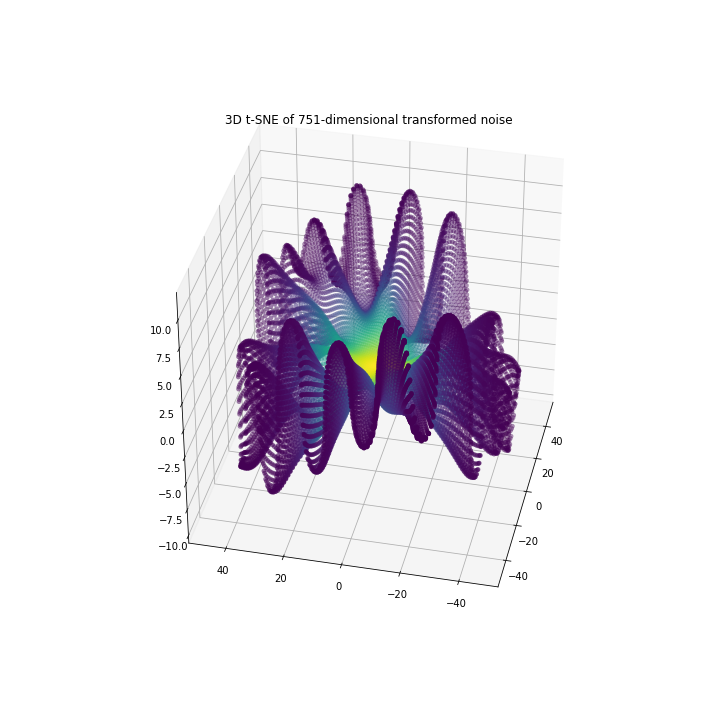

In [36]:
%matplotlib notebook
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.scatter(X_embedded[:,0],X_embedded[:,1],X_embedded[:,2], c=colors_stack, linewidth=0.2)
plt.title('3D t-SNE of '+str(param_count)+'-dimensional transformed noise')
plt.show()
plt.show()

